# **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note** If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

In [3]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2

%matplotlib inline

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


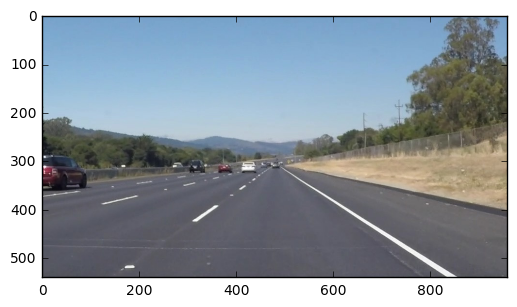

In [4]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')
#printing out some stats and plotting
print('This image is:', type(image), 'with dimesions:', image.shape)
plt.imshow(image)  #call as plt.imshow(gray, cmap='gray') to show a grayscaled image


**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [152]:
import math
from scipy import stats

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness = 3, minY = 0, maxY = 0, debugmode=0):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    leftrawpointsx = []
    leftrawpointsy = []
    rightrawpointsx = []
    rightrawpointsy = []
    
    for line in lines:
        for x1,y1,x2,y2 in line:
            slope = (y2-y1) / (x2-x1)
            if (x2 < 480 and x1 < 480):
                #Additional filter to smooth out randomness
                if (slope < -0.1):
                    leftrawpointsy.append(y1)
                    leftrawpointsx.append(x1)
                    leftrawpointsy.append(y2)
                    leftrawpointsx.append(x2)
                    
                    if (debugmode):
                        cv2.line(img, (x1, y1), (x2, y2), color, thickness)

#                    leftpointsy.append((y2+y1)/2)
#                    leftpointsx.append((x2+x1)/2)
#                    leftavgslopes.append(slope)
            else:
                if (slope > 0.1):
                    rightrawpointsy.append(y1)
                    rightrawpointsx.append(x1)
                    rightrawpointsy.append(y2)
                    rightrawpointsx.append(x2)

                    if (debugmode):
                        cv2.line(img, (x1, y1), (x2, y2), color, thickness)
#                    rightavgslopes.append(slope)
#                    rightpointsy.append((y2+y1)/2)
#                    rightpointsx.append((x2+x1)/2)
  
#    lslope = np.mean(leftavgslopes)
#    rslope = np.mean(rightavgslopes)
#    lb = np.mean(leftpointsy) - lslope * np.mean(leftpointsx) 
#    rb = np.mean(rightpointsy) - rslope * np.mean(rightpointsx) 

# old average method above, replaced by awesome lingress :)
    #left line

    if (debugmode):
        color = [0, 255, 0]

    if (leftrawpointsx and leftrawpointsy):
        lslope, lb, r_value, p_value, std_err = stats.linregress(leftrawpointsx,leftrawpointsy)
        print(lslope,lb,r_value,p_value,std_err)
        cv2.line(img, (int((maxY - lb)/lslope), maxY), (int((minY - lb)/lslope), minY), color, thickness)

    if (rightrawpointsx and rightrawpointsy):
        rslope, rb, r_value, p_value, std_err = stats.linregress(rightrawpointsx,rightrawpointsy)
        print(rslope,rb,r_value,p_value,std_err)
        cv2.line(img, (int((maxY - rb)/rslope), maxY), (int((minY - rb)/rslope), minY), color, thickness)


def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap, minY, maxY, debugmode):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((*img.shape, 3), dtype=np.uint8)
    
    draw_lines(line_img, lines, [255,0,0], 3, int(minY), int(maxY), debugmode)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

def find_hood_edge(img, rho, theta, threshold, min_line_len, max_line_gap, minY, maxY):
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    hoodpointsx = []
    hoodpointsy = []    
    for line in lines:
        for x1,y1,x2,y2 in line:
            if (y1 > 0.8 * maxY and y2 > 0.8 * maxY): #since the hood needs to be down there
                slope = (y2-y1) / (x2-x1)
                if (slope < 0.1 and slope > -0.1):
                    hoodpointsx.append(x1)
                    hoodpointsx.append(x2)
                    hoodpointsy.append(y1)
                    hoodpointsy.append(y2)
    if (hoodpointsx and hoodpointsy):
        lslope, lb, r_value, p_value, std_err = stats.linregress(hoodpointsx,hoodpointsy)
        print ('found a hood yo at y=',lb)
        return lb
    else:
        return maxY

                    

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
-0.695075874281 640.337952708 -0.996358018891 5.01534741659e-12 0.0188106954814
0.632712438552 4.24291093407 0.998431310822 2.64428277746e-11 0.0125445835924


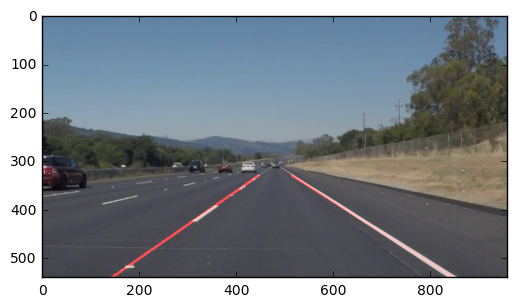

In [94]:
image = mpimg.imread('test_images/solidWhiteRight.jpg')
#printing out some stats and plotting
print('This image is:', type(image), 'with dimesions:', image.shape)
gray = grayscale(image)
kernel_size = 5
canny_low_thresh = 50
canny_hi_thresh = 100
gray = gaussian_blur(gray,kernel_size)
edges = canny(gray, canny_low_thresh, canny_hi_thresh)
imshape = image.shape
vertices = np.array([[(0,imshape[0]),(430, 330),(550,330) , (imshape[1],imshape[0])]], dtype=np.int32)
roi = region_of_interest(edges, vertices)
lines = hough_lines(roi, 1, np.pi/180, 30, 5, 4)
image = weighted_img(lines, image,0.8,1,1)
plt.imshow(image,cmap='gray')


# Test on Images

Now you should build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [1]:
import os
os.listdir("test_images/")

['solidWhiteCurve.jpg',
 'solidWhiteRight.jpg',
 'solidYellowCurve.jpg',
 'solidYellowCurve2.jpg',
 'solidYellowLeft.jpg',
 'whiteCarLaneSwitch.jpg']

run your solution on all test_images and make copies into the test_images directory).

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

In [20]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [191]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image with lines are drawn on lanes)
    #printing out some stats and plotting
    print('This image is:', type(image), 'with dimesions:', image.shape)
    debugmode = 1
    gray = grayscale(image)
    kernel_size = 5
    canny_low_thresh = 50
    canny_hi_thresh = 150
    gray = gaussian_blur(gray,kernel_size)
    edges = canny(gray, canny_low_thresh, canny_hi_thresh)
    imshape = image.shape
    maxY = imshape[0]
    minY = 0.6 * maxY
    maxY = find_hood_edge(edges, 2, np.pi/180, 45, 50, 2, minY, maxY) #brutal with that min line length cuz a hood should be very clearly visible
    minY = 0.6 * maxY
    laneminwidth = 50
    vertices = np.array([[(0,maxY),(imshape[1]/2 - laneminwidth, minY),(imshape[1]/2 + laneminwidth,minY) , (imshape[1],maxY)]], dtype=np.int32)
        
    roi = region_of_interest(edges, vertices)
    lines = hough_lines(roi, 2, np.pi/180, 45, 5, 4, minY, maxY, debugmode)
    if (debugmode):
        for index in range(int(vertices[0].size/2) - 1): #terrible, i know
            cv2.line(image, tuple(vertices[0][index]), tuple(vertices[0][index+1]), [0,0,255], 2)
            print('vertcies ',vertices[0][index])

    result = weighted_img(lines, image,0.8,1,1)
    return result

Let's try the one with the solid white lane on the right first ...

In [192]:
white_output = 'white.mp4'
clip1 = VideoFileClip("solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
-0.745578912246 658.818485152 -0.997187812598 7.09804897912e-15 0.0161754962673
0.61197487673 12.3590144408 0.998721343196 2.68593057794e-14 0.00979585582091
vertcies  [  0 540]
vertcies  [430 324]
vertcies  [530 324]
[MoviePy] >>>> Building video white.mp4
[MoviePy] Writing video white.mp4




  0%|          | 0/222 [00:00<?, ?it/s]

  2%|▏         | 4/222 [00:00<00:06, 34.36it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
-0.723903073507 650.080196729 -0.998019918443 3.18317577034e-18 0.0121932264553
0.627505408262 1.26795381809 0.99825460459 4.30655602134e-21 0.00928086564766
vertcies  [  0 540]
vertcies  [430 324]
vertcies  [530 324]
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
-0.717642523632 649.665734774 -0.997202171911 9.87546091597e-22 0.0126797363787
0.63036927331 0.558539686073 0.997833034054 9.92714282442e-23 0.00979730309514
vertcies  [  0 540]
vertcies  [430 324]
vertcies  [530 324]
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
-0.723510550794 651.426373786 -0.998352467173 8.44257529499e-24 0.00980116734548
0.630106610142 0.349314425612 0.998332047213 3.0977171533e-16 0.0105189914813
vertcies  [  0 540]
vertcies  [430 324]
vertcies  [530 324]
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
-0.718822815603 649.140797959 -0.99821855979 1.51951311624e-18 0.011

-0.696706648558 639.39888093 -0.998892178895 5.47471516996e-20 0.00877196370634
0.598921504546 19.443802365 0.998772661347 2.18868890517e-14 0.00939219642997
vertcies  [  0 540]
vertcies  [430 324]
vertcies  [530 324]




  4%|▍         | 9/222 [00:00<00:05, 37.43it/s]

  6%|▋         | 14/222 [00:00<00:05, 40.26it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
-0.70920981482 644.794818011 -0.998892151837 5.47565085703e-20 0.00892949545977
0.619544853603 7.63833861666 0.998423230259 2.21122947254e-16 0.0100553068191
vertcies  [  0 540]
vertcies  [430 324]
vertcies  [530 324]
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
-0.712174110958 648.449966289 -0.997315153061 2.67738971282e-17 0.0139756755892
0.622823241082 7.88055497894 0.998691597917 7.22306306314e-17 0.00920632490933
vertcies  [  0 540]
vertcies  [430 324]
vertcies  [530 324]
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
-0.707961497874 648.457118196 -0.997096595477 2.51578619354e-19 0.0135165459419
0.637916176355 1.22797875406 0.998631656441 9.44907171289e-17 0.00964343195124
vertcies  [  0 540]
vertcies  [430 324]
vertcies  [530 324]
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
-0.707300037587 648.549349834 -0.998451241538 3.71285286054e-34 0.00



  9%|▉         | 20/222 [00:00<00:04, 44.28it/s]

 11%|█▏        | 25/222 [00:00<00:04, 45.42it/s]

-0.718316472446 647.275536774 -0.997421847684 4.27588076823e-08 0.0210984478885
0.646563109147 -4.50570712513 0.998834479801 1.69046337453e-14 0.00988019950531
vertcies  [  0 540]
vertcies  [430 324]
vertcies  [530 324]
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
-0.712385072414 648.315042652 -0.99622471308 4.14644368135e-14 0.0179203534909
0.641500671426 -0.54315240692 0.998866185519 7.22029665836e-12 0.0108095513982
vertcies  [  0 540]
vertcies  [430 324]
vertcies  [530 324]
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
-0.684863722298 638.123465235 -0.998398716475 1.98671260606e-26 0.00867681502012
0.63547654595 2.21026231933 0.998798512477 4.33217879695e-09 0.0127288789272
vertcies  [  0 540]
vertcies  [430 324]
vertcies  [530 324]
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
-0.719370151324 650.422645175 -0.997408337384 2.09136800999e-17 0.0138687737402
0.6295320298 4.70440777806 0.99917060182 4.6913569299e-18



 14%|█▎        | 30/222 [00:00<00:04, 44.61it/s]

 16%|█▌        | 35/222 [00:00<00:04, 45.34it/s]

-0.684050818969 636.565638775 -0.998934501514 4.16861911606e-20 0.00844623258909
0.649136405692 -8.28624890926 0.998061048481 9.98282245896e-21 0.0101206107188
vertcies  [  0 540]
vertcies  [430 324]
vertcies  [530 324]
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
-0.737243785434 657.631777875 -0.996423390733 4.58160293546e-12 0.0197710293103
0.630855138371 2.73641704231 0.998831776235 1.71015300831e-14 0.00965135822177
vertcies  [  0 540]
vertcies  [430 324]
vertcies  [530 324]
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
-0.729653261527 653.649580154 -0.99549789366 8.36711943342e-18 0.0173679956864
0.651886949085 -10.5649094549 0.998298913758 1.10022546248e-18 0.0101751556698
vertcies  [  0 540]
vertcies  [430 324]
vertcies  [530 324]
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
-0.690160790148 637.982128453 -0.996715308674 2.99463814984e-12 0.0177330937131
0.640817396468 -4.33007636704 0.99889402059 6.5371691520



 18%|█▊        | 40/222 [00:00<00:03, 46.45it/s]

 20%|██        | 45/222 [00:00<00:03, 46.54it/s]

-0.709888993884 646.974518587 -0.997969014723 1.44626372931e-20 0.0113282064761
0.66227489123 -15.846174199 0.998791780608 4.47962990199e-17 0.00940652871502
vertcies  [  0 540]
vertcies  [430 324]
vertcies  [530 324]
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
-0.726242808809 652.649568155 -0.998438251439 1.77058459587e-21 0.0101590141882
0.661537215284 -14.999178362 0.998862445355 3.1208056669e-17 0.00911665585725
vertcies  [  0 540]
vertcies  [430 324]
vertcies  [530 324]
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
-0.72776189848 652.100788998 -0.998335139065 2.95197080181e-21 0.0105117762922
0.661150813023 -14.7264507208 0.998680833775 7.20764513819e-30 0.00724742894931
vertcies  [  0 540]
vertcies  [430 324]
vertcies  [530 324]
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
-0.715823551087 646.11063589 -0.99514311393 2.11116100889e-11 0.0223916669352
0.629594481471 3.85270001658 0.997804625021 3.45117601249e-3



 23%|██▎       | 50/222 [00:01<00:03, 44.97it/s]

 25%|██▍       | 55/222 [00:01<00:03, 42.58it/s]

-0.712484787251 645.04314844 -0.997157847041 7.56362878644e-15 0.0155399987895
0.646332935516 -6.92120426659 0.998094796462 5.75109212247e-11 0.0141259685884
vertcies  [  0 540]
vertcies  [430 324]
vertcies  [530 324]
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
-0.729039655663 650.395013761 -0.997595849835 1.45737372672e-10 0.0179054868385
0.639523008234 -3.66612413645 0.998756647738 2.86030089551e-22 0.00798019593357
vertcies  [  0 540]
vertcies  [430 324]
vertcies  [530 324]
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
-0.717026344153 646.514828547 -0.997178853409 3.78528760007e-17 0.0144251168729
0.648584132503 -7.29480096045 0.997995436373 9.32706122379e-16 0.0118728316547
vertcies  [  0 540]
vertcies  [430 324]
vertcies  [530 324]
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
-0.698469672229 638.014120933 -0.998637398748 2.33004856218e-19 0.00975499623918
0.64690266955 -7.75328370673 0.998518060552 2.106334612



 27%|██▋       | 60/222 [00:01<00:04, 39.47it/s]

-0.687915602222 634.408732019 -0.998520261344 4.14901501242e-19 0.0100129269433
0.648135994035 -4.23454887041 0.998628879207 3.80746954037e-14 0.0107439989458
vertcies  [  0 540]
vertcies  [430 324]
vertcies  [530 324]
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
-0.684464363195 634.647171715 -0.997543074442 6.62450210697e-20 0.0120171994117
0.657721269815 -9.84464934835 0.998560124516 2.51314509553e-24 0.00832822581521
vertcies  [  0 540]
vertcies  [430 324]
vertcies  [530 324]
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
-0.688775120815 635.972434647 -0.998258894289 1.29457642261e-18 0.010876989087
0.636157165569 2.02218184571 0.997949314868 1.5622787129e-20 0.0102008807905
vertcies  [  0 540]
vertcies  [430 324]
vertcies  [530 324]
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
-0.687215955364 634.490907453 -0.997754230683 7.67948204614e-18 0.0123298910703
0.645378354296 -3.87931689856 0.998518372495 1.1621129509e



 29%|██▉       | 64/222 [00:01<00:03, 39.56it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
-0.677562824339 631.972548756 -0.998679657104 2.88947851488e-27 0.00779333474931
0.646874683416 -3.46645729916 0.998657699174 3.42395470712e-14 0.0106095664973
vertcies  [  0 540]
vertcies  [430 324]
vertcies  [530 324]
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)




 31%|███       | 68/222 [00:01<00:03, 39.08it/s]

-0.678714006944 631.031323551 -0.998874485422 1.25819130005e-30 0.00687120453256
0.660886351597 -11.7594940451 0.998571444354 4.67414377793e-14 0.0111829416884
vertcies  [  0 540]
vertcies  [430 324]
vertcies  [530 324]
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
-0.684476050412 632.776448796 -0.995139643349 1.88353332412e-13 0.0195525914044
0.6550609502 -8.06270007572 0.997986937561 3.57307523153e-18 0.0111254549924
vertcies  [  0 540]
vertcies  [430 324]
vertcies  [530 324]
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
-0.661041520324 621.354437995 -0.997951727878 4.03380450539e-18 0.0113250860062
0.662787865554 -13.5499638856 0.998255854312 4.66687621298e-26 0.00876465067257
vertcies  [  0 540]
vertcies  [430 324]
vertcies  [530 324]
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
-0.670019405395 626.000577718 -0.995601757795 1.03530942356e-13 0.0182006799608
0.653852226409 -9.41461448652 0.997729933554 4.729329468



 32%|███▏      | 72/222 [00:01<00:03, 38.49it/s]

-0.667338226916 626.516395231 -0.99743181514 4.11963222425e-15 0.0138331563461
0.659137769908 -9.80646116126 0.998720620394 1.49925110166e-19 0.00891957007901
vertcies  [  0 540]
vertcies  [430 324]
vertcies  [530 324]
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
-0.674872886121 628.438685329 -0.996409234666 2.0443250868e-16 0.0153263421038
0.657966125518 -11.50077834 0.999021161536 2.34290245338e-09 0.0118937123701
vertcies  [  0 540]
vertcies  [430 324]
vertcies  [530 324]
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)




 34%|███▍      | 76/222 [00:01<00:03, 37.48it/s]

-0.666756351933 625.287664576 -0.998049717947 1.04587990198e-20 0.0104257390743
0.66583406756 -13.164935887 0.998325004259 1.0353955833e-13 0.0122020830977
vertcies  [  0 540]
vertcies  [430 324]
vertcies  [530 324]
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
-0.681072992763 631.355504762 -0.998496072306 3.71736780739e-24 0.00881406347173
0.652120930921 -7.09694864849 0.998218616201 4.59598492008e-16 0.0112515434422
vertcies  [  0 540]
vertcies  [430 324]
vertcies  [530 324]
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
-0.670862561506 626.377572037 -0.998472999589 1.47906743587e-21 0.00927910221824
0.640143777976 1.69045086005 0.99904083028 6.50285711204e-26 0.00661327527683
vertcies  [  0 540]
vertcies  [430 324]
vertcies  [530 324]
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
-0.667552126427 623.332852037 -0.998636531173 5.97939901491e-22 0.00872383133788
0.660746321977 -10.6076761062 0.998112407838 2.2779372128



 36%|███▋      | 81/222 [00:01<00:03, 39.24it/s]

-0.662869620599 622.457853395 -0.998501305786 5.9392364393e-14 0.0114891582671
0.684564016798 -22.96326046 0.998217897653 4.40331317002e-11 0.0144687650643
vertcies  [  0 540]
vertcies  [430 324]
vertcies  [530 324]
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
-0.671629762456 624.697177281 -0.994063193945 5.75059524349e-11 0.023246727705
0.671895722178 -15.2669552848 0.998506735277 1.59559528132e-16 0.0106116145157
vertcies  [  0 540]
vertcies  [430 324]
vertcies  [530 324]
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
-0.651238196936 616.871360097 -0.996353263483 1.55468613902e-18 0.0139423960828
0.687849848124 -26.0117278037 0.998165216997 1.54204239827e-08 0.0170342744488
vertcies  [  0 540]
vertcies  [430 324]
vertcies  [530 324]




 38%|███▊      | 85/222 [00:02<00:03, 39.23it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
-0.648400620356 616.894569618 -0.996162680048 9.44254066678e-10 0.0201409584044
0.691762443622 -27.8225836458 0.998212698661 1.43200763679e-13 0.0130964514529
vertcies  [  0 540]
vertcies  [430 324]
vertcies  [530 324]
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
-0.655072093098 619.160011509 -0.997409408194 2.08533266779e-17 0.0126265487379
0.672433847307 -16.4314028184 0.998462071676 5.43420677477e-19 0.00997860837913
vertcies  [  0 540]
vertcies  [430 324]
vertcies  [530 324]
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
-0.658488335435 619.2707624 -0.997808625591 1.90828670425e-27 0.00930946506668
0.684849490237 -25.2430758597 0.998431957159 6.22378538506e-19 0.0102621011452
vertcies  [  0 540]
vertcies  [430 324]
vertcies  [530 324]
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
-0.651281785765 616.784011107 -0.998927704778 1.77295397925e-25 0.0

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
-0.671325530969 625.39105409 -0.998652861893 1.38085251139e-24 0.00822161443499
0.674974150226 -18.6549143621 0.998508120475 1.22798272434e-21 0.00922774073064
vertcies  [  0 540]
vertcies  [430 324]
vertcies  [530 324]
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
-0.662469684961 622.767416213 -0.998926959596 1.78406895291e-25 0.00723939915571
0.68465914575 -23.3273832086 0.998630455615 4.16510342252e-27 0.00802063800128
vertcies  [  0 540]
vertcies  [430 324]
vertcies  [530 324]
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)




 41%|████      | 90/222 [00:02<00:03, 39.67it/s]

 42%|████▏     | 94/222 [00:02<00:03, 39.66it/s]

-0.664201296757 624.436286902 -0.996156267179 9.50574673147e-10 0.0206490995698
0.676740804653 -18.8931630077 0.998264318935 3.93274440265e-16 0.0115251774733
vertcies  [  0 540]
vertcies  [430 324]
vertcies  [530 324]
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
-0.655571159913 621.578373683 -0.997077010048 8.94816829799e-15 0.0145014550681
0.678993001116 -19.9091781365 0.998745647767 1.30570031638e-19 0.00909776886934
vertcies  [  0 540]
vertcies  [430 324]
vertcies  [530 324]
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
-0.654950037832 621.862919751 -0.99875764197 2.84206316799e-22 0.00816942554854
0.679844716204 -19.7458714858 0.997609125714 2.27550797118e-29 0.00961340678785
vertcies  [  0 540]
vertcies  [430 324]
vertcies  [530 324]
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
-0.654914882443 621.662694669 -0.998932292826 8.4627776779e-23 0.00757205810259
0.69964230978 -32.353838864 0.998215753585 1.536336422



 45%|████▍     | 99/222 [00:02<00:03, 40.42it/s]

 47%|████▋     | 104/222 [00:02<00:02, 41.27it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
-0.648318932143 618.371796084 -0.998147388269 1.9985516174e-18 0.0105617522562
0.706980897403 -41.6795480691 0.997714053616 3.72200386426e-20 0.0119712990749
vertcies  [  0 540]
vertcies  [430 324]
vertcies  [530 324]
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
-0.651523141555 620.190170571 -0.998195607822 6.55240804247e-26 0.0087636224974
0.700731366882 -39.4514001178 0.998601763104 1.07565981689e-16 0.0107083391829
vertcies  [  0 540]
vertcies  [430 324]
vertcies  [530 324]
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
-0.655061887275 620.440736893 -0.998514171897 3.33379088056e-24 0.00842616087793
0.692002048323 -33.0958924949 0.998156828329 6.65845626972e-21 0.0105183177331
vertcies  [  0 540]
vertcies  [430 324]
vertcies  [530 324]
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
-0.636623978377 615.771188622 -0.986984337729 1.23607195708e-07 0.0



 49%|████▉     | 109/222 [00:02<00:02, 39.61it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
-0.683583708733 633.74997407 -0.996725418299 4.06278913939e-21 0.0130712465477
0.669944074596 -20.4180053456 0.998677827386 1.16699951119e-24 0.008128162283
vertcies  [  0 540]
vertcies  [430 324]
vertcies  [530 324]
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
-0.695210079658 638.954662363 -0.997754060659 1.36966421835e-22 0.0110008521038
0.683248057357 -25.5743436764 0.99800446016 3.36112181193e-18 0.0115534139365
vertcies  [  0 540]
vertcies  [430 324]
vertcies  [530 324]
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
-0.695407299163 638.93656809 -0.998030338907 5.90893852187e-28 0.00931924980517
0.669568864883 -20.4833412881 0.998835184989 3.73281129721e-25 0.0076239868371
vertcies  [  0 540]
vertcies  [430 324]
vertcies  [530 324]
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
-0.683263915724 633.899134459 -0.998583877335 5.81822626639e-27 0.0081



 51%|█████▏    | 114/222 [00:02<00:02, 40.79it/s]

-0.646069261168 619.089441604 -0.996855403682 1.38660620324e-14 0.0148255921258
0.671470333319 -21.6811413238 0.998353886391 2.69644859535e-21 0.00964380516801
vertcies  [  0 540]
vertcies  [430 324]
vertcies  [530 324]
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)




 54%|█████▎    | 119/222 [00:02<00:02, 41.20it/s]

-0.673885942329 630.070410068 -0.9985157341 2.11958655845e-11 0.0129955938993
0.672048909255 -23.2346656857 0.998244850527 1.36941300465e-18 0.0106556804833
vertcies  [  0 540]
vertcies  [430 324]
vertcies  [530 324]
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
-0.691367661048 635.382174305 -0.993935152489 6.39668596826e-11 0.0241889194729
0.665318521022 -20.0175613916 0.998677420252 4.77476105538e-35 0.00671738122217
vertcies  [  0 540]
vertcies  [430 324]
vertcies  [530 324]
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
-0.672619441626 629.484401629 -0.998535126448 1.42209685223e-16 0.0105213485455
0.66943561346 -20.8849196982 0.997592723922 5.62719039478e-20 0.0116335422754
vertcies  [  0 540]
vertcies  [430 324]
vertcies  [530 324]
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
-0.663924470938 625.508923971 -0.999013092312 2.43864010671e-20 0.00788913819578
0.666915180554 -19.0724732765 0.99803230002 8.34475083705

-0.678321328584 634.839424678 -0.998947368348 7.55313803061e-23 0.00778702854281
0.643994858013 -4.4032052782 0.998655114872 5.35799720325e-22 0.00835830862176
vertcies  [  0 540]
vertcies  [430 324]
vertcies  [530 324]
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)




 56%|█████▌    | 124/222 [00:02<00:02, 40.26it/s]

 58%|█████▊    | 129/222 [00:03<00:02, 39.35it/s]

-0.673469001007 632.72947574 -0.998187252379 1.71645091086e-18 0.0108524635846
0.637295784694 -1.70949986969 0.998220112062 1.40257179035e-13 0.0120401728871
vertcies  [  0 540]
vertcies  [430 324]
vertcies  [530 324]
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
-0.680139176834 635.478165731 -0.99813841863 2.06722827706e-18 0.0111070006871
0.640683660579 -5.0348358698 0.99803244226 4.16691750604e-23 0.00948697481618
vertcies  [  0 540]
vertcies  [430 324]
vertcies  [530 324]
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
-0.660588867002 628.567945972 -0.995606497896 1.279740662e-11 0.0196465547046
0.629241849638 5.28806120832 0.997855725876 5.55717232545e-18 0.0110308261778
vertcies  [  0 540]
vertcies  [430 324]
vertcies  [530 324]
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
-0.664409424682 630.284384623 -0.99216572968 1.63261408014e-08 0.0295779845374
0.644895043699 -4.2938731549 0.998572566973 1.81324677787e-11 0



 60%|█████▉    | 133/222 [00:03<00:02, 37.89it/s]

 62%|██████▏   | 137/222 [00:03<00:02, 37.28it/s]

-0.704822971384 648.500972486 -0.998095073395 8.66542232507e-21 0.0108916918333
0.629548146031 2.53471644739 0.998711516379 2.26359014117e-27 0.0071530029163
vertcies  [  0 540]
vertcies  [430 324]
vertcies  [530 324]
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
-0.71587906884 652.633461692 -0.998165414258 2.70638853327e-28 0.00925785836101
0.63496958892 0.0984743822719 0.997178149306 1.40241677055e-12 0.015116651151
vertcies  [  0 540]
vertcies  [430 324]
vertcies  [530 324]
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
-0.689251774811 640.39448887 -0.999063542437 2.98857264839e-34 0.00609307482397
0.642993200276 -5.47015505914 0.998779592991 1.07765197377e-19 0.00849781950074
vertcies  [  0 540]
vertcies  [430 324]
vertcies  [530 324]
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
-0.70810217421 646.46471232 -0.998298442167 1.10236097653e-18 0.0110541422448
0.646111024691 -8.33563699651 0.998965345877 9.32132113621e



 64%|██████▎   | 141/222 [00:03<00:02, 36.41it/s]

 66%|██████▌   | 146/222 [00:03<00:02, 37.85it/s]

0.640086415246 -6.00687606181 0.998362756788 7.74658486349e-29 0.00781866599673
vertcies  [  0 540]
vertcies  [430 324]
vertcies  [530 324]
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
-0.681028342958 637.563681195 -0.99765967123 2.36033823951e-15 0.0134738383795
0.628546226171 3.37618749052 0.99842429035 6.43982043552e-19 0.00944147862828
vertcies  [  0 540]
vertcies  [430 324]
vertcies  [530 324]
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
-0.688465855052 641.560005621 -0.998513043544 9.47629243829e-27 0.0084045852112
0.622395803541 7.48986379694 0.998685450414 1.30436969951e-11 0.011294152601
vertcies  [  0 540]
vertcies  [430 324]
vertcies  [530 324]
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
-0.71283736332 652.2388411 -0.995698605618 1.15127977037e-11 0.0209756131547
0.62561153471 5.34226968061 0.998659669193 5.21462532609e-22 0.00810592664535
vertcies  [  0 540]
vertcies  [430 324]
vertcies  [530 324]
This



 68%|██████▊   | 150/222 [00:03<00:01, 37.22it/s]

0.62976439455 1.51656801121 0.998305847476 1.06923416364e-18 0.00980974466267
vertcies  [  0 540]
vertcies  [430 324]
vertcies  [530 324]
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
-0.728340442923 656.100676901 -0.998217522899 5.09472797469e-21 0.010886357861
0.640314146825 -7.58142090604 0.998371293218 2.35414378796e-26 0.00818173780514
vertcies  [  0 540]
vertcies  [430 324]
vertcies  [530 324]
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
-0.731114984026 657.592542467 -0.998777015457 1.34380076509e-27 0.00809272540915
0.635700828931 -5.54475464748 0.998496716392 8.72664311019e-32 0.00712315994704
vertcies  [  0 540]
vertcies  [430 324]
vertcies  [530 324]
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
-0.738602825296 662.140834981 -0.996592758822 5.87236112684e-10 0.0216119735581
0.63618842151 -6.29030649591 0.998554090903 9.56119767684e-22 0.00856214587397
vertcies  [  0 540]
vertcies  [430 324]
vertcies  [530 3



 70%|██████▉   | 155/222 [00:03<00:01, 38.59it/s]

 72%|███████▏  | 160/222 [00:03<00:01, 39.82it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
-0.722042674451 654.755256116 -0.997158142429 5.72559757129e-08 0.0222705315465
0.622860726074 0.621157012172 0.998669575775 1.97129308528e-19 0.00859549087013
vertcies  [  0 540]
vertcies  [430 324]
vertcies  [530 324]
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
-0.713350888597 651.257292429 -0.997177035701 5.73236719589e-24 0.0120109377212
0.620345204349 2.74799725487 0.998443451982 1.49677821081e-26 0.00774858054084
vertcies  [  0 540]
vertcies  [430 324]
vertcies  [530 324]
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
-0.751457099984 666.438760287 -0.998170761657 1.60796849389e-13 0.0143929824477
0.628063349558 -2.77705284226 0.997525024816 7.26901294425e-27 0.00943843196886
vertcies  [  0 540]
vertcies  [430 324]
vertcies  [530 324]
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
-0.749438607841 664.803991705 -0.997381454647 1.10224835878e-19 0

-0.761514205315 674.269088978 -0.99788185509 1.29793808552e-15 0.014330818506
0.594739627007 19.0845700584 0.998053493575 3.78270995852e-23 0.00875927740976
vertcies  [  0 540]
vertcies  [430 324]
vertcies  [530 324]
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)




 74%|███████▍  | 165/222 [00:04<00:01, 39.40it/s]

 76%|███████▌  | 169/222 [00:04<00:01, 37.68it/s]

-0.740121286738 666.066377017 -0.998495311063 4.66389220751e-19 0.0108634502129
0.5930960126 18.7631870554 0.998202917017 7.42207735143e-31 0.0072678241198
vertcies  [  0 540]
vertcies  [430 324]
vertcies  [530 324]
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
-0.686625233692 647.944318124 -0.96101120799 0.000143870749404 0.080653944053
0.592691008845 17.5435373719 0.99746101274 8.61371385969e-20 0.0105789322199
vertcies  [  0 540]
vertcies  [430 324]
vertcies  [530 324]
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
-0.754137866347 673.030688961 -0.997161285172 7.50895194306e-15 0.0164384993457
0.588101595096 23.5916729623 0.999061136584 1.32178298251e-06 0.0127510087185
vertcies  [  0 540]
vertcies  [430 324]
vertcies  [530 324]
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
-0.766487020397 677.789296023 -0.996698073487 3.07394477925e-12 0.0197460888725
0.581485375553 27.9829144169 0.998935785655 2.09255099522e-17 0.



 78%|███████▊  | 173/222 [00:04<00:01, 37.21it/s]

 80%|████████  | 178/222 [00:04<00:01, 38.47it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
-0.766467802228 677.180137926 -0.998160805369 7.9306101357e-26 0.0104089630901
0.599579845864 16.6404108706 0.999014967972 4.11401640589e-12 0.0094159303288
vertcies  [  0 540]
vertcies  [430 324]
vertcies  [530 324]
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
-0.767396416747 676.715948025 -0.998480453573 9.92859870632e-32 0.00864532885978
0.605453174532 13.6315061496 0.999025162784 2.23743516924e-20 0.00715015236719
vertcies  [  0 540]
vertcies  [430 324]
vertcies  [530 324]
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
-0.744966616635 669.219527975 -0.991275695993 2.50811377385e-08 0.0350209926423
0.596320530252 19.3180659415 0.99907878103 8.80667077337e-18 0.00739410807596
vertcies  [  0 540]
vertcies  [430 324]
vertcies  [530 324]
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
-0.787018641992 685.703678505 -0.994224190976 6.11544388642e-17 0.021



 82%|████████▏ | 183/222 [00:04<00:01, 39.00it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
-0.802057007126 691.18027791 -0.99727856302 2.94320884748e-17 0.0158468591204
0.597415827702 16.5013296022 0.998759535949 1.20784742328e-19 0.00796020282073
vertcies  [  0 540]
vertcies  [430 324]
vertcies  [530 324]
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
-0.817770645426 698.561921582 -0.998392562668 2.06434488946e-26 0.0103806036623
0.596813032103 15.7751764259 0.998985492537 8.44874739813e-15 0.0085076881159
vertcies  [  0 540]
vertcies  [430 324]
vertcies  [530 324]
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
-0.789928460112 686.793882345 -0.997690445744 1.76070207292e-22 0.0126760480342
0.583263912486 24.3396885379 0.998526736826 4.02364439119e-19 0.00847103622268
vertcies  [  0 540]
vertcies  [430 324]
vertcies  [530 324]
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
-0.818944194271 698.099226103 -0.997220597137 1.30015520968e-12 0.0193



 85%|████████▍ | 188/222 [00:04<00:00, 40.01it/s]

 87%|████████▋ | 193/222 [00:04<00:00, 39.54it/s]

-0.783592353184 682.363292532 -0.993757718887 8.42821371722e-13 0.0253937537272
0.598121809263 14.5481543859 0.999119239163 2.62997096435e-12 0.00888128220499
vertcies  [  0 540]
vertcies  [430 324]
vertcies  [530 324]
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
-0.750757651447 668.756619043 -0.987742065753 9.73295126839e-08 0.0419469010699
0.583858229492 19.2280961291 0.999238927729 1.46650977985e-12 0.00805820603078
vertcies  [  0 540]
vertcies  [430 324]
vertcies  [530 324]
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
-0.778246050916 676.727779726 -0.999021123782 1.26749867188e-17 0.00994773509499
0.583057807636 18.4793685479 0.998760054716 1.20431761698e-19 0.00776726324544
vertcies  [  0 540]
vertcies  [430 324]
vertcies  [530 324]
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
-0.777650670076 679.409396077 -0.990632217119 5.59296231772e-10 0.0338989327306
0.583836498743 19.2697008318 0.998769536709 7.902818147



 89%|████████▉ | 198/222 [00:04<00:00, 40.19it/s]

 91%|█████████▏| 203/222 [00:04<00:00, 41.09it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
-0.794823351302 687.500153418 -0.997059955784 5.05196856213e-17 0.0163251736071
0.587442069169 24.1573876879 0.99898206911 5.77709190455e-23 0.00663148751855
vertcies  [  0 540]
vertcies  [430 324]
vertcies  [530 324]
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
-0.749140947096 670.095954883 -0.997560788493 6.77222661092e-13 0.0165767313097
0.580374587628 26.4790791781 0.998844836298 3.46362055962e-25 0.00658090186999
vertcies  [  0 540]
vertcies  [430 324]
vertcies  [530 324]
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
-0.779895786077 681.144869224 -0.994039785747 6.39013398705e-13 0.0246910767337
0.567260858974 33.8993470082 0.998873813193 5.89388449704e-28 0.00602497292607
vertcies  [  0 540]
vertcies  [430 324]
vertcies  [530 324]
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
-0.758682462929 674.802505896 -0.998269560036 3.86207112321e-16 0.01



 94%|█████████▎| 208/222 [00:05<00:00, 41.57it/s]

 96%|█████████▌| 213/222 [00:05<00:00, 42.84it/s]

-0.781001906743 682.134338707 -0.992425719388 1.93850598645e-10 0.0305714366713
0.56327256286 34.7864491286 0.998726407006 7.17756167525e-38 0.00537755739433
vertcies  [  0 540]
vertcies  [430 324]
vertcies  [530 324]
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
-0.81244167441 694.295086338 -0.997442204315 1.043651317e-26 0.0124126110773
0.568176661527 31.8670986891 0.998319821691 3.23638438457e-16 0.00951991911452
vertcies  [  0 540]
vertcies  [430 324]
vertcies  [530 324]
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
-0.793042549069 687.015029268 -0.99754643131 1.42602240214e-17 0.0148746550798
0.570455239841 29.0277683209 0.998460176006 1.91816097492e-16 0.00914920784164
vertcies  [  0 540]
vertcies  [430 324]
vertcies  [530 324]
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
-0.81296375169 693.042849072 -0.997786056475 5.05858098757e-25 0.0121164811602
0.560733863855 36.5200014603 0.99758856559 5.70535160649e-20 0



 98%|█████████▊| 218/222 [00:05<00:00, 41.08it/s]

100%|█████████▉| 221/222 [00:05<00:00, 40.63it/s]

vertcies  [  0 540]
vertcies  [430 324]
vertcies  [530 324]
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
-0.757144593293 673.520886113 -0.995257767169 1.87382608438e-11 0.0234009878611
0.570190995595 33.613103896 0.998974535374 4.83199266786e-12 0.00913660639603
vertcies  [  0 540]
vertcies  [430 324]
vertcies  [530 324]
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
-0.751079795386 672.30324201 -0.996723528161 2.53826970812e-23 0.013628829512
0.562337373493 37.9479884491 0.998976021564 4.80405035546e-12 0.00900421981
vertcies  [  0 540]
vertcies  [430 324]
vertcies  [530 324]
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
-0.774209292929 681.073860202 -0.996759723896 9.97045628215e-17 0.0166977438283
0.566694350032 36.5698242777 0.999159755461 1.05871971655e-06 0.0116227943475
vertcies  [  0 540]
vertcies  [430 324]
vertcies  [530 324]
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
-0.79049994776

[MoviePy] Done.
[MoviePy] >>>> Video ready: white.mp4 

CPU times: user 15.4 s, sys: 2.28 s, total: 17.7 s
Wall time: 5.83 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [129]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

**At this point, if you were successful you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform.  Modify your draw_lines function accordingly and try re-running your pipeline.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [193]:
yellow_output = 'yellow.mp4'
clip2 = VideoFileClip('solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
-0.637007092577 615.625094329 -0.998979094224 1.63100647268e-17 0.0083156116988
0.682099641264 -28.1494626372 0.998417354971 5.88195144579e-24 0.00905595597237
vertcies  [  0 540]
vertcies  [430 324]
vertcies  [530 324]
[MoviePy] >>>> Building video yellow.mp4
[MoviePy] Writing video yellow.mp4




  0%|          | 0/682 [00:00<?, ?it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)




  0%|          | 3/682 [00:00<00:24, 27.93it/s]

-0.537545218133 575.369195812 -0.96014116498 6.50419100972e-16 0.0306901643501
0.684437928274 -28.60538286 0.997459961513 1.81686310113e-17 0.0130627245237
vertcies  [  0 540]
vertcies  [430 324]
vertcies  [530 324]
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
-0.617412311723 610.798998727 -0.997757171833 3.19650085764e-20 0.0103552308706
0.683656335717 -27.2884142121 0.997568440448 2.79708463613e-22 0.0112577649934
vertcies  [  0 540]
vertcies  [430 324]
vertcies  [530 324]
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
-0.635439057957 616.134050291 -0.998672701199 7.87170231819e-17 0.00946052625929
0.699104234528 -37.0150651466 0.998697770312 1.01788047334e-24 0.00841761309118
vertcies  [  0 540]
vertcies  [430 324]
vertcies  [530 324]
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
-0.637934912621 617.403728512 -0.99833040509 9.51554669619e-24 0.00869971497259
0.680665009876 -25.6928140742 0.998378011314 2.2588848190



  1%|          | 7/682 [00:00<00:22, 29.93it/s]

-0.655269224914 626.88926535 -0.998477478539 4.15178294546e-24 0.00853250568364
0.687445955802 -30.4057112028 0.998117624107 2.79871056298e-23 0.00995598620396
vertcies  [  0 540]
vertcies  [430 324]
vertcies  [530 324]
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)




  2%|▏         | 11/682 [00:00<00:21, 31.45it/s]

-0.655154260895 626.209375889 -0.998913137705 4.78982503395e-20 0.00817026324311
0.680128086594 -27.2723292367 0.998211144103 5.24232035016e-21 0.0101839596829
vertcies  [  0 540]
vertcies  [430 324]
vertcies  [530 324]
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
-0.657976361598 626.34340211 -0.99869172369 1.75283805541e-19 0.00900404109721
0.661935358653 -17.6936584469 0.996035070761 5.56175534407e-14 0.0170668012668
vertcies  [  0 540]
vertcies  [430 324]
vertcies  [530 324]
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
-0.668409630133 629.839423079 -0.998674180715 4.77992829241e-22 0.00861334914872
0.681205804343 -30.0124777065 0.999264877316 5.93791396386e-27 0.00615994089015
vertcies  [  0 540]
vertcies  [430 324]
vertcies  [530 324]
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
-0.656838871482 625.231356492 -0.998049817444 3.84744238319e-23 0.0096830274738
0.652942536026 -13.0545131069 0.996252509361 1.3120193



  2%|▏         | 14/682 [00:00<00:21, 30.42it/s]

-0.671980154733 633.114979043 -0.997934131319 2.48806110668e-37 0.00789834104611
0.647609959451 -9.28320118545 0.997427930591 1.10946128691e-26 0.00992196188695
vertcies  [  0 540]
vertcies  [430 324]
vertcies  [530 324]
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)




  3%|▎         | 18/682 [00:00<00:21, 31.49it/s]

-0.688963862296 640.00560735 -0.998598774095 3.75559898494e-32 0.00745275218595
0.641928328219 -6.85777202675 0.997806859155 1.9252601466e-27 0.00907901487435
vertcies  [  0 540]
vertcies  [430 324]
vertcies  [530 324]
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
-0.693230122637 640.153452203 -0.99835998356 2.79933235565e-16 0.0114752089009
0.631874279214 0.688815454838 0.997739008227 3.40936976396e-20 0.010640758831
vertcies  [  0 540]
vertcies  [430 324]
vertcies  [530 324]
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
-0.680455738455 635.945106038 -0.997477194937 8.1846046462e-20 0.0121065298214
0.640578415627 -6.37971576665 0.998228922711 1.45874747695e-18 0.0102028032421
vertcies  [  0 540]
vertcies  [430 324]
vertcies  [530 324]
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
-0.680984655727 635.573416573 -0.998623050627 1.68133138655e-24 0.00843187033867
0.621966894626 5.93456378975 0.998657417185 2.10084449645e

-0.707695117411 644.943176949 -0.998717757966 1.5228783595e-19 0.00958738460713
0.652290483086 -13.7260354586 0.999059564003 1.74008192841e-20 0.00756594416644
vertcies  [  0 540]
vertcies  [430 324]
vertcies  [530 324]
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)




  3%|▎         | 22/682 [00:00<00:20, 31.70it/s]

  4%|▍         | 27/682 [00:00<00:18, 34.73it/s]

-0.674656563021 632.171542659 -0.998681037846 1.85549420678e-19 0.0092700022805
0.646472689927 -11.0432960034 0.999053413315 1.03650942858e-17 0.00812574607402
vertcies  [  0 540]
vertcies  [430 324]
vertcies  [530 324]
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
-0.68362565042 634.089591743 -0.998822355198 1.7802031361e-14 0.0105008475732
0.627837562425 0.581287445706 0.995316560331 1.30902382081e-15 0.0162971032083
vertcies  [  0 540]
vertcies  [430 324]
vertcies  [530 324]
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
-0.691286988715 637.08039892 -0.9982977446 1.26727081529e-33 0.00792052698892
0.623927263839 2.090675764 0.997514157956 3.38858699867e-15 0.012723481705
vertcies  [  0 540]
vertcies  [430 324]
vertcies  [530 324]
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
-0.693416582785 639.748357552 -0.997646119072 3.65700883305e-41 0.00817390847415
0.642184729931 -7.38994119694 0.99776711172 1.29973639046e-22 



  5%|▍         | 31/682 [00:01<00:23, 27.70it/s]

-0.741722640073 657.773544792 -0.998342122938 2.95260604912e-41 0.0075595898551
0.610688774275 7.70565426233 0.997903538509 1.86380239527e-20 0.00990152493765
vertcies  [  0 540]
vertcies  [430 324]
vertcies  [530 324]
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
-0.72366657146 650.826567172 -0.997609406588 1.0434109253e-31 0.00983103966721
0.665285375835 -25.3802886065 0.990902683963 4.83304326857e-10 0.0285731834403
vertcies  [  0 540]
vertcies  [430 324]
vertcies  [530 324]
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)




  5%|▌         | 35/682 [00:01<00:21, 29.72it/s]

-0.710938981658 645.377627018 -0.997809707102 7.95914661204e-30 0.00962071034386
0.658306569885 -20.4450776914 0.996192412634 9.15359814384e-10 0.0203688310074
vertcies  [  0 540]
vertcies  [430 324]
vertcies  [530 324]
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
-0.710159935071 644.625727609 -0.998028374395 4.24503435981e-23 0.0105266474089
0.655357635719 -20.6410161143 0.995930221273 1.19436944375e-09 0.020968266849
vertcies  [  0 540]
vertcies  [430 324]
vertcies  [530 324]
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
-0.718427066404 649.056215092 -0.997832593324 2.43182357115e-20 0.0118444461886
0.659678546471 -22.9182389937 0.99409727142 5.11886669546e-07 0.0293918843516
vertcies  [  0 540]
vertcies  [430 324]
vertcies  [530 324]
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
-0.73015935138 651.42082086 -0.997820437605 6.22926218239e-18 0.0129051815259
0.628658745422 -5.27213689175 0.997478248496 3.88079633985e

-0.735811367595 653.856439516 -0.99672213767 4.09952042352e-21 0.0140770063752
0.620007356907 1.17603647783 0.997250152582 4.41058470669e-24 0.0103026337989
vertcies  [  0 540]
vertcies  [430 324]
vertcies  [530 324]
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
-0.744941705185 656.719737287 -0.997681523197 3.54599602427e-27 0.0108338675786
0.632262362189 -7.00901556416 0.998811401926 4.47714751768e-25 0.0072724543817
vertcies  [  0 540]
vertcies  [430 324]
vertcies  [530 324]
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)




  6%|▌         | 40/682 [00:01<00:19, 32.37it/s]

  7%|▋         | 45/682 [00:01<00:18, 34.70it/s]

-0.74132684378 655.271577206 -0.997429629618 4.60771421722e-22 0.012552343249
0.608107414937 7.13507280182 0.997860201516 1.46880983443e-27 0.00849509504967
vertcies  [  0 540]
vertcies  [430 324]
vertcies  [530 324]
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
-0.741570137601 654.746287908 -0.997008219286 5.839740215e-26 0.0122573604946
0.613239633699 3.67633934138 0.998098152558 3.07009234729e-23 0.00892723482612
vertcies  [  0 540]
vertcies  [430 324]
vertcies  [530 324]
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
-0.742332653718 653.98050723 -0.998007458301 3.32595820204e-18 0.0125430462032
0.602613224423 12.7237769436 0.998309871259 1.08299324523e-13 0.0110933982177
vertcies  [  0 540]
vertcies  [430 324]
vertcies  [530 324]
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
-0.749577496398 656.425729478 -0.998427762502 5.54305775349e-24 0.00991897831485
0.586360967566 21.4540247929 0.999485870045 3.05493324857e-13



  7%|▋         | 49/682 [00:01<00:17, 35.62it/s]

  8%|▊         | 53/682 [00:01<00:17, 36.22it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
-0.749497195562 656.645049206 -0.998506718969 1.23723648947e-21 0.0102513865497
0.616695002212 5.0482089091 0.997353955792 1.19822459701e-19 0.0112379523913
vertcies  [  0 540]
vertcies  [430 324]
vertcies  [530 324]
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
-0.722434399761 649.092220294 -0.997204081237 5.20683405553e-24 0.0121052250797
0.615272043531 6.06105476643 0.996767345914 2.76506549118e-12 0.0156825517946
vertcies  [  0 540]
vertcies  [430 324]
vertcies  [530 324]
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
-0.737904344837 654.066907693 -0.998527191244 1.10794670525e-21 0.0100232460121
0.616966077329 4.75844073516 0.998339318269 2.85898033801e-26 0.0079606023989
vertcies  [  0 540]
vertcies  [430 324]
vertcies  [530 324]
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
-0.720977798724 646.594854929 -0.998462284151 3.88776798747e-29 0.00853



  8%|▊         | 57/682 [00:01<00:17, 35.95it/s]

  9%|▉         | 61/682 [00:01<00:17, 36.07it/s]

-0.743350599432 656.39612966 -0.99853140596 3.00167764739e-24 0.00950609354828
0.652591851876 -13.7083319893 0.994054089984 5.29256634773e-05 0.0357420343855
vertcies  [  0 540]
vertcies  [430 324]
vertcies  [530 324]
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
-0.726935510789 647.568394538 -0.99767263086 4.29649835732e-20 0.0124206015648
0.655764591123 -16.1084571614 0.998638996452 3.66911621048e-14 0.0108301943146
vertcies  [  0 540]
vertcies  [430 324]
vertcies  [530 324]
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
-0.718929134241 647.277929244 -0.998215271296 1.41930302853e-08 0.0175587457305
0.633271373549 -1.49913588434 0.996061548874 5.34289546565e-14 0.0162728174636
vertcies  [  0 540]
vertcies  [430 324]
vertcies  [530 324]
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
-0.737280334153 653.347684606 -0.998733900555 2.55666013309e-14 0.0117434108915
0.629237601776 0.343745373797 0.996295686135 5.45891438661



 10%|▉         | 65/682 [00:01<00:16, 36.30it/s]

 10%|█         | 69/682 [00:02<00:16, 36.72it/s]

-0.702796172647 639.390283611 -0.997766006036 2.35818686887e-27 0.0100323494449
0.6200333495 5.6563373475 0.998100201671 3.04047240558e-23 0.00902125659838
vertcies  [  0 540]
vertcies  [430 324]
vertcies  [530 324]
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
-0.707907801534 641.451892768 -0.998653686145 2.14203355401e-19 0.00982742421153
0.613619236335 10.1209445778 0.99794924475 3.61504822889e-30 0.00803404079831
vertcies  [  0 540]
vertcies  [430 324]
vertcies  [530 324]
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
-0.712189067963 642.866002475 -0.998601648582 2.79291036541e-19 0.0100765134917
0.622745459407 4.60990147459 0.997919215671 2.72189145358e-25 0.00899710279869
vertcies  [  0 540]
vertcies  [430 324]
vertcies  [530 324]
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
-0.708907785909 642.770011251 -0.998109477621 6.56482118666e-16 0.0126014782732
0.621813763845 6.81961686923 0.9984511334 1.98670883701e-16



 11%|█         | 73/682 [00:02<00:16, 36.79it/s]

 11%|█▏        | 77/682 [00:02<00:16, 37.04it/s]

-0.703254626114 641.85969533 -0.998107543363 6.60519716606e-16 0.0125073998787
0.61953260653 7.34041160229 0.996641267112 5.10351339182e-21 0.0119984958394
vertcies  [  0 540]
vertcies  [430 324]
vertcies  [530 324]
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
-0.705517907564 642.468574082 -0.998237097761 1.41229184601e-18 0.0112110926456
0.647586043716 -7.93045951006 0.997262800912 1.15162119788e-28 0.00980060847853
vertcies  [  0 540]
vertcies  [430 324]
vertcies  [530 324]
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
-0.706952868514 644.353009413 -0.998304988904 3.4115309524e-16 0.0118974463663
0.62875248871 4.03614334968 0.995369215031 1.6640593196e-11 0.0192014689193
vertcies  [  0 540]
vertcies  [430 324]
vertcies  [530 324]
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
-0.711531883579 645.273828095 -0.997943226159 1.08816904446e-15 0.0131941904787
0.644287194035 -5.67936203961 0.997398932402 1.04480540614e-19



 12%|█▏        | 81/682 [00:02<00:21, 28.16it/s]

vertcies  [  0 540]
vertcies  [430 324]
vertcies  [530 324]
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
-0.703709318447 641.155008898 -0.997807292698 4.59417692078e-25 0.0104375545635
0.632453230248 1.40772443221 0.998544386049 2.12684174732e-29 0.00728332523927
vertcies  [  0 540]
vertcies  [430 324]
vertcies  [530 324]
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
-0.710695622739 644.822844804 -0.996767581674 5.24444942154e-30 0.0112339012132
0.693072340426 -32.7146382979 0.998453650336 6.94495552282e-14 0.0122025768156
vertcies  [  0 540]
vertcies  [430 324]
vertcies  [530 324]
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
-0.708185463187 641.391097147 -0.997995893259 1.87044504753e-25 0.0100406302851
0.688932208607 -30.9150477533 0.99569839952 9.06287187064e-14 0.0185063404582
vertcies  [  0 540]
vertcies  [430 324]
vertcies  [530 324]
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)




 12%|█▏        | 85/682 [00:02<00:20, 29.69it/s]

-0.699208425602 637.526946121 -0.997487133402 3.61550437943e-15 0.0143362458354
0.651294130243 -9.30829534066 0.997925796617 1.71137646698e-20 0.0105035055611
vertcies  [  0 540]
vertcies  [430 324]
vertcies  [530 324]
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
-0.686239586934 635.01155577 -0.997788923691 6.8859218946e-37 0.00834551472362
0.654270579505 -11.4675956861 0.9955330656 1.1360271891e-13 0.0179120515758
vertcies  [  0 540]
vertcies  [430 324]
vertcies  [530 324]
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
-0.704056415771 640.505519958 -0.998179055214 1.57186755112e-13 0.013454408128
0.659083713728 -13.9750303644 0.999014013143 8.3338035377e-26 0.0069036096914
vertcies  [  0 540]
vertcies  [430 324]
vertcies  [530 324]
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
-0.696531344544 637.23859143 -0.998454108339 2.4939537764e-11 0.0137089496106
0.648300943452 -8.04864848386 0.995764288171 8.26238189307e-14 0



 13%|█▎        | 90/682 [00:02<00:18, 32.38it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
-0.703511065025 642.442664901 -0.998487212389 2.33113445224e-39 0.00707306199064
0.648652289349 -5.82684989958 0.998119439604 2.21453073097e-40 0.00704220749801
vertcies  



 14%|█▍        | 94/682 [00:02<00:17, 33.57it/s]

[  0 540]
vertcies  [430 324]
vertcies  [530 324]
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
-0.676208481916 633.100504872 -0.998716556114 2.73656504086e-14 0.0108443221905
0.651606600816 -6.92607337405 0.998795476939 2.65273136778e-30 0.00682479021601
vertcies  [  0 540]
vertcies  [430 324]
vertcies  [530 324]
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
-0.670234703075 631.112632687 -0.998999576181 5.02873532356e-23 0.00750066860865
0.651439230576 -6.36053187618 0.998992908677 2.68666887764e-39 0.00552933040049
vertcies  [  0 540]
vertcies  [430 324]
vertcies  [530 324]
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
-0.677760207827 633.242572617 -0.998969982937 6.34895056599e-23 0.00769642396438
0.624384290136 10.1932493498 0.997679488123 4.1963539928e-20 0.0106526028425
vertcies  [  0 540]
vertcies  [430 324]
vertcies  [530 324]
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
-0.67766366997 



 14%|█▍        | 98/682 [00:02<00:16, 35.13it/s]

-0.687705907198 638.909949164 -0.998268177123 1.24705787165e-18 0.0108310393165
0.66277140614 -13.7701076278 0.999381948455 2.42937099854e-39 0.00457199577661
vertcies  [  0 540]
vertcies  [430 324]
vertcies  [530 324]
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)




 15%|█▍        | 102/682 [00:02<00:16, 36.09it/s]

-0.696912906784 643.724953478 -0.997601089603 1.21814604917e-17 0.0129246553648
0.658815714147 -12.2989824906 0.997061708023 3.249568738e-10 0.0178953474639
vertcies  [  0 540]
vertcies  [430 324]
vertcies  [530 324]
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
-0.68963185023 638.052131183 -0.997949885399 1.55880767133e-20 0.011056812669
0.643433022825 -3.84120498992 0.997251501454 8.41598509787e-22 0.0112674730731
vertcies  [  0 540]
vertcies  [430 324]
vertcies  [530 324]
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
-0.704003344861 644.962581017 -0.998208040475 1.58340156513e-18 0.0112790907291
0.63848267941 -0.280880181307 0.997579041313 1.29863667273e-17 0.0118955208296
vertcies  [  0 540]
vertcies  [430 324]
vertcies  [530 324]
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
-0.699476257418 642.74906904 -0.998899492431 1.26887544096e-14 0.010385877147
0.647350651333 -6.37927502038 0.998544232869 2.12930352835e-29



 16%|█▌        | 106/682 [00:03<00:15, 36.36it/s]

-0.69299010402 638.391334936 -0.998551880205 5.00293131575e-14 0.0118063691322
0.640899770933 -2.24697751006 0.998618612861 1.7307060037e-24 0.00794834803446
vertcies  [  0 540]
vertcies  [430 324]
vertcies  [530 324]
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)




 16%|█▌        | 110/682 [00:03<00:15, 36.54it/s]

-0.685926946018 634.627449747 -0.998513013534 4.29329483227e-19 0.0100084567101
0.663108202021 -14.9652980814 0.995093852028 1.81101961378e-15 0.0176200982351
vertcies  [  0 540]
vertcies  [430 324]
vertcies  [530 324]
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
-0.692718427595 640.188432454 -0.997231283203 4.72239152939e-24 0.0115504604337
0.646937950968 -5.5574136787 0.997984172494 7.622509327e-28 0.00877102481702
vertcies  [  0 540]
vertcies  [430 324]
vertcies  [530 324]
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
-0.678787891223 633.518690678 -0.998662238003 3.36648189104e-14 0.0111141073874
0.670719590651 -18.5579746144 0.994750828048 3.11100908755e-11 0.0218180739315
vertcies  [  0 540]
vertcies  [430 324]
vertcies  [530 324]
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
-0.675908393994 633.208167034 -0.99849104221 4.75725225138e-19 0.00993503262886
0.656370140264 -9.68597555751 0.999033779995 2.34983735554



 17%|█▋        | 114/682 [00:03<00:15, 36.70it/s]

-0.700078561355 643.343142903 -0.99809123964 1.14926472349e-25 0.00968600966917
0.645310146538 -4.18295755095 0.997601671304 5.46218166268e-20 0.0111933512614
vertcies  [  0 540]
vertcies  [430 324]
vertcies  [530 324]
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)




 17%|█▋        | 118/682 [00:03<00:15, 35.72it/s]

-0.69785271221 643.308057117 -0.998185196719 6.94014627297e-26 0.00941391547373
0.636529375256 -0.568445561184 0.998510561593 3.40736397861e-24 0.00819773798709
vertcies  [  0 540]
vertcies  [430 324]
vertcies  [530 324]
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
-0.691042069037 640.214205694 -0.997921594736 1.73928614841e-20 0.0111558434801
0.624396693587 7.04930470602 0.998444909309 1.48283228126e-26 0.00779552629692
vertcies  [  0 540]
vertcies  [430 324]
vertcies  [530 324]
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
-0.679866594013 635.66168321 -0.998359051038 7.86923421911e-34 0.00764776556029
0.621398220255 7.98810551474 0.998896380521 4.81427565558e-28 0.00653340209186
vertcies  [  0 540]
vertcies  [430 324]
vertcies  [530 324]
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
-0.699661400488 643.437898465 -0.997965282642 1.46764482445e-20 0.0111752823405
0.644147214908 -5.17151799978 0.99871768026 2.15765999



 18%|█▊        | 122/682 [00:03<00:15, 35.94it/s]

vertcies  [430 324]
vertcies  [530 324]
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
-0.721734579284 651.41634537 -0.998547299066 2.72181752376e-24 0.00917947710581
0.648411067128 -7.63730358999 0.998339547541 2.85503839384e-26 0.00836575246591
vertcies  [  0 540]
vertcies  [430 324]
vertcies  [530 324]




 18%|█▊        | 126/682 [00:03<00:15, 36.33it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
-0.706050763119 646.534127039 -0.997050865196 2.81514412696e-28 0.0110931495197
0.655922504326 -12.9013669783 0.998946156122 1.51664340563e-25 0.00710334462694
vertcies  [  0 540]
vertcies  [430 324]
vertcies  [530 324]
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
-0.717486791548 649.578446431 -0.998640585127 2.29219330516e-19 0.0100088467621
0.64011014375 -3.0603413256 0.997220012785 4.91795528448e-24 0.0106950564189
vertcies  [  0 540]
vertcies  [430 324]
vertcies  [530 324]
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
-0.710771415344 649.249623379 -0.997501865499 8.89078489612e-34 0.00951236983277
0.65093830919 -8.39628889026 0.998352119758 2.71967172347e-21 0.00935394747429
vertcies  [  0 540]
vertcies  [430 324]
vertcies  [530 324]
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
-0.694152548775 640.920419725 -0.99879733665 4.35749557735e-17 0.00

-0.689243221574 641.352821465 -0.998128216595 3.37449980517e-28 0.00900356082438
0.625182886076 6.2025051265 0.998286970242 1.27387881812e-28 0.0078118108655
vertcies  [  0 540]
vertcies  [430 324]
vertcies  [530 324]
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)




 19%|█▉        | 130/682 [00:03<00:15, 36.06it/s]

 20%|█▉        | 134/682 [00:03<00:15, 34.72it/s]

-0.697924674879 645.048918954 -0.998193866115 4.99240948217e-16 0.0121254206551
0.631587556541 2.06803099733 0.998593668028 2.03299473549e-24 0.0079034131127
vertcies  [  0 540]
vertcies  [430 324]
vertcies  [530 324]
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
-0.693133183246 642.717682994 -0.998701932953 2.89598549715e-14 0.0111790108883
0.637673644975 -0.887745727544 0.998668896541 7.95801575869e-30 0.00702169460156
vertcies  [  0 540]
vertcies  [430 324]
vertcies  [530 324]
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
-0.703561294962 646.35572949 -0.998433204026 4.77685805906e-29 0.00840664339966
0.64428286046 -4.66727121236 0.998807112193 4.62461828675e-25 0.00742410220974
vertcies  [  0 540]
vertcies  [430 324]
vertcies  [530 324]
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
-0.699160577812 643.376930524 -0.998264776486 1.34595293542e-23 0.00972073628602
0.65893799897 -12.6657787149 0.998475432817 6.46963171



 20%|██        | 138/682 [00:04<00:20, 26.33it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
-0.703846965128 647.696934628 -0.997996261428 9.3040679282e-16 0.0128818005245
0.648600745979 -6.88923024742 0.99745561105 4.20548736508e-22 0.0109264210586
vertcies  [  0 540]
vertcies  [430 324]
vertcies  [530 324]
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
-0.698570648436 644.29892502 -0.997858371762 3.53525047863e-13 0.0144809088522
0.644267895101 -4.51508678044 0.999400394481 1.08115852437e-30 0.00499108163468
vertcies  [  0 540]
vertcies  [430 324]
vertcies  [530 324]
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
-0.709876055893 650.302755191 -0.998430070677 2.15432454341e-16 0.011496318327
0.640823967824 -2.08842981557 0.997853206709 2.25298614781e-20 0.0105145090773
vertcies  [  0 540]
vertcies  [430 324]
vertcies  [530 324]
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
-0.706912412402 648.46496713 -0.998352790337 9.52362541192e-14 0.01284



 21%|██        | 142/682 [00:04<00:19, 28.22it/s]

 21%|██▏       | 146/682 [00:04<00:17, 30.86it/s]

-0.70151386307 645.877895006 -0.997981246949 1.37808308613e-20 0.0111606936608
0.620668316905 9.67438590074 0.998378000185 2.17121996995e-31 0.00722475581848
vertcies  [  0 540]
vertcies  [430 324]
vertcies  [530 324]
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
-0.715406698987 651.896765694 -0.998309864614 1.06217249673e-23 0.00981620344811
0.638868125039 -0.819546137273 0.998424826792 1.89599045002e-21 0.00897519563624
vertcies  [  0 540]
vertcies  [430 324]
vertcies  [530 324]
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
-0.684919862579 639.436953193 -0.99815793381 2.30362068272e-23 0.00981232144135
0.627351347331 6.24188965387 0.998609704311 4.84060389456e-27 0.00740487342072
vertcies  [  0 540]
vertcies  [430 324]
vertcies  [530 324]
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
-0.709983341614 649.253309758 -0.9977902394 1.6730387004e-15 0.0136479002938
0.610867428361 14.6540160799 0.999251772685 2.02499744626



 22%|██▏       | 150/682 [00:04<00:16, 32.68it/s]

 23%|██▎       | 155/682 [00:04<00:15, 34.66it/s]

-0.67995804373 638.140614244 -0.998768772493 1.14630846505e-19 0.00902617137968
0.62024364921 9.65274257052 0.995704525572 4.65503974449e-20 0.0135940631344
vertcies  [  0 540]
vertcies  [430 324]
vertcies  [530 324]
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
-0.68497647274 638.476741304 -0.998607075762 7.09375154952e-22 0.00904791438763
0.610873156505 14.0093680441 0.998521004748 3.19840123969e-24 0.00783962577677
vertcies  [  0 540]
vertcies  [430 324]
vertcies  [530 324]
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
-0.67998525524 638.060858502 -0.998439927574 5.16901668084e-24 0.00896312044318
0.61332436485 13.5391840599 0.998662918174 3.66242558384e-40 0.00579641453126
vertcies  [  0 540]
vertcies  [430 324]
vertcies  [530 324]
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
-0.6846976756 639.392695791 -0.998354092195 8.36797431758e-24 0.0092707948961
0.609056259443 15.8893432969 0.998583990579 8.6529875414e-40 



 23%|██▎       | 159/682 [00:04<00:14, 35.48it/s]

 24%|██▍       | 163/682 [00:04<00:14, 36.33it/s]

0.590102327352 29.503648565 0.999201822239 2.54783236069e-15 0.00746023041328
vertcies  [  0 540]
vertcies  [430 324]
vertcies  [530 324]
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
-0.686488266664 645.863512285 -0.99809487223 6.87484651962e-16 0.0122501322616
0.604619610789 21.1452026216 0.997614962934 5.22487070842e-20 0.0104583396307
vertcies  [  0 540]
vertcies  [430 324]
vertcies  [530 324]
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
-0.709953722866 651.171894437 -0.992248269752 6.39789947667e-16 0.0222290423944
0.60370116365 21.562958752 0.99753125083 6.88362180643e-20 0.0106248005487
vertcies  [  0 540]
vertcies  [430 324]
vertcies  [530 324]
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
-0.728509399202 659.572983622 -0.991442131242 1.40825178333e-15 0.0239813956491
0.615983519923 14.1619169462 0.999016095627 4.40181764931e-23 0.00683630148745
vertcies  [  0 540]
vertcies  [430 324]
vertcies  [530 324]
This



 24%|██▍       | 167/682 [00:04<00:13, 37.00it/s]

 25%|██▌       | 171/682 [00:05<00:13, 36.79it/s]

-0.724177080559 655.70332325 -0.991105924034 1.15314919676e-13 0.0259871279909
0.584033524795 30.283341372 0.998615218279 1.20041826042e-47 0.00512794788593
vertcies  [  0 540]
vertcies  [430 324]
vertcies  [530 324]
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
-0.705689868062 652.853781869 -0.99893255617 1.08943900377e-14 0.010319277726
0.588888643392 26.7909163118 0.997961261225 3.18399001366e-42 0.0064588375355
vertcies  [  0 540]
vertcies  [430 324]
vertcies  [530 324]
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
-0.707673641857 654.271443429 -0.998633940728 3.73774125975e-14 0.011709223575
0.581238654944 30.843877013 0.998582387618 1.17620966298e-34 0.00607608289111
vertcies  [  0 540]
vertcies  [430 324]
vertcies  [530 324]
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
-0.714896396022 656.33152493 -0.998650758025 2.17484159322e-19 0.00993525073856
0.58195970696 30.20004995 0.999062195714 9.45701845507e-29 0.00



 26%|██▌       | 175/682 [00:05<00:13, 36.98it/s]

 26%|██▋       | 180/682 [00:05<00:13, 37.90it/s]

-0.745226111708 669.904767291 -0.998658794517 2.08581186071e-19 0.0103258046465
0.575920929748 32.6499880679 0.998590698397 2.95968268232e-37 0.00578442552005
vertcies  [  0 540]
vertcies  [430 324]
vertcies  [530 324]
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
-0.744670151211 670.733987558 -0.997952556213 1.54264832934e-20 0.0119314338865
0.563068086324 38.9960162982 0.998596396669 7.54044006494e-22 0.00746613214133
vertcies  [  0 540]
vertcies  [430 324]
vertcies  [530 324]
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
-0.728860731913 662.18456081 -0.998260368988 1.37701423807e-23 0.010146565857
0.57354807693 32.7799080488 0.997900999278 4.78664813472e-18 0.00994744687828
vertcies  [  0 540]
vertcies  [430 324]
vertcies  [530 324]
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
-0.737766422686 666.835255259 -0.998258657531 1.29580838732e-18 0.0116514434079
0.572753186567 32.9915853733 0.998259413588 4.57257577919e-



 27%|██▋       | 184/682 [00:05<00:13, 38.04it/s]

0.565659871625 37.5447140731 0.999019568372 9.76608986444e-37 0.00491600007369
vertcies  [  0 540]
vertcies  [430 324]
vertcies  [530 324]
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
-0.738988418251 667.93702687 -0.998493894286 1.67966507358e-16 0.0117214337293
0.54985012416 46.3817186299 0.996476565992 2.74162189368e-14 0.0133598565163
vertcies  [  0 540]
vertcies  [430 324]
vertcies  [530 324]
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
-0.75626346623 672.157171602 -0.998446912076 2.54069539753e-11 0.0149192667344
0.54167472013 51.4835647659 0.998148598995 6.89985703339e-21 0.00825177758755
vertcies  [  0 540]
vertcies  [430 324]
vertcies  [530 324]
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
-0.767826190857 679.984820718 -0.998383246874 2.56950326813e-16 0.0126193288794
0.546222246556 49.9006071134 0.99878849657 5.31584374961e-25 0.00634315530001
vertcies  [  0 540]
vertcies  [430 324]
vertcies  [530 324]
Thi



 28%|██▊       | 189/682 [00:05<00:12, 38.40it/s]

 28%|██▊       | 193/682 [00:05<00:12, 38.40it/s]

vertcies  [  0 540]
vertcies  [430 324]
vertcies  [530 324]
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
-0.763384509623 676.934921453 -0.997954169602 1.53295793487e-20 0.0122264486832
0.55757153473 44.7078073526 0.998883001405 5.3440377818e-44 0.00466263031478
vertcies  [  0 540]
vertcies  [430 324]
vertcies  [530 324]
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
-0.75810184091 677.494016825 -0.99722144017 1.77068064071e-19 0.0141579032061
0.557475978558 45.7591088117 0.998723554041 4.51416421653e-43 0.00498406225744
vertcies  [  0 540]
vertcies  [430 324]
vertcies  [530 324]
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
-0.770010074879 680.318051701 -0.998251599177 1.33300078527e-18 0.012185348677
0.562421751601 43.2365868386 0.999084048059 1.26092768445e-42 0.00439796052513
vertcies  [  0 540]
vertcies  [430 324]
vertcies  [530 324]
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
-0.763386325



 29%|██▉       | 198/682 [00:05<00:12, 39.32it/s]

 30%|██▉       | 202/682 [00:05<00:12, 39.11it/s]

-0.784852067604 683.50126676 -0.997596927892 1.11639852007e-31 0.0106901392345
0.559776664247 44.120786244 0.998694801741 6.44575816931e-43 0.0050607920894
vertcies  [  0 540]
vertcies  [430 324]
vertcies  [530 324]
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
-0.753506641423 672.081167713 -0.998234540674 1.42668450627e-18 0.0119823654965
0.545054240246 52.9948266656 0.998625349602 1.65624860239e-24 0.006743148294
vertcies  [  0 540]
vertcies  [430 324]
vertcies  [530 324]
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
-0.762741632067 674.777380237 -0.998420589391 7.7193770992e-14 0.0135723451849
0.558245166653 46.4776739902 0.997191798376 1.92738471264e-19 0.0104811832082
vertcies  [  0 540]
vertcies  [430 324]
vertcies  [530 324]
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
-0.750808937352 669.705593723 -0.998351216408 8.36839819956e-29 0.00920348862535
0.561068173448 44.4251029147 0.998004335271 9.99944991516e-33 



 30%|███       | 206/682 [00:05<00:12, 38.34it/s]

 31%|███       | 210/682 [00:06<00:12, 38.12it/s]

-0.744604435513 667.862795016 -0.997409228268 5.95807599777e-29 0.0109621241658
0.568209484065 43.068687434 0.998918132798 7.31961858942e-39 0.00499901048078
vertcies  [  0 540]
vertcies  [430 324]
vertcies  [530 324]
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
-0.747853974316 668.929149173 -0.99822128121 1.39797405258e-13 0.0141242507136
0.549973840211 53.4683094261 0.998555123742 9.50672679352e-22 0.00739917654803
vertcies  [  0 540]
vertcies  [430 324]
vertcies  [530 324]
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
-0.752308641644 671.871708744 -0.998438502263 7.29166608907e-14 0.0133103907196
0.562919708029 45.0269829684 0.996709917072 3.01926929725e-12 0.0144756670039
vertcies  [  0 540]
vertcies  [430 324]
vertcies  [530 324]
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
-0.762487413396 674.173464781 -0.998585265998 4.21355837839e-32 0.00828782630877
0.560697824007 46.9660771786 0.998245969565 4.93801457861e



 31%|███▏      | 214/682 [00:06<00:12, 38.14it/s]

 32%|███▏      | 218/682 [00:06<00:12, 36.90it/s]

-0.731977157855 660.645550341 -0.997855393598 1.05224637075e-34 0.00907416617203
0.576134345164 39.5890454678 0.998325935727 9.89202399799e-29 0.0071163827428
vertcies  [  0 540]
vertcies  [430 324]
vertcies  [530 324]
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
-0.742274964644 664.246267517 -0.998107684624 1.90479374595e-13 0.0144608432261
0.570767719843 42.3793361062 0.999062805888 3.01689079502e-34 0.00504764712928
vertcies  [  0 540]
vertcies  [430 324]
vertcies  [530 324]
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
-0.72144503988 654.16505172 -0.99894425165 1.03107032697e-14 0.0104916198592
0.577408736392 38.8307662535 0.998581836371 8.8524389189e-40 0.00562034791694
vertcies  [  0 540]
vertcies  [430 324]
vertcies  [530 324]
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
-0.744762636359 663.788487226 -0.997998859303 1.28485655696e-20 0.0117968015739
0.574542289867 40.5602466582 0.999087049108 3.86612079623e-3



 33%|███▎      | 222/682 [00:06<00:12, 36.70it/s]

 33%|███▎      | 226/682 [00:06<00:12, 37.55it/s]

[530 324]
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
-0.7282347123 657.621233238 -0.998633048911 6.10260029966e-22 0.00952902508951
0.608260639949 20.3492641098 0.998416906762 5.35234860215e-29 0.00730571526831
vertcies  [  0 540]
vertcies  [430 324]
vertcies  [530 324]
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
-0.70724223365 649.506264953 -0.997983210029 1.36740723196e-20 0.0112463401446
0.598723096491 25.1409232611 0.997440741928 4.4316789351e-22 0.0101157164807
vertcies  [  0 540]
vertcies  [430 324]
vertcies  [530 324]
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
-0.736119191957 660.295890342 -0.998070931847 7.40937359629e-16 0.0132182921661
0.588560776946 30.6362880095 0.998136613338 3.21179209886e-28 0.00767103685953
vertcies  [  0 540]
vertcies  [430 324]
vertcies  [530 324]
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
-0.73483284666 660.405500301 -0.998534539615 3.87690123846e-1



 34%|███▎      | 230/682 [00:06<00:12, 36.78it/s]

 34%|███▍      | 235/682 [00:06<00:11, 38.03it/s]

-0.732083939384 657.798353955 -0.998477886722 5.05510702623e-19 0.010807657452
0.59422041165 25.1525039036 0.999057895331 1.77967322652e-31 0.00550310543022
vertcies  [  0 540]
vertcies  [430 324]
vertcies  [530 324]
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
-0.718013695021 653.236259257 -0.997847263361 9.3717202898e-11 0.0166840028935
0.606305252501 18.9528480119 0.998706266882 5.81890067166e-30 0.00658171465747
vertcies  [  0 540]
vertcies  [430 324]
vertcies  [530 324]
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
-0.717732655436 653.076626875 -0.997400285429 9.31099805425e-13 0.0163979140629
0.603450554356 19.7809172936 0.998703237913 5.9704437254e-30 0.00655840455449
vertcies  [  0 540]
vertcies  [430 324]
vertcies  [530 324]
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
-0.714431947566 649.272906182 -0.998606000713 2.73265957846e-19 0.0100924718525
0.604040536675 20.3261856415 0.998308945686 3.36405483594e-1



 35%|███▌      | 239/682 [00:06<00:11, 37.77it/s]

 36%|███▌      | 244/682 [00:06<00:11, 38.79it/s]

-0.705837625055 643.951211479 -0.998720480911 1.17084162247e-11 0.0126361645116
0.595864532273 23.8966953745 0.997995890488 2.74352196507e-30 0.00771207388657
vertcies  [  0 540]
vertcies  [430 324]
vertcies  [530 324]
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
-0.713533044914 648.117334032 -0.997997729526 1.29066659094e-20 0.0113053344041
0.592601053006 25.2922526646 0.998541808968 1.34359997556e-39 0.00584923902066
vertcies  [  0 540]
vertcies  [430 324]
vertcies  [530 324]
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
-0.698917730012 644.151076447 -0.997913880996 1.11096598697e-27 0.0096400564148
0.593345273302 24.7188579271 0.998562978942 3.88687594596e-37 0.0060178796176
vertcies  [  0 540]
vertcies  [430 324]
vertcies  [530 324]
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
-0.719460024611 652.458763226 -0.997799083379 8.43450888398e-30 0.00975968153457
0.589121403773 27.8568919604 0.999143312873 1.6915479638



 36%|███▋      | 248/682 [00:07<00:11, 38.48it/s]

vertcies  [  0 540]
vertcies  [430 324]
vertcies  [530 324]
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
-0.713402838073 651.833945253 -0.997898411554 7.53679754105e-23 0.0109187465664
0.594218434388 27.8965236188 0.999116067083 5.23505105769e-29 0.00559041229139
vertcies  [  0 540]
vertcies  [430 324]
vertcies  [530 324]
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
-0.707554883414 648.936909825 -0.998505236991 4.45286086135e-19 0.0103510542353
0.597311490829 25.7883680828 0.995844982213 5.67030914278e-16 0.0145980537784
vertcies  [  0 540]
vertcies  [430 324]
vertcies  [530 324]
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
-0.703913522017 646.878429422 -0.998213306864 5.1918648242e-21 0.0105337224121
0.583570420973 34.0123232739 0.997467574148 8.4374079498e-20 0.0104026199278
vertcies  [  0 540]
vertcies  [430 324]
vertcies  [530 324]
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
-0.71759808



 37%|███▋      | 253/682 [00:07<00:10, 39.04it/s]

 38%|███▊      | 257/682 [00:07<00:11, 38.41it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
-0.729923948214 657.542727344 -0.998659648035 5.67896833154e-35 0.00741911813646
0.596020150028 28.0071052181 0.998550039783 2.18886203798e-52 0.00508038552555
vertcies  [  0 540]
vertcies  [430 324]
vertcies  [530 324]
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
-0.717017870405 652.537615183 -0.997522883177 1.81133327517e-38 0.00893822431213
0.597373702089 27.5093345739 0.998812302641 2.70181233635e-38 0.00550708910692
vertcies  [  0 540]
vertcies  [430 324]
vertcies  [530 324]
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
-0.720135628586 653.368718484 -0.997307152288 1.37845471863e-19 0.0132389547715
0.597435968483 26.4301738181 0.998811101566 1.19583926611e-35 0.00571846654704
vertcies  [  0 540]
vertcies  [430 324]
vertcies  [530 324]
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
-0.719683294107 652.758683134 -0.997768755841 4.33880697497e-13 0



 38%|███▊      | 262/682 [00:07<00:10, 38.90it/s]

 39%|███▉      | 267/682 [00:07<00:10, 39.74it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
-0.740495181195 661.666717925 -0.998455722061 6.8985812627e-14 0.0130287702364
0.59457279794 27.9165841544 0.997139036972 6.55141341304e-24 0.0100784696549
vertcies  [  0 540]
vertcies  [430 324]
vertcies  [530 324]
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
-0.731276794616 660.016382104 -0.998755564029 2.88029649219e-22 0.00912911567715
0.586360185104 32.5410033648 0.99748728736 7.85497942034e-13 0.0131695376441
vertcies  [  0 540]
vertcies  [430 324]
vertcies  [530 324]
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
-0.721873984948 656.740948327 -0.99867576767 1.34321183042e-11 0.0131475597193
0.5890131758 31.5017453032 0.997884516283 5.05582915861e-18 0.0102558283144
vertcies  [  0 540]
vertcies  [430 324]
vertcies  [530 324]
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
-0.729772336971 657.263695565 -0.998119960621 2.21493931304e-18 0.011976637



 40%|███▉      | 272/682 [00:07<00:10, 40.34it/s]

 41%|████      | 277/682 [00:07<00:09, 41.20it/s]

-0.711765090291 651.916287276 -0.998188792327 1.48338752303e-08 0.0175126050358
0.590495604962 27.928993861 0.998783841422 2.94846563748e-30 0.00621458081772
vertcies  [  0 540]
vertcies  [430 324]
vertcies  [530 324]
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
-0.703297294969 648.969044337 -0.997654846206 4.56603310812e-20 0.012062700087
0.572056325604 38.4350101822 0.997750439817 1.38964794335e-22 0.00905941255805
vertcies  [  0 540]
vertcies  [430 324]
vertcies  [530 324]
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
-0.701871058461 649.672613381 -0.997737297195 4.65317764897e-13 0.0149562967691
0.553213475352 48.4723960516 0.998164719247 5.49538941476e-16 0.00968872903566
vertcies  [  0 540]
vertcies  [430 324]
vertcies  [530 324]
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
-0.698238223906 647.620296683 -0.998855236243 6.88720564094e-20 0.00893687447805
0.554806135461 47.9170799066 0.996246681962 1.38487480846



 41%|████▏     | 282/682 [00:07<00:10, 39.38it/s]

 42%|████▏     | 286/682 [00:07<00:10, 39.08it/s]

-0.710936927918 653.980302687 -0.997833034504 2.42786970495e-20 0.0117197621338
0.57272293438 38.5493581406 0.998919366769 6.59936693459e-47 0.0045699503308
vertcies  [  0 540]
vertcies  [430 324]
vertcies  [530 324]
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
-0.724398377865 659.569309747 -0.998205830235 6.19077600612e-26 0.00971615080689
0.577422223037 37.7498086108 0.998557719143 3.18293054281e-42 0.005488183191
vertcies  [  0 540]
vertcies  [430 324]
vertcies  [530 324]
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
-0.708462470424 653.563413501 -0.998006041499 3.34253562575e-18 0.01197501641
0.57469859678 39.6311603903 0.998567102829 1.35205884406e-34 0.00604008552665
vertcies  [  0 540]
vertcies  [430 324]
vertcies  [530 324]
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
-0.738949642141 664.206608581 -0.998178798773 2.49709998672e-28 0.00952119153869
0.570333106069 42.553750689 0.99906062508 1.72378681303e-31 0



 43%|████▎     | 290/682 [00:08<00:10, 38.40it/s]

-0.707001235736 652.092656866 -0.99831544907 1.0275554114e-18 0.010981520052
0.590371961648 31.3057918316 0.998681394612 1.81193137981e-32 0.00619472956021
vertcies  [  0 540]
vertcies  [430 324]
vertcies  [530 324]
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
-0.706734566162 651.606552536 -0.997646489967 8.51686112987e-32 0.00952599447742
0.574412383444 42.0479263254 0.998369852655 7.22223911573e-34 0.00644016548274
vertcies  [  0 540]
vertcies  [430 324]
vertcies  [530 324]
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
-0.732388482857 661.946918324 -0.997664266877 3.472738422e-34 0.00947656472981
0.571357660952 44.8815720384 0.998934561854 3.38600554663e-28 0.0059022748204
vertcies  [  0 540]
vertcies  [430 324]
vertcies  [530 324]
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
-0.721778972298 657.835738239 -0.995959744322 9.48852843713e-29 0.0127630973008
0.585521075918 37.9588884077 0.998870381975 6.07585364855e-2



 43%|████▎     | 295/682 [00:08<00:09, 39.18it/s]

 44%|████▍     | 300/682 [00:08<00:09, 39.68it/s]

0.596873728469 28.6631967991 0.996356572461 1.06031651609e-20 0.0120421919782
vertcies  [  0 540]
vertcies  [430 324]
vertcies  [530 324]
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
-0.737272960799 661.395323458 -0.997940231946 2.45935187375e-25 0.0105976404855
0.597124157941 27.7107653465 0.995644799408 7.8781647656e-16 0.0149431411256
vertcies  [  0 540]
vertcies  [430 324]
vertcies  [530 324]
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
-0.726723531206 659.834677681 -0.998059000332 1.00674310568e-20 0.0113362626824
0.599961603574 24.7437882146 0.996955992325 3.67103965466e-19 0.0117299077475
vertcies  [  0 540]
vertcies  [430 324]
vertcies  [530 324]
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
-0.739739293024 663.305528901 -0.997986352315 2.58004023199e-42 0.00806311083125
0.609289572287 20.234315864 0.998733267344 2.7258824897e-35 0.00602015203309
vertcies  [  0 540]
vertcies  [430 324]
vertcies  [530 324]
Th



 45%|████▍     | 304/682 [00:08<00:09, 38.41it/s]

 45%|████▌     | 308/682 [00:08<00:09, 37.77it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
-0.73654904675 661.960579157 -0.997552447259 1.37806105123e-24 0.0115442589659
0.605244555574 21.627258083 0.998590923128 1.08744891484e-34 0.0063079160092
vertcies  [  0 540]
vertcies  [430 324]
vertcies  [530 324]
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
-0.74816332079 665.065687928 -0.998975115649 6.10031728147e-23 0.00847467156457
0.618001064719 14.1475922783 0.99855449263 1.51507373374e-34 0.0065237743621
vertcies  [  0 540]
vertcies  [430 324]
vertcies  [530 324]
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
-0.665518213554 631.180891212 -0.984581193769 5.33408573324e-12 0.0316012457065
0.620111174808 12.5252837408 0.998682137164 1.7997317028e-32 0.00650494495553
vertcies  [  0 540]
vertcies  [430 324]
vertcies  [530 324]
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
-0.724757362985 654.503668911 -0.998152114499 5.08996657563e-11 0.0155992



 46%|████▌     | 312/682 [00:08<00:09, 38.07it/s]

 46%|████▋     | 316/682 [00:08<00:09, 38.42it/s]

-0.726825656185 654.211002725 -0.998114305678 7.99024518692e-21 0.0111746978384
0.61700348117 12.9399611194 0.998138759477 3.17136615142e-28 0.00803710098944
vertcies  [  0 540]
vertcies  [430 324]
vertcies  [530 324]
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
-0.719614672172 649.904906891 -0.998383451024 2.18430972779e-26 0.0091605486128
0.605189979329 19.6100625062 0.997131929931 1.23414448016e-21 0.0108268247919
vertcies  [  0 540]
vertcies  [430 324]
vertcies  [530 324]
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
-0.711019810933 647.224658574 -0.998353453477 2.70212332276e-21 0.0102131695424
0.604047457572 20.9212346847 0.998111991863 8.06895929439e-21 0.00929273686859
vertcies  [  0 540]
vertcies  [430 324]
vertcies  [530 324]
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
-0.704269496725 645.568282835 -0.998389702671 2.10134516089e-26 0.00894781333977
0.607029231462 19.1480954007 0.997829037753 1.00929861934



 47%|████▋     | 320/682 [00:08<00:09, 38.23it/s]

 48%|████▊     | 324/682 [00:08<00:09, 37.69it/s]

-0.69782015456 644.493754886 -0.998343557085 2.78688701749e-26 0.00899232108097
0.596010997492 26.110011094 0.998983037048 4.1253132593e-31 0.0057351124739
vertcies  [  0 540]
vertcies  [430 324]
vertcies  [530 324]
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
-0.71443445107 650.411286538 -0.997787861394 1.19507680902e-22 0.0112193777965
0.587642653352 30.0469540267 0.997734764182 6.3592559917e-25 0.00885949224135
vertcies  [  0 540]
vertcies  [430 324]
vertcies  [530 324]
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
-0.714318770937 650.374884335 -0.997750334474 3.27522538792e-20 0.011998854084
0.610387645284 17.814119405 0.998383424656 7.11836485916e-24 0.00819048283811
vertcies  [  0 540]
vertcies  [430 324]
vertcies  [530 324]
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
-0.738460648889 659.28816937 -0.99844456283 5.88207870385e-19 0.0110207632433
0.572117729277 38.7337642096 0.998473535482 3.58624211967e-29 0.0



 48%|████▊     | 328/682 [00:09<00:09, 37.47it/s]

 49%|████▉     | 333/682 [00:09<00:08, 39.55it/s]

-0.718833594608 650.971183346 -0.998032237442 5.8466393354e-28 0.00962853132034
0.599876596814 25.9008813425 0.998636061929 1.87255518301e-37 0.00592706710003
vertcies  [  0 540]
vertcies  [430 324]
vertcies  [530 324]
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
-0.715941255336 652.311722379 -0.997058053672 2.79536911296e-19 0.0137597223092
0.61425502485 18.8441408546 0.998343715243 9.3406237271e-44 0.00607060210301
vertcies  [  0 540]
vertcies  [430 324]
vertcies  [530 324]
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
-0.707176176728 647.97138742 -0.996925522645 3.97513881326e-19 0.013895414265
0.605508469167 22.9536713362 0.998873011436 2.82351935747e-41 0.00525293071106
vertcies  [  0 540]
vertcies  [430 324]
vertcies  [530 324]
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
-0.730045884112 654.783767715 -0.998525941173 2.44260425477e-29 0.00846041695821
0.596250879155 28.1206243297 0.998435985258 4.21709854852e-



 50%|████▉     | 338/682 [00:09<00:08, 40.64it/s]

 50%|█████     | 343/682 [00:09<00:08, 41.85it/s]

-0.68927912452 641.840761143 -0.998132107171 6.10751818371e-16 0.012178801536
0.594109158261 29.2448298277 0.997659767596 8.80498494901e-25 0.00910456175854
vertcies  [  0 540]
vertcies  [430 324]
vertcies  [530 324]
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
-0.686765460218 638.638222523 -0.997695278121 2.15306592859e-15 0.0134832252219
0.595371329278 29.5927025043 0.997981553321 2.00855523112e-25 0.00847139208669
vertcies  [  0 540]
vertcies  [430 324]
vertcies  [530 324]
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
-0.700023498607 642.235949991 -0.998690212371 7.26905674876e-17 0.0103529564487
0.59894872941 26.6587238211 0.997926838204 1.64014190829e-32 0.00757548879568
vertcies  [  0 540]
vertcies  [430 324]
vertcies  [530 324]
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
-0.682699976369 635.723359869 -0.998589598066 2.9824476132e-06 0.0181487247092
0.604345243576 23.8135234601 0.998389762789 6.15657309506e-3



 51%|█████     | 348/682 [00:09<00:08, 41.53it/s]

 52%|█████▏    | 353/682 [00:09<00:07, 42.36it/s]

-0.67614813265 633.946218224 -0.99830508881 1.21570616208e-08 0.0160918995728
0.599622941579 25.4914001122 0.998290166872 1.24799114446e-28 0.00748542125731
vertcies  [  0 540]
vertcies  [430 324]
vertcies  [530 324]
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
-0.676122922001 633.800064797 -0.998856575112 3.21864810405e-17 0.00934171343866
0.587932989412 32.7707223812 0.996158231093 2.35718471257e-18 0.0129211929258
vertcies  [  0 540]
vertcies  [430 324]
vertcies  [530 324]
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
-0.683851388332 638.451179068 -0.998595736215 7.5688560679e-22 0.00906982401751
0.593085975595 30.0277944095 0.997388595363 2.63268049307e-24 0.00960299332897
vertcies  [  0 540]
vertcies  [430 324]
vertcies  [530 324]
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
-0.68493952547 639.800454031 -0.998776840044 4.57079010121e-09 0.0138430542757
0.595445309009 28.9045036878 0.997099796545 4.1501311813e-2



 52%|█████▏    | 358/682 [00:09<00:07, 42.38it/s]

-0.689374054413 641.402850304 -0.998777523392 2.14569646677e-14 0.0107891860211
0.59945673668 26.5081152258 0.998705664715 8.99804295139e-38 0.00576951269437
vertcies  [  0 540]
vertcies  [430 324]
vertcies  [530 324]
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
-0.705106131077 645.36930334 -0.998108839396 2.91838630967e-23 0.0102356190355
0.601940610128 25.2934315109 0.999016669595 8.13396859934e-26 0.00629654916081
vertcies  [  0 540]
vertcies  [430 324]
vertcies  [530 324]
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
-0.705911859357 644.952280625 -0.997945709469 3.69047852576e-30 0.00925040432289
0.558700617765 48.6568551108 0.996124817363 4.84881861398e-14 0.014240154565
vertcies  [  0 540]
vertcies  [430 324]
vertcies  [530 324]
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
-0.682968881948 638.537031764 -0.997955584838 1.52450157406e-20 0.0109347075792
0.590400933827 32.1955699314 0.998704986712 3.63160842848e-



 53%|█████▎    | 363/682 [00:09<00:07, 42.14it/s]

 54%|█████▍    | 368/682 [00:10<00:07, 41.63it/s]

-0.717729885408 650.647320515 -0.99844783296 4.93814191477e-24 0.00943658889256
0.585312352512 34.8732703694 0.99831534773 1.06018986674e-28 0.00725263379085
vertcies  [  0 540]
vertcies  [430 324]
vertcies  [530 324]
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
-0.721818651505 651.061602082 -0.998089781339 4.21924980259e-28 0.00952568445888
0.597109951011 28.7712727471 0.998506274585 1.92758640305e-39 0.00596528264985
vertcies  [  0 540]
vertcies  [430 324]
vertcies  [530 324]
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
-0.718124082923 649.732601678 -0.998039200843 1.50364248858e-25 0.0100706024497
0.594527142311 29.9663893486 0.998672378585 5.01672606344e-35 0.00601408973889
vertcies  [  0 540]
vertcies  [430 324]
vertcies  [530 324]
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
-0.702073830431 642.91480608 -0.998318763109 1.03680119266e-28 0.00869058576315
0.590950393245 31.50884802 0.999235864939 5.63991214591e



 55%|█████▍    | 373/682 [00:10<00:07, 39.70it/s]

 55%|█████▌    | 377/682 [00:10<00:08, 38.12it/s]

-0.730288142977 653.169014929 -0.997850754476 9.22056430073e-23 0.0113036042307
0.590951092892 31.9537684179 0.996778526728 3.50748437571e-21 0.0112075021046
vertcies  [  0 540]
vertcies  [430 324]
vertcies  [530 324]
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
-0.716561881455 648.363848479 -0.997878214489 2.21641630457e-32 0.00916905824555
0.588433500147 33.0056129486 0.997664764332 3.4624086768e-34 0.00761308015478
vertcies  [  0 540]
vertcies  [430 324]
vertcies  [530 324]
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
-0.709762027936 645.972300828 -0.997839081465 5.86599249475e-18 0.0124907260444
0.582420802015 36.7470005704 0.99837705761 7.3745353182e-24 0.00783062276131
vertcies  [  0 540]
vertcies  [430 324]
vertcies  [530 324]
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
-0.705790517035 644.529217929 -0.998082322471 2.54436447261e-18 0.0116987622698
0.584344219679 36.2839917771 0.998437766244 1.25092409407e-



 56%|█████▌    | 381/682 [00:10<00:08, 36.25it/s]

-0.709608995068 642.914374978 -0.998131242956 2.12361595624e-18 0.0116106322843
0.604327712083 23.8565681776 0.998644499147 4.49617727843e-40 0.00575067259161
vertcies  [  0 540]
vertcies  [430 324]
vertcies  [530 324]
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
-0.713377710786 645.112500327 -0.998573794571 1.21131436297e-16 0.0110103185745
0.602218705426 25.6566267206 0.998983506672 3.05977052174e-39 0.00513539411251
vertcies  [  0 540]
vertcies  [430 324]
vertcies  [530 324]
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
-0.707888014074 643.717803392 -0.997725899691 1.04922970977e-36 0.00873102927009
0.578899077049 38.2270254985 0.995237468112 1.06220320069e-21 0.0126787776545
vertcies  [  0 540]
vertcies  [430 324]
vertcies  [530 324]
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
-0.705384693189 641.28947558 -0.998685016481 7.44371566466e-17 0.0104529580484
0.597912809004 28.7716505534 0.996246990994 2.78427932489



 57%|█████▋    | 386/682 [00:10<00:07, 37.40it/s]

 57%|█████▋    | 390/682 [00:10<00:08, 35.72it/s]

-0.709671113482 644.86898995 -0.998169541078 5.40938417326e-16 0.0124124740219
0.618729503535 16.6834991468 0.998162965999 1.8839207769e-18 0.0100371266711
vertcies  [  0 540]
vertcies  [430 324]
vertcies  [530 324]
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
-0.686968519689 636.488130433 -0.997715772009 1.31675882307e-29 0.00949425629534
0.605707678227 23.7464423043 0.997926494705 4.12628946733e-30 0.0079744590539
vertcies  [  0 540]
vertcies  [430 324]
vertcies  [530 324]
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
-0.694178821675 638.524275723 -0.998274771641 3.92445577231e-21 0.01020733033
0.616448054892 17.7194829604 0.997619598457 1.04368520321e-24 0.00952791826734
vertcies  [  0 540]
vertcies  [430 324]
vertcies  [530 324]
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
-0.685318144031 635.571567507 -0.997999497449 3.9772108727e-35 0.00820446249113
0.605993373819 23.7041960842 0.998806625313 4.64162585403e-25



 58%|█████▊    | 394/682 [00:10<00:08, 35.13it/s]

 58%|█████▊    | 398/682 [00:10<00:07, 36.11it/s]

-0.683764990697 634.754270471 -0.998289125237 1.25637374032e-28 0.0085384188026
0.606191666276 23.0665465095 0.99651097612 1.09207528513e-18 0.012692749399
vertcies  [  0 540]
vertcies  [430 324]
vertcies  [530 324]
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
-0.695044270796 640.961371642 -0.99802283015 8.58845693125e-16 0.0126358243898
0.634301604851 8.09367775656 0.997273364223 2.98275152354e-17 0.0125443999524
vertcies  [  0 540]
vertcies  [430 324]
vertcies  [530 324]
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
-0.674076836667 632.603631937 -0.998512965411 4.29426697511e-19 0.00983570960065
0.629151329454 11.1818153777 0.996873565312 4.54471343449e-19 0.0124668005605
vertcies  [  0 540]
vertcies  [430 324]
vertcies  [530 324]
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
-0.682138618742 636.112165634 -0.997997703252 9.26399936684e-16 0.0124799885233
0.605977494396 24.0095066136 0.998596833943 1.42079399433e-29



 59%|█████▉    | 402/682 [00:10<00:07, 36.64it/s]

 60%|█████▉    | 406/682 [00:11<00:07, 37.01it/s]

-0.673363255314 629.203041656 -0.998682339315 2.83134497077e-27 0.00773714485061
0.623544427949 15.0695067144 0.99845650795 3.15047704295e-39 0.00633252878124
vertcies  [  0 540]
vertcies  [430 324]
vertcies  [530 324]
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
-0.668001556836 628.512172774 -0.998206946991 4.77948951568e-16 0.011563333741
0.630856321343 11.3491739598 0.998469280568 3.18864491728e-34 0.00685339263834
vertcies  [  0 540]
vertcies  [430 324]
vertcies  [530 324]
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
-0.678640912137 633.783477967 -0.998124716357 2.17604260733e-18 0.011123359885
0.625595816863 13.8171352886 0.999156279304 8.55451867338e-35 0.00524901141226
vertcies  [  0 540]
vertcies  [430 324]
vertcies  [530 324]
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
-0.671725712591 632.051542378 -0.996652626745 3.1433203589e-23 0.0123207313225
0.631216425053 10.8715612206 0.998977154798 2.25206062638e-



 60%|██████    | 410/682 [00:11<00:07, 37.58it/s]

 61%|██████    | 414/682 [00:11<00:07, 37.57it/s]

-0.670890239157 630.225161663 -0.998676662699 1.89898770153e-19 0.00923355843676
0.625472429262 13.5045074894 0.997353752102 3.00538235991e-24 0.0101949876732
vertcies  [  0 540]
vertcies  [430 324]
vertcies  [530 324]
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
-0.670333298834 630.477849689 -0.998780993249 3.02527831307e-30 0.00706309170189
0.644677334379 3.08275710235 0.99767662218 2.2596846586e-15 0.0127082133079
vertcies  [  0 540]
vertcies  [430 324]
vertcies  [530 324]
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
-0.667118234641 629.65587256 -0.998075238436 2.07367909679e-13 0.013107924101
0.646619548439 1.15637007072 0.998256254366 5.17157929291e-31 0.00780491767105
vertcies  [  0 540]
vertcies  [430 324]
vertcies  [530 324]
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
-0.683350261354 635.373183335 -0.997420600745 1.14470160883e-26 0.0104845003366
0.643657059799 1.62232105315 0.99827149668 1.54595676455e-33



 61%|██████▏   | 418/682 [00:11<00:06, 37.74it/s]

 62%|██████▏   | 422/682 [00:11<00:06, 38.24it/s]

-0.676541767695 633.637689161 -0.998271273125 3.83920184472e-16 0.0114986228989
0.628595900526 8.93915765846 0.998372657998 2.67208371864e-16 0.0103649186798
vertcies  [  0 540]
vertcies  [430 324]
vertcies  [530 324]
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
-0.680799473484 635.06000381 -0.997235203951 1.26637924032e-12 0.0160423418336
0.620368850368 13.5720426817 0.99897994507 3.07283399006e-20 0.00749454365517
vertcies  [  0 540]
vertcies  [430 324]
vertcies  [530 324]
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
-0.690140998116 638.75215083 -0.99767978549 1.26438958262e-10 0.0166505532341
0.656557781762 -5.49203936142 0.998396742462 2.18372511715e-21 0.00930576986978
vertcies  [  0 540]
vertcies  [430 324]
vertcies  [530 324]
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
-0.68657193669 639.397000196 -0.998153030572 2.35935654136e-23 0.00984910782535
0.650832671025 -2.29300923863 0.998476786789 2.99137362992e-



 62%|██████▏   | 426/682 [00:11<00:06, 37.93it/s]

 63%|██████▎   | 430/682 [00:11<00:06, 37.84it/s]

-0.68186738775 633.817233523 -0.999091915818 8.07985226496e-18 0.00839427685074
0.629636705682 8.96597727045 0.998121523343 3.50952537285e-28 0.00823965688397
vertcies  [  0 540]
vertcies  [430 324]
vertcies  [530 324]
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
-0.670909185779 631.879916289 -0.999156770339 8.10955392497e-21 0.00736821768289
0.644558883712 0.203767199488 0.998975605231 4.46916670675e-31 0.00622492034187
vertcies  [  0 540]
vertcies  [430 324]
vertcies  [530 324]
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
-0.695857944853 641.982372941 -0.9967831632 7.97484849153e-28 0.0114207399515
0.634055032622 6.0374768676 0.998155846306 1.62013291653e-40 0.00681658485644
vertcies  [  0 540]
vertcies  [430 324]
vertcies  [530 324]
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
-0.68393079046 636.830524461 -0.998103748606 1.92467355546e-13 0.0133380838467
0.644619635312 0.143112653083 0.998424847098 1.4036883516e



 64%|██████▎   | 434/682 [00:11<00:06, 38.00it/s]

 64%|██████▍   | 438/682 [00:11<00:06, 38.55it/s]

-0.674036004204 632.626010816 -0.997928888925 2.99066525729e-13 0.0137396354228
0.652044308522 -4.09496917506 0.998364139548 2.38253962006e-36 0.00705699094401
vertcies  [  0 540]
vertcies  [430 324]
vertcies  [530 324]
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
-0.688776221055 637.510213312 -0.998171822409 2.60427565439e-28 0.00889174715917
0.622110014201 11.6737293252 0.997737516404 2.2240079531e-34 0.00792198117949
vertcies  [  0 540]
vertcies  [430 324]
vertcies  [530 324]
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
-0.669342997391 633.059990971 -0.997555769511 1.39187156967e-31 0.00919486591642
0.63268729702 6.06829631893 0.997443636438 1.03724829303e-26 0.00966357866724
vertcies  [  0 540]
vertcies  [430 324]
vertcies  [530 324]
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
-0.667850605175 629.601629737 -0.999065326786 1.66682550609e-20 0.00772262258682
0.627692349428 9.28163143425 0.99809632853 1.481073827



 65%|██████▍   | 442/682 [00:12<00:06, 37.81it/s]

 65%|██████▌   | 446/682 [00:12<00:06, 38.38it/s]

-0.676934029862 629.340597598 -0.998694954555 4.21288779891e-22 0.00865445203687
0.647453784834 -2.6828641596 0.999618854594 8.47937913763e-36 0.00381225507242
vertcies  [  0 540]
vertcies  [430 324]
vertcies  [530 324]
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
-0.673582176551 628.606957042 -0.998897460685 2.58720132861e-17 0.00913842507077
0.635133039276 4.53385072553 0.998501005938 5.94517724703e-14 0.0110095188711
vertcies  [  0 540]
vertcies  [430 324]
vertcies  [530 324]
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
-0.669337086716 628.326524329 -0.998481878126 4.96309457807e-19 0.0098683401428
0.632693200952 4.89976339778 0.994984323383 2.27403327757e-13 0.0183620351242
vertcies  [  0 540]
vertcies  [430 324]
vertcies  [530 324]
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
-0.690921504824 635.974102168 -0.99778943779 2.10016351911e-27 0.00981080614838
0.616932049976 15.1579117467 0.998528035773 3.0642078957



 66%|██████▌   | 450/682 [00:12<00:06, 38.26it/s]

 67%|██████▋   | 454/682 [00:12<00:05, 38.02it/s]

-0.684769373487 634.271971568 -0.997940959367 3.79410050316e-30 0.00898374968914
0.62126275392 12.9505863108 0.997720667123 6.76588458128e-25 0.00939555869247
vertcies  [  0 540]
vertcies  [430 324]
vertcies  [530 324]
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
-0.686483773159 633.518873189 -0.99814199151 2.03963380936e-18 0.0111998176547
0.6314594444 6.13225543262 0.99784688364 2.48226283448e-51 0.00640430141082
vertcies  [  0 540]
vertcies  [430 324]
vertcies  [530 324]
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
-0.698442649156 636.260260552 -0.998749876223 2.39944364406e-14 0.0110542617798
0.645130236257 -2.79554223778 0.99841669179 1.41463541258e-41 0.00642519527043
vertcies  [  0 540]
vertcies  [430 324]
vertcies  [530 324]
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
-0.685397761208 633.147124444 -0.997847163548 2.49041449647e-08 0.0183903366337
0.636516860145 2.51307955778 0.99735636201 1.34802516689e-42



 67%|██████▋   | 458/682 [00:12<00:05, 37.94it/s]

 68%|██████▊   | 462/682 [00:12<00:05, 38.34it/s]

-0.67274830608 629.299414076 -0.998830993608 8.55834941442e-28 0.00728017946939
0.631859586758 4.57298378138 0.996058340239 3.92278126838e-16 0.0150382730892
vertcies  [  0 540]
vertcies  [430 324]
vertcies  [530 324]
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
-0.68190093507 633.778037263 -0.998966026947 1.76029265906e-17 0.00895854049084
0.64364009396 -0.599115533879 0.99914758074 3.64180258578e-29 0.00594630943497
vertcies  [  0 540]
vertcies  [430 324]
vertcies  [530 324]
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
-0.660652773741 626.146470968 -0.998262325115 4.49671581425e-26 0.0087201528243
0.642736499133 1.09393033723 0.997738705128 3.41302462005e-20 0.0108244064755
vertcies  [  0 540]
vertcies  [430 324]
vertcies  [530 324]
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
-0.667811560578 628.499057876 -0.997201044577 5.26359746036e-24 0.0111960568118
0.61998951573 12.9173317779 0.997598969355 5.51155924296e-



 68%|██████▊   | 466/682 [00:12<00:05, 37.35it/s]

 69%|██████▉   | 470/682 [00:12<00:05, 37.76it/s]

-0.678002711544 633.240137156 -0.997963560177 3.12355543906e-42 0.00743201984592
0.614941776411 15.426021881 0.998972442043 4.62326700382e-31 0.00594806514907
vertcies  [  0 540]
vertcies  [430 324]
vertcies  [530 324]
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
-0.677785982481 632.696298968 -0.998079761653 4.46897455832e-28 0.00896809030167
0.61912467675 13.6461453188 0.99894298535 6.30829206296e-31 0.00607388799451
vertcies  [  0 540]
vertcies  [430 324]
vertcies  [530 324]
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
-0.672356638435 631.43620744 -0.998571479416 6.34782369675e-27 0.00804467744492
0.603638561735 21.1390882146 0.996700934907 3.06066319249e-12 0.0155440456472
vertcies  [  0 540]
vertcies  [430 324]
vertcies  [530 324]
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
-0.673503576525 631.662765137 -0.998347995248 9.66297566906e-14 0.0122574226632
0.608799345927 17.904785109 0.998733573113 5.9401014444e-1



 70%|██████▉   | 474/682 [00:12<00:05, 36.68it/s]

 70%|███████   | 478/682 [00:12<00:06, 33.97it/s]

-0.67187029439 634.425261723 -0.998291893295 1.13238560635e-18 0.0105087446578
0.623410165633 13.0825138803 0.998343788726 2.78299485474e-26 0.00803288838322
vertcies  [  0 540]
vertcies  [430 324]
vertcies  [530 324]
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
-0.686202446878 639.927404179 -0.998675595657 4.73929137472e-22 0.0088379041392
0.611467508539 19.206035787 0.99856838319 1.77161501882e-29 0.00698324267182
vertcies  [  0 540]
vertcies  [430 324]
vertcies  [530 324]
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
-0.670999825018 632.137677028 -0.996525893221 1.05532573427e-18 0.0140195115488
0.62617004642 11.2303174532 0.998413052921 1.55810159301e-36 0.00667462504786
vertcies  [  0 540]
vertcies  [430 324]
vertcies  [530 324]
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
-0.685362060922 637.161578866 -0.99832552826 3.17102818987e-16 0.0114638181844
0.615696380025 17.5319829126 0.998732145606 2.75741280291e-35



 71%|███████   | 482/682 [00:13<00:05, 35.04it/s]

 71%|███████▏  | 486/682 [00:13<00:05, 35.96it/s]

0.602078524453 24.1368602685 0.998358841668 2.63223256161e-21 0.00863412746832
vertcies  [  0 540]
vertcies  [430 324]
vertcies  [530 324]
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
-0.692343200514 643.304869318 -0.998920293769 4.5734654741e-20 0.00860552002734
0.608804571802 20.5658608144 0.998182623069 2.04036383031e-23 0.00866306836847
vertcies  [  0 540]
vertcies  [430 324]
vertcies  [530 324]
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
-0.697454925231 643.421439022 -0.99872562133 1.45872549224e-19 0.00941958507689
0.633764829517 6.61415311534 0.998440130609 1.52900421348e-26 0.00792466290425
vertcies  [  0 540]
vertcies  [430 324]
vertcies  [530 324]
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
-0.696067099537 644.536295445 -0.998777866691 4.79806198816e-17 0.00994335924564
0.621768290052 13.8865563743 0.997603745813 5.42453345941e-20 0.0107803192206
vertcies  [  0 540]
vertcies  [430 324]
vertcies  [530 32



 72%|███████▏  | 490/682 [00:13<00:05, 35.57it/s]

 72%|███████▏  | 494/682 [00:13<00:05, 35.88it/s]

-0.67880090058 634.397230335 -0.998553297738 1.31953292854e-16 0.0105518348217
0.617933123096 12.9419045622 0.998835818883 3.71457692682e-25 0.0070341228968
vertcies  [  0 540]
vertcies  [430 324]
vertcies  [530 324]
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
-0.691980554777 638.659476128 -0.998740668424 4.3267203462e-30 0.00741102172791
0.626432730456 7.9747313632 0.997916664705 4.36703096136e-30 0.00826690249843
vertcies  [  0 540]
vertcies  [430 324]
vertcies  [530 324]
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
-0.675678607752 631.971171884 -0.998879153027 2.64063936201e-25 0.00754670542527
0.630819133813 6.7885170913 0.998502097031 1.01970206762e-26 0.00772920851202
vertcies  [  0 540]
vertcies  [430 324]
vertcies  [530 324]
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
-0.636024776294 620.847347258 -0.987424313256 1.93543464915e-30 0.0169718866071
0.631609085836 5.90674329266 0.998506153275 2.32290370742e-



 73%|███████▎  | 498/682 [00:13<00:05, 36.02it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
-0.690603036041 638.753100457 -0.998260691955 3.98228029555e-16 0.0117735712244
0.620788909782 10.9450816027 0.998232659736 1.58731219345e-23 0.00871081990365
vertcies  [  0 540]
vertcies  [430 324]
vertcies  [530 324]
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
-0.688688071155 640.548637556 -0.998573995259 1.21029254103e-16 0.0106285075722
0.635298007119 2.55475197764 0.997440788028 4.43096127201e-22 0.0107335702515
vertcies  [  0 540]
vertcies  [430 324]
vertcies  [530 324]
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
-0.700154916362 645.729713571 -0.998731913263 3.34823905266e-22 0.00882342051066
0.624447732039 9.22074057051 0.997951880003 1.54672571344e-20 0.0100068343728
vertcies  [  0 540]
vertcies  [430 324]
vertcies  [530 324]
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
-0.702094155149 646.21743731 -0.998055952614 3.73995120986e-23 0.010



 74%|███████▎  | 502/682 [00:13<00:04, 36.01it/s]

 74%|███████▍  | 506/682 [00:13<00:04, 35.90it/s]

-0.702066892146 646.093573844 -0.99891410185 9.68687738528e-23 0.00818619282697
0.618077106603 11.5682080433 0.998722420433 3.04522751964e-35 0.00613311919246
vertcies  [  0 540]
vertcies  [430 324]
vertcies  [530 324]
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
-0.690564692815 643.284811718 -0.998892770048 1.30809137417e-14 0.0102848784077
0.62588268623 7.63561405691 0.998723240718 2.06595020971e-27 0.00707886494772
vertcies  [  0 540]
vertcies  [430 324]
vertcies  [530 324]
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
-0.69862817948 644.114175479 -0.998118910485 2.22360811813e-18 0.0114687264417
0.622716504932 10.2241273557 0.998206124986 5.36106855623e-21 0.00933740913055
vertcies  [  0 540]
vertcies  [430 324]
vertcies  [530 324]
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
-0.681662467988 638.864609389 -0.998819126664 3.90492488033e-17 0.00957150688131
0.622543855845 10.6743522944 0.997649520646 9.19782027683



 75%|███████▍  | 510/682 [00:13<00:04, 35.67it/s]

 75%|███████▌  | 514/682 [00:14<00:05, 33.56it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
-0.664882571265 630.099547341 -0.999022142298 2.28639854488e-20 0.00786416197073
0.600220755476 26.2727852399 0.998637401543 2.68584689571e-32 0.00640248415507
vertcies  [  0 540]
vertcies  [430 324]
vertcies  [530 324]
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
-0.667473889809 632.132317048 -0.998806970903 2.05558067117e-22 0.0081583751393
0.605865913405 23.8221367888 0.998531278484 6.60246172813e-32 0.00671018398919
vertcies  [  0 540]
vertcies  [430 324]
vertcies  [530 324]
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
-0.680208562337 636.458614906 -0.996199078214 5.88777891893e-27 0.0121405043774
0.618693981657 16.8815481388 0.998819825328 1.88501119996e-22 0.00752122732683
vertcies  [  0 540]
vertcies  [430 324]
vertcies  [530 324]
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
-0.677658903511 633.503781175 -0.997464834575 1.95819112937e-24 0.



 76%|███████▌  | 518/682 [00:14<00:05, 27.75it/s]

-0.679263752877 635.454146924 -0.998468978816 1.51049366485e-21 0.00940769389678
0.613828502415 18.5295289855 0.999154723052 2.08552034675e-26 0.00595251870313
vertcies  [  0 540]
vertcies  [430 324]
vertcies  [530 324]
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
-0.686493129502 638.897133354 -0.998277414351 1.26031252604e-23 0.00950970400326
0.601841628177 24.9257784013 0.997438731454 4.05357205754e-15 0.0124586120894
vertcies  [  0 540]
vertcies  [430 324]
vertcies  [530 324]
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
-0.689084860108 639.097701523 -0.998181154664 2.46182301499e-28 0.00887293533105
0.626698517157 10.6581423766 0.997519521534 1.53906273102e-17 0.0118191567481
vertcies  [  0 540]
vertcies  [430 324]
vertcies  [530 324]
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
-0.670350392636 631.447999311 -0.998729768112 1.9627786607e-27 0.00756236128409
0.628886062716 8.54185280788 0.997355701753 1.191920589



 76%|███████▋  | 521/682 [00:14<00:05, 27.43it/s]

 77%|███████▋  | 525/682 [00:14<00:05, 28.31it/s]

vertcies  [  0 540]
vertcies  [430 324]
vertcies  [530 324]
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
-0.677647583957 635.854565504 -0.998389846335 1.9885121858e-31 0.00785908321908
0.641083922448 1.60417027659 0.99843167063 4.828501789e-29 0.00766387629551
vertcies  [  0 540]
vertcies  [430 324]
vertcies  [530 324]
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
-0.674154295848 634.747024083 -0.998287299853 3.63065999111e-16 0.0114046711966
0.618735028223 13.9358613993 0.998117541842 2.79981071984e-23 0.00896107154084
vertcies  [  0 540]
vertcies  [430 324]
vertcies  [530 324]
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
-0.674017257328 634.50680112 -0.997748419784 9.03861585938e-37 0.00827186523228
0.632988274448 5.89924248288 0.998387457491 6.55446417389e-29 0.00767327286282
vertcies  [  0 540]
vertcies  [430 324]
vertcies  [530 324]
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
-0.6763523



 77%|███████▋  | 528/682 [00:14<00:05, 28.73it/s]

 78%|███████▊  | 532/682 [00:14<00:05, 29.97it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
-0.657158021204 632.191049338 -0.996635396026 1.297288766e-16 0.0144439457245
0.628086827058 9.05647134632 0.998620967515 4.46264945718e-27 0.00738340131733
vertcies  [  0 540]
vertcies  [430 324]
vertcies  [530 324]
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
-0.658937494099 632.015648154 -0.998295354499 1.14705855412e-23 0.0090802079577
0.610244596838 17.6267353615 0.999255870507 6.625490787e-27 0.00555199965791
vertcies  [  0 540]
vertcies  [430 324]
vertcies  [530 324]
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
-0.675117037216 637.92281981 -0.998182224574 2.44595231589e-28 0.00869051583744
0.635717270705 3.30429057028 0.997551419707 6.44678731943e-20 0.0111423010015
vertcies  [  0 540]
vertcies  [430 324]
vertcies  [530 324]
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
-0.6693682614 633.596352954 -0.999155576772 8.19022212593e-21 0.00735650



 79%|███████▊  | 536/682 [00:14<00:04, 29.92it/s]

-0.672992064789 636.848180399 -0.998043391882 4.17362497778e-40 0.00745315089892
0.61896111338 11.1132155985 0.998436633032 5.26803093028e-24 0.00816737059639
vertcies  [  0 540]
vertcies  [430 324]
vertcies  [530 324]
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
-0.668561700893 634.330470084 -0.998283503198 3.67918838228e-16 0.0113226224865
0.629545638869 5.62761789495 0.998498261829 3.66897140518e-24 0.00814127924697
vertcies  [  0 540]
vertcies  [430 324]
vertcies  [530 324]
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
-0.665245039379 633.324171027 -0.998998838672 2.69602671855e-20 0.0079617941953
0.625797906294 7.28900165965 0.99835238874 2.64190892229e-26 0.00804264055159
vertcies  [  0 540]
vertcies  [430 324]
vertcies  [530 324]
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
-0.693171938362 645.718802109 -0.994618849405 3.90849473456e-27 0.0141600617086
0.621744990184 10.3208173235 0.998601555147 2.65615464796



 79%|███████▉  | 540/682 [00:14<00:04, 30.59it/s]

 80%|███████▉  | 544/682 [00:15<00:04, 31.51it/s]

-0.700258623093 647.852457616 -0.99903864426 2.21962288009e-09 0.0125444957655
0.627002715718 8.03567113902 0.99900081163 3.39826271812e-31 0.00598029228936
vertcies  [  0 540]
vertcies  [430 324]
vertcies  [530 324]
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
-0.722960369243 654.016764601 -0.995294365587 1.05619552679e-19 0.0165897282749
0.627473655065 6.89272367633 0.99776401811 3.11933720489e-20 0.0105078508847
vertcies  [  0 540]
vertcies  [430 324]
vertcies  [530 324]
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
-0.681592730507 640.697473345 -0.997742629105 1.43364065666e-22 0.0108128803744
0.646797632192 -4.71954405886 0.997920880421 6.84239547863e-23 0.0098461157247
vertcies  [  0 540]
vertcies  [430 324]
vertcies  [530 324]
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
-0.699340254935 648.337833149 -0.998560694966 3.4179515636e-19 0.0100388770529
0.64010493626 -1.50877938424 0.999054784166 1.84537326609e-31



 80%|████████  | 548/682 [00:15<00:04, 33.27it/s]

 81%|████████  | 552/682 [00:15<00:03, 34.26it/s]

-0.698588527797 647.095551987 -0.99817794852 8.75750756263e-31 0.00861996018488
0.618053804845 8.9188800442 0.998780130704 3.04889664722e-30 0.00651454685245
vertcies  [  0 540]
vertcies  [430 324]
vertcies  [530 324]
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
-0.700446508062 647.052793278 -0.998441287922 5.12861763787e-24 0.00922879156408
0.624053868767 5.1319858263 0.998255414587 1.74359111172e-33 0.00723877952112
vertcies  [  0 540]
vertcies  [430 324]
vertcies  [530 324]
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
-0.713740035163 651.3782038 -0.998122767551 2.19191031375e-18 0.0117047512495
0.6132874713 12.6232214294 0.998231764864 6.11296265777e-31 0.0074545258234
vertcies  [  0 540]
vertcies  [430 324]
vertcies  [530 324]
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
-0.707498088467 648.547174999 -0.998723557945 6.22745258658e-17 0.0103291901287
0.6123726675 11.8145926521 0.999118593575 4.15956998756e-40 0.



 82%|████████▏ | 557/682 [00:15<00:03, 35.77it/s]

 82%|████████▏ | 561/682 [00:15<00:03, 36.37it/s]

-0.71273759651 652.088415825 -0.998264527576 3.92991055642e-16 0.0121374863423
0.629929106517 2.90729565501 0.997311558836 6.89992209735e-22 0.0109093216506
vertcies  [  0 540]
vertcies  [430 324]
vertcies  [530 324]
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
-0.69865562521 648.040611889 -0.99820666635 2.10778468063e-28 0.00893268674875
0.636524714224 -1.32845263477 0.999551206729 3.79476425171e-41 0.00374121771701
vertcies  [  0 540]
vertcies  [430 324]
vertcies  [530 324]
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
-0.716838021124 651.697317698 -0.997877610261 5.45621746922e-30 0.00954849976447
0.626040080748 3.7806678621 0.997442449208 9.13009503258e-20 0.0112151108821
vertcies  [  0 540]
vertcies  [430 324]
vertcies  [530 324]
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
-0.718091312313 651.981289975 -0.998807636168 2.0464328177e-22 0.00877460801089
0.621089973403 6.4450969254 0.998045351335 2.9079640776e-18



 83%|████████▎ | 565/682 [00:15<00:03, 36.13it/s]

 83%|████████▎ | 569/682 [00:15<00:03, 36.22it/s]

-0.70041286541 647.321868916 -0.998153845084 6.74509936742e-21 0.0106547967944
0.61580867601 9.29112184309 0.998635918167 4.00201427126e-27 0.00719963831513
vertcies  [  0 540]
vertcies  [430 324]
vertcies  [530 324]
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
-0.704255006755 649.049286218 -0.99851512225 1.54260209885e-16 0.0110913329567
0.631683247702 -0.771155077185 0.999416939148 8.17337442483e-31 0.00482554400798
vertcies  [  0 540]
vertcies  [430 324]
vertcies  [530 324]
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
-0.710244616159 652.557222858 -0.997404309595 1.92439620862e-40 0.00879339715493
0.630096904415 0.393896112913 0.998742837157 1.09116110631e-11 0.0111810580763
vertcies  [  0 540]
vertcies  [430 324]
vertcies  [530 324]
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
-0.732922777787 659.761944255 -0.997719068347 1.29415825641e-29 0.01012203114
0.603742783628 15.7479242794 0.997761068579 7.51742775382e



 84%|████████▍ | 573/682 [00:15<00:03, 36.14it/s]

 85%|████████▍ | 577/682 [00:15<00:02, 35.54it/s]

-0.739558256138 664.700670705 -0.997636265551 2.16888099235e-22 0.012006639146
0.594944794958 19.0674539922 0.998264314655 5.45661527387e-36 0.00663306223159
vertcies  [  0 540]
vertcies  [430 324]
vertcies  [530 324]
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
-0.716718386579 656.515168638 -0.998613214727 4.71982869152e-27 0.00844899838643
0.591006463471 22.5444485053 0.998233731903 6.03191743963e-31 0.00717969216182
vertcies  [  0 540]
vertcies  [430 324]
vertcies  [530 324]
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
-0.742698406767 668.982141003 -0.997912604767 1.80033991267e-20 0.0120157415871
0.577670341344 30.5782304634 0.998920840616 3.39757730764e-36 0.00526748025707
vertcies  [  0 540]
vertcies  [430 324]
vertcies  [530 324]
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
-0.759017675117 674.983124234 -0.998733881513 5.93143145937e-17 0.0110363672896
0.581911155411 27.2216607149 0.999107392607 3.4048148041



 85%|████████▌ | 581/682 [00:16<00:02, 35.40it/s]

 86%|████████▌ | 585/682 [00:16<00:02, 35.58it/s]

vertcies  [530 324]
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
-0.769021128124 674.981130768 -0.998032061761 1.55924882426e-25 0.0108040289577
0.587924759708 21.3448468932 0.997132512591 1.23189240415e-21 0.0105168776468
vertcies  [  0 540]
vertcies  [430 324]
vertcies  [530 324]
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
-0.755962407422 671.329033092 -0.998012088444 1.21850694011e-20 0.0119344385127
0.606613388116 11.5265983351 0.998634393465 1.05435678102e-29 0.00676586928305
vertcies  [  0 540]
vertcies  [430 324]
vertcies  [530 324]
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
-0.748788654902 668.751747154 -0.997760338513 1.33562078704e-22 0.0118320405951
0.594987938155 18.696954717 0.998996298888 1.86448559419e-28 0.00596537132368
vertcies  [  0 540]
vertcies  [430 324]
vertcies  [530 324]
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
-0.744072031436 668.562659737 -0.998377970395 3.0



 86%|████████▋ | 589/682 [00:16<00:02, 34.13it/s]

0.573159012372 32.3776808054 0.998222978242 1.9063685379e-28 0.00729465185547
vertcies  [  0 540]
vertcies  [430 324]
vertcies  [530 324]
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
-0.76870901156 673.720220777 -0.993759508178 1.33273820724e-18 0.0203371558963
0.573316603245 31.7881733823 0.99864268749 6.68684625278e-35 0.00586415207357
vertcies  [  0 540]
vertcies  [430 324]
vertcies  [530 324]
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
-0.758734393166 671.479458508 -0.993136356877 1.88966415305e-14 0.0238815617793
0.574523829107 32.535517299 0.99875413802 1.61727495927e-27 0.00641873004814
vertcies  [  0 540]
vertcies  [430 324]
vertcies  [530 324]
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
-0.743758498694 666.803364516 -0.994422804768 6.21674634666e-27 0.01547001488
0.565985116144 38.0776116771 0.998939885643 3.22063769609e-28 0.00583212580767
vertcies  [  0 540]
vertcies  [430 324]
vertcies  [530 324]
This



 87%|████████▋ | 593/682 [00:16<00:02, 34.00it/s]

 88%|████████▊ | 597/682 [00:16<00:02, 34.47it/s]

-0.75793455174 674.897118609 -0.989798701053 3.00104126732e-13 0.0291576901847
0.58261276878 30.3471787718 0.997478209658 3.88133375512e-22 0.00977092866576
vertcies  [  0 540]
vertcies  [430 324]
vertcies  [530 324]
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
-0.77732229563 678.469633049 -0.986686976121 1.18894805761e-15 0.0301987213057
0.583465714924 31.2189500209 0.998052602336 1.4040538013e-25 0.00815413117209
vertcies  [  0 540]
vertcies  [430 324]
vertcies  [530 324]
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
-0.768799308884 676.964411146 -0.982149326742 4.9019376127e-13 0.0368104354202
0.584564026712 31.6608606822 0.998210734501 1.43988877744e-13 0.0110730659846
vertcies  [  0 540]
vertcies  [430 324]
vertcies  [530 324]
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
-0.749302162394 674.014895802 -0.994444618865 5.5459298698e-25 0.0161896956147
0.579818470987 34.358929573 0.998433902757 1.59111839948e-26 0.



 88%|████████▊ | 601/682 [00:16<00:02, 35.49it/s]

 89%|████████▉ | 606/682 [00:16<00:02, 36.93it/s]

-0.706475043564 654.651514812 -0.978941344063 7.16722016052e-14 0.034724474902
0.582921372341 28.6758174442 0.998879430462 2.57315661716e-33 0.00563772637198
vertcies  [  0 540]
vertcies  [430 324]
vertcies  [530 324]
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
-0.806384721146 691.456902506 -0.993271455654 9.16316754923e-28 0.0177680228096
0.577790242971 30.8822883901 0.999072836898 2.73737776132e-23 0.00622451388252
vertcies  [  0 540]
vertcies  [430 324]
vertcies  [530 324]
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
-0.789214259845 684.186316276 -0.99119284668 1.77052378587e-15 0.0263603524907
0.559817222924 40.2629290759 0.999468836105 3.21840180942e-31 0.00408162962976
vertcies  [  0 540]
vertcies  [430 324]
vertcies  [530 324]
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
-0.786724194067 683.430880966 -0.99355168234 2.18419130171e-20 0.0200749284815
0.582369104929 27.4146253142 0.998160557316 5.5705374283e-1



 90%|████████▉ | 611/682 [00:16<00:01, 37.89it/s]

 90%|█████████ | 616/682 [00:17<00:01, 38.88it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
-0.811121475196 692.323689135 -0.981333341543 6.99121704971e-13 0.0397394103276
0.565949743696 38.0497039961 0.998817081485 4.92630030199e-33 0.00562406364196
vertcies  [  0 540]
vertcies  [430 324]
vertcies  [530 324]
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
-0.802268663574 692.816533249 -0.991242353563 1.69271446978e-15 0.026719956826
0.568117912132 36.6989164876 0.998751477468 7.67641084483e-46 0.00487325548386
vertcies  [  0 540]
vertcies  [430 324]
vertcies  [530 324]
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
-0.801735548407 689.061545468 -0.983914966015 6.45817213901e-15 0.0343091405852
0.568645279069 36.4892793703 0.9988188162 1.0988462665e-35 0.00542517190891
vertcies  [  0 540]
vertcies  [430 324]
vertcies  [530 324]
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
-0.793371371405 690.521349817 -0.992264071774 1.34170243001e-19 0.02219



 91%|█████████ | 620/682 [00:17<00:01, 39.16it/s]

 92%|█████████▏| 625/682 [00:17<00:01, 39.68it/s]

-0.798793846844 691.927535307 -0.986706744126 4.70304607145e-14 0.0328904024864
0.575867694815 32.7389129248 0.998765305866 8.23495692791e-33 0.00584674618642
vertcies  [  0 540]
vertcies  [430 324]
vertcies  [530 324]
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
-0.804524217439 692.619264143 -0.990885756243 3.98798738035e-17 0.0257788044975
0.582887157692 28.8290053231 0.999330798311 5.30738281438e-36 0.00435502283292
vertcies  [  0 540]
vertcies  [430 324]
vertcies  [530 324]
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
-0.832001817445 703.075813115 -0.992305852021 8.72852626629e-18 0.0244681279305
0.559122754448 41.7022459084 0.998520470173 4.14492028907e-19 0.00813771244475
vertcies  [  0 540]
vertcies  [430 324]
vertcies  [530 324]
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
-0.828766688512 703.370231057 -0.99177713113 6.05047273224e-23 0.021829542256
0.574365502817 33.1522082374 0.998335694498 9.27629882238e



 92%|█████████▏| 629/682 [00:17<00:01, 37.88it/s]

 93%|█████████▎| 633/682 [00:17<00:01, 37.87it/s]

vertcies  [530 324]
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
-0.81896740772 701.300701746 -0.997551042064 2.98226419391e-22 0.0135342702727
0.553720830161 42.8971583202 0.99926221879 3.45101052359e-41 0.00402189800756
vertcies  [  0 540]
vertcies  [430 324]
vertcies  [530 324]
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
-0.790576246911 690.578242185 -0.997127017674 2.05744726404e-28 0.0122590545516
0.554808881243 43.4089376915 0.997507671304 3.49216026198e-22 0.00924991612151
vertcies  [  0 540]
vertcies  [430 324]
vertcies  [530 324]
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
-0.808127628867 696.481975803 -0.996193898617 4.35340814213e-14 0.0204120673494
0.557243723429 42.3443549727 0.997947220383 4.09630620585e-18 0.00955733400643
vertcies  [  0 540]
vertcies  [430 324]
vertcies  [530 324]
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
-0.809308190971 697.638571259 -0.997767610753 1.2



 93%|█████████▎| 637/682 [00:17<00:01, 37.62it/s]

 94%|█████████▍| 641/682 [00:17<00:01, 37.36it/s]

-0.824522047745 703.727729043 -0.998426518214 7.57564993057e-14 0.0146440471288
0.558428785618 42.5935101471 0.998625246251 4.32617955625e-27 0.0065543314364
vertcies  [  0 540]
vertcies  [430 324]
vertcies  [530 324]
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
-0.828643237315 704.528470356 -0.9982757246 3.78030274852e-16 0.0140655746276
0.555599520341 43.8174363865 0.99832925075 3.09686273386e-31 0.00656404584291
vertcies  [  0 540]
vertcies  [430 324]
vertcies  [530 324]
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
-0.80103581443 692.960106033 -0.997498555357 3.51810104542e-15 0.0163865572871
0.550849709493 46.7199935978 0.998933252066 2.92341340886e-36 0.00499390219136
vertcies  [  0 540]
vertcies  [430 324]
vertcies  [530 324]
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
-0.806507502621 694.663889003 -0.998216553491 1.4166405281e-13 0.0152522868513
0.554768795563 44.3781519172 0.998596688284 1.03104081885e-34 



 95%|█████████▍| 645/682 [00:17<00:01, 36.37it/s]

 95%|█████████▌| 649/682 [00:17<00:00, 36.87it/s]

-0.788301840137 683.101491891 -0.998789064475 9.3935751626e-12 0.013728331594
0.584947593307 28.9334126722 0.99687152574 2.69552783843e-21 0.0109315783012
vertcies  [  0 540]
vertcies  [430 324]
vertcies  [530 324]
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
-0.789184603637 683.850902234 -0.998343121595 3.29061336818e-11 0.0160817804637
0.584818198869 28.4376865572 0.999175941692 1.6223472441e-40 0.00448956614455
vertcies  [  0 540]
vertcies  [430 324]
vertcies  [530 324]
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
-0.780448050945 680.063975053 -0.998185994445 5.12430418325e-16 0.0135887393078
0.581023948961 30.1160207222 0.999383123947 1.69072962724e-33 0.00435309002246
vertcies  [  0 540]
vertcies  [430 324]
vertcies  [530 324]
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
-0.777295426967 677.127996059 -0.998512618331 5.71854809236e-14 0.0134213813011
0.567353731968 38.4177332018 0.99811748008 6.39995471142e-16 



 96%|█████████▌| 653/682 [00:17<00:00, 36.93it/s]

 96%|█████████▋| 657/682 [00:18<00:00, 37.41it/s]

-0.774749943465 679.072553534 -0.998677354465 1.33678778878e-11 0.014102121061
0.578787817893 34.0375165196 0.998128575114 1.56453421052e-35 0.00670118785064
vertcies  [  0 540]
vertcies  [430 324]
vertcies  [530 324]
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
-0.765048130597 677.048297473 -0.997832077959 6.00026421882e-18 0.0134855480413
0.587831874669 28.0546051326 0.998451256428 1.4234468912e-26 0.0073239910402
vertcies  [  0 540]
vertcies  [430 324]
vertcies  [530 324]
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
-0.772788727182 678.912219686 -0.998269555566 3.86213093622e-16 0.0131409932956
0.595744612591 24.1720249343 0.996862771766 2.38072360293e-12 0.0149579443758
vertcies  [  0 540]
vertcies  [430 324]
vertcies  [530 324]
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
-0.769238245919 673.621551533 -0.997101224247 1.35813113171e-21 0.0138354317332
0.602299410805 18.6786079654 0.998311165069 3.30943277811e-2



 97%|█████████▋| 661/682 [00:18<00:00, 37.26it/s]

 98%|█████████▊| 665/682 [00:18<00:00, 37.79it/s]

-0.750477169285 668.410806049 -0.998879518281 2.85021528923e-17 0.0102643026824
0.606289014079 15.2887553787 0.998068225834 4.77307514493e-28 0.00804621183908
vertcies  [  0 540]
vertcies  [430 324]
vertcies  [530 324]
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
-0.741493675921 665.048726576 -0.997820933719 1.53845877849e-15 0.014153951962
0.617928216601 10.1169928226 0.998885444715 1.12985810264e-30 0.00622523516935
vertcies  [  0 540]
vertcies  [430 324]
vertcies  [530 324]
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
-0.736361544763 661.430440655 -0.998441671847 2.06060536256e-16 0.011880999436
0.609046289824 14.9076630292 0.998603765929 1.3455061608e-29 0.00686891636418
vertcies  [  0 540]
vertcies  [430 324]
vertcies  [530 324]
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
-0.726969974997 657.716825068 -0.997793605584 6.78582879315e-18 0.0129279190519
0.599706545303 21.8120875772 0.998164312796 2.23286256943e-



 98%|█████████▊| 669/682 [00:18<00:00, 38.00it/s]

-0.713178103787 650.603480715 -0.997775438103 1.74135697986e-15 0.0137553026625
0.616028299935 9.4646242058 0.998826492247 8.89350155684e-28 0.00667922607261
vertcies  [  0 540]
vertcies  [430 324]
vertcies  [530 324]
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
-0.711836651144 650.170481296 -0.998409576042 6.87248772846e-19 0.0107425230759
0.603477326215 16.5179539143 0.99852352509 1.13019042879e-21 0.00820748944694
vertcies  [  0 540]
vertcies  [430 324]
vertcies  [530 324]
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
-0.732438919501 659.004407096 -0.998364572452 7.90076189384e-24 0.00988550851879
0.613942343453 11.5163236247 0.998873605801 2.76055974856e-25 0.00687414465227
vertcies  [  0 540]
vertcies  [430 324]
vertcies  [530 324]
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
-0.723683954432 655.819656505 -0.997853881582 9.10062566483e-23 0.011193204583
0.599786087413 19.8984141929 0.997412472894 2.06814168041e



 99%|█████████▉| 674/682 [00:18<00:00, 38.47it/s]

 99%|█████████▉| 678/682 [00:18<00:00, 38.66it/s]

100%|█████████▉| 681/682 [00:18<00:00, 36.37it/s]

-0.714207586693 654.024054898 -0.99681158954 5.31644805019e-19 0.014292461997
0.590309000466 25.8030587478 0.998955114186 3.72613321212e-47 0.00463158788659
vertcies  [  0 540]
vertcies  [430 324]
vertcies  [530 324]
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
-0.722677508925 656.841159262 -0.998003043604 3.37784636354e-18 0.0122244975853
0.597681736758 22.2626629156 0.998727788019 7.06942431543e-38 0.00570296100273
vertcies  [  0 540]
vertcies  [430 324]
vertcies  [530 324]
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
-0.714141508611 654.166066942 -0.997896824696 1.21497436852e-27 0.00989034772083
0.600169264745 21.3912171753 0.998755986458 2.15468589414e-35 0.00587651872517
vertcies  [  0 540]
vertcies  [430 324]
vertcies  [530 324]
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
-0.714131307243 655.322096635 -0.997728160359 6.54692092851e-25 0.0107822122619
0.593938513482 24.8321499803 0.998543285096 1.01476686289

[MoviePy] Done.
[MoviePy] >>>> Video ready: yellow.mp4 

CPU times: user 52.5 s, sys: 7.49 s, total: 60 s
Wall time: 19.1 s


In [22]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Reflections

Congratulations on finding the lane lines!  As the final step in this project, we would like you to share your thoughts on your lane finding pipeline... specifically, how could you imagine making your algorithm better / more robust?  Where will your current algorithm be likely to fail?

Please add your thoughts below,  and if you're up for making your pipeline more robust, be sure to scroll down and check out the optional challenge video below!



### My Reflection
First of all - that was awesome! I can't believe we actually did all that and it was as easy. Major respect for Python and all those bindings. 

I understand that this was easy because its a stepping stone - and i'm sure we are gonna learn much more robust ways. My personal problem with the entire lesson has been the mysterious 'Region of interest' - If the car was to veer off a little to the left or the right, my pipeline is destroyed! Needless to say this pipeline assumes things about the slope and position in the image so it wont work on curves and also any line with a slope greater than 0.25 can throw my line fitting off.

Regarding my own approach - I was averaging slopes / points and Ive left that in just for completeness but I switched to using lingress since that seemed more efficient and cleaner. Also lingress penalizes way off points by a square so it helped stabilize my line fitting.

I'm not completely happy with the way the line fitting has worked and im guessing we'll learn more on how to make it more robust and not so erratic sometimes.

I tried the extra challenge but was unable to get it to work correctly and ran out of time. I added 'hood detection' which works remarkably well (yay) but unfortunately that wasn't enough to filter out the garbage and/or get my left yellow line to detect correctly. Im outta time so moving on but would love to understand how this can be done better.

Theres a 'debugmode' parameter which you can tune to off/on as you wish. I've left it on so you can see how the rest of the pipeline is working. 

In debug mode, 
RED = hough line output
GREEN = my fitted line
BLUE = ROI

Thanks!


## Submission

If you're satisfied with your video outputs it's time to submit!  Submit this ipython notebook for review.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [194]:
challenge_output = 'extra.mp4'
clip2 = VideoFileClip('challenge.mp4')
challenge_clip = clip2.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
found a hood yo at y= 655.029177228
-0.544474393531 780.571428571 -0.934284496172 0.0657155038278 0.146918814824
0.578173064167 24.3901041726 0.944234404444 2.55691603035e-41 0.022265302126
vertcies  [  0 655]
vertcies  [590 393]
vertcies  [690 393]
[MoviePy] >>>> Building video extra.mp4
[MoviePy] Writing video extra.mp4




  0%|          | 0/251 [00:00<?, ?it/s]

  1%|          | 2/251 [00:00<00:15, 16.04it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
found a hood yo at y= 654.874903378
-0.676524357532 819.083787142 -0.58480479639 0.00425517593867 0.20983192562
0.568185437662 21.1176702231 0.894784942415 5.05146616865e-41 0.0267905315994
vertcies  [  0 654]
vertcies  [590 392]
vertcies  [690 392]
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
found a hood yo at y= 641.064467737
-0.150558872262 623.599560792 -0.221289846861 0.489445529858 0.209817716783
0.493762188471 86.828924431 0.888606756019 5.63001723143e-22 0.0329027947664
vertcies  [  0 641]
vertcies  [590 384]
vertcies  [690 384]
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
found a hood yo at y= 677.781513938
-0.540900264595 798.768198732 -0.849951309753 3.91213658752e-08 0.0684405953982
0.56933825093 48.3410143894 0.983062508163 3.73178588991e-25 0.0187632036219
vertcies  [  0 677]
vertcies  [590 406]
vertcies  [690 406]


This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)




  2%|▏         | 4/251 [00:00<00:15, 15.68it/s]

  2%|▏         | 6/251 [00:00<00:14, 16.42it/s]

found a hood yo at y= 648.392607981
-0.484062036363 764.906602814 -0.493441192278 0.0520943381668 0.228039774402
0.361475768098 176.23441121 0.691765744412 1.82104242139e-09 0.0504239296272
vertcies  [  0 648]
vertcies  [590 389]
vertcies  [690 389]
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
found a hood yo at y= 680.310518991
-0.629385217984 848.309239977 -0.988193378098 3.81270120067e-11 0.0281693039262
0.468168570804 115.91843602 0.948834699816 1.35909413776e-18 0.026720679806
vertcies  [  0 680]
vertcies  [590 408]
vertcies  [690 408]
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
found a hood yo at y= 683.941614019
-1.19013790591 1027.68948633 -0.916916804658 5.86944398689e-07 0.138439991956
0.532162855689 70.981448567 0.954083218445 1.96122837796e-20 0.0278460948366
vertcies  [  0 683]
vertcies  [590 410]
vertcies  [690 410]
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
found a hood yo at y= 642.812963771
-



  3%|▎         | 8/251 [00:00<00:14, 16.90it/s]

  4%|▍         | 10/251 [00:00<00:14, 17.05it/s]

found a hood yo at y= 684.425592753
-1.15636234174 1044.71555722 -0.828030016244 0.000880645095347 0.247608669207
0.521750362351 79.8157155237 0.968263187213 3.93866086624e-28 0.0203032817072
vertcies  [  0 684]
vertcies  [590 410]
vertcies  [690 410]
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
found a hood yo at y= 681.949226485
-0.701112555145 876.310683093 -0.994886944141 2.97189197806e-09 0.0251633484643
0.631750910694 -12.1669822805 0.954293979507 5.94336395481e-12 0.0442415513142
vertcies  [  0 681]
vertcies  [590 409]
vertcies  [690 409]
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
found a hood yo at y= 645.464399599
-0.167949065294 655.992441073 -0.20672931132 0.519149363144 0.251357106253
0.492774445398 91.1758751803 0.898758128398 7.03839658466e-24 0.0305298315092
vertcies  [  0 645]
vertcies  [590 387]
vertcies  [690 387]
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
found a hood yo at y= 653.27164685



  5%|▍         | 12/251 [00:00<00:14, 16.78it/s]

  6%|▌         | 14/251 [00:00<00:14, 16.74it/s]

found a hood yo at y= 648.617863548
-0.428260924067 694.143378293 -0.603083009792 0.00806199178218 0.141611725708
0.501599683146 82.5257586792 0.907245685502 4.54471180729e-31 0.0263302765883
vertcies  [  0 648]
vertcies  [590 389]
vertcies  [690 389]
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
found a hood yo at y= 648.392626223
-0.265506925307 646.241634713 -0.253306786985 0.148326189422 0.179247800683
0.59443929585 8.73886214305 0.943745214963 2.47144262646e-36 0.0245462924136
vertcies  [  0 648]
vertcies  [590 389]
vertcies  [690 389]
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
found a hood yo at y= 680.417784519
-0.485795360064 779.420216173 -0.635833046228 0.0145216889377 0.170231293423
0.57916332912 33.7356693804 0.976107502317 1.79167659329e-29 0.019893665884
vertcies  [  0 680]
vertcies  [590 408]
vertcies  [690 408]
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
found a hood yo at y= 649.002926972
-0.2



  6%|▋         | 16/251 [00:00<00:13, 17.26it/s]

found a hood yo at y= 684.029532623
-0.704152389613 877.174791731 -0.999877232598 9.93679502351e-16 0.00390137938262
0.335626981424 219.292427249 0.868904116513 4.77960502378e-10 0.0361321691128
vertcies  [  0 684]
vertcies  [590 410]
vertcies  [690 410]
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
found a hood yo at y= 647.466628219
-0.116795446421 582.545783265 -0.0959090095572 0.614149896526 0.229076642178
0.476422035841 94.0132432473 0.845603946188 5.09307576934e-13 0.0464074331193
vertcies  [  0 647]
vertcies  [590 388]
vertcies  [690 388]
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
found a hood yo at y= 648.197911062
-0.324917624189 653.963940165 -0.457487898771 0.361643157337 0.315769992124
0.368353271612 176.448749411 0.796414186396 1.34570755036e-19 0.0308884141645
vertcies  [  0 648]
vertcies  [590 388]
vertcies  [690 388]




  8%|▊         | 19/251 [00:01<00:12, 18.21it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
found a hood yo at y= 645.33514933
-0.125290527681 593.788004396 -0.105159710334 0.659043701778 0.279265888685
0.475396613426 104.217441805 0.904645353002 4.43022100254e-38 0.0226226085742
vertcies  [  0 645]
vertcies  [590 387]
vertcies  [690 387]
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
found a hood yo at y= 681.669465824




  9%|▉         | 22/251 [00:01<00:11, 19.16it/s]

-1.0543859909 996.310712011 -0.873157054838 5.04895253284e-07 0.13873666865
0.434913836714 148.237294305 0.942801111195 1.09348004477e-20 0.0243142630583
vertcies  [  0 681]
vertcies  [590 409]
vertcies  [690 409]
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
found a hood yo at y= 666.995142855
-0.410241931981 721.801893758 -0.335854609549 0.285832704994 0.363831178799
0.434907196068 144.30344473 0.913926706695 5.78573542472e-26 0.0245293613958
vertcies  [  0 666]
vertcies  [590 400]
vertcies  [690 400]
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
found a hood yo at y= 658.020844386
-1.08384489906 967.780111295 -0.807467005219 0.00149307272115 0.250397578679
0.487133084513 88.9710643297 0.862120622412 1.45736580641e-20 0.0357884729284
vertcies  [  0 658]
vertcies  [590 394]
vertcies  [690 394]
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)




 10%|▉         | 24/251 [00:01<00:11, 19.34it/s]

found a hood yo at y= 643.452367209
-0.168151454297 579.403306061 -0.256520278893 0.420927532738 0.200354102252
0.454539275798 118.990072232 0.887061252886 1.14529175533e-34 0.0238956720756
vertcies  [  0 643]
vertcies  [590 386]
vertcies  [690 386]
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
found a hood yo at y= 646.278119263
0.0565245066836 539.348207087 0.0924914117074 0.861658498786 0.304256429566
0.487834324685 95.8341984726 0.882538636492 1.3979280393e-30 0.0277087388308
vertcies  [  0 646]
vertcies  [590 387]
vertcies  [690 387]


This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
found a hood yo at y= 644.222084642
0.0575408352637 538.666094361 0.0792625879196 0.700318269642 0.147718112408
0.466208875383 118.486118481 0.903860125156 2.95698532604e-51 0.0190632176213
vertcies  [  0 644]
vertcies  [590 386]
vertcies  [690 386]
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
found a hood yo at y= 635.787327299
-0.222010954552 636.431996258 -0.26379328183 0.527854275109 0.331415607732
0.414391623475 150.382375213 0.861774116219 2.34308637579e-38 0.0219060896888
vertcies  [  0 635]
vertcies  [590 381]
vertcies  [690 381]
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
found a hood yo at y= 639.156626279
-0.124687089039 588.112099798 -0.149039162692 0.507994936193 0.184981496427
0.33420880908 207.505204209 0.807013655944 8.14099802752e-16 0.0310588356849
vertcies  [  0 639]
vertcies  [590 383]




 11%|█         | 27/251 [00:01<00:11, 19.82it/s]

vertcies  [690 383]
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
found a hood yo at y= 639.150101527
-0.444795698827 691.812583297 -0.444351260588 0.270015485504 0.366096111739
0.263383956031 256.326764995 0.864016899967 9.14346234123e-30 0.0158296219881
vertcies  [  0 639]
vertcies  [590 383]
vertcies  [690 383]
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)




 12%|█▏        | 30/251 [00:01<00:10, 20.37it/s]

found a hood yo at y= 647.896699561
-0.338539993854 676.262799258 -0.315172855805 0.318348719696 0.322361432076
0.358532440005 181.685944624 0.810310517687 1.32849564259e-22 0.0273308972196
vertcies  [  0 647]
vertcies  [590 388]
vertcies  [690 388]
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
found a hood yo at y= 643.958574499
0.00944918755164 539.016692371 0.0167351189469 0.950949780809 0.150883178427
0.447737544167 131.38244418 0.896174706905 4.26225257264e-32 0.0239040980885
vertcies  [  0 643]
vertcies  [590 386]
vertcies  [690 386]
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
found a hood yo at y= 663.731304471
-0.930277975312 955.359036409 -0.709896890669 0.00969714569467 0.291862715003
0.416954265224 162.465074764 0.901838226162 5.96314011522e-28 0.0235424424702
vertcies  [  0 663]
vertcies  [590 398]
vertcies  [690 398]
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)




 13%|█▎        | 33/251 [00:01<00:10, 20.86it/s]

found a hood yo at y= 646.426685144
1.01388533402 199.978052214 0.595565857907 0.212274428273 0.683770445436
0.317391257478 225.603099838 0.804181532151 7.60057498951e-19 0.0269092137842
vertcies  [  0 646]
vertcies  [590 387]
vertcies  [690 387]
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
found a hood yo at y= 643.218486728
-0.273652334199 655.139976677 -0.349229675049 0.322611255472 0.259597099844
0.305383130869 226.996774572 0.835991141663 3.09579265781e-26 0.0206751364469
vertcies  [  0 643]
vertcies  [590 385]
vertcies  [690 385]
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)




 14%|█▍        | 36/251 [00:01<00:10, 21.21it/s]

found a hood yo at y= 646.637370229
0.127292294447 503.636074042 0.137388116398 0.453357038343 0.167553837744
0.43614773899 141.848597791 0.875969725687 4.54212510361e-34 0.0237805123679
vertcies  [  0 646]
vertcies  [590 387]
vertcies  [690 387]
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
found a hood yo at y= 649.384366712
-0.430947486451 756.575398679 -0.52897624906 0.00786603502878 0.147400382915
0.477488864234 115.332147392 0.916535275158 3.55924758358e-31 0.0242218937527
vertcies  [  0 649]
vertcies  [590 389]
vertcies  [690 389]
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
found a hood yo at y= 684.383807663
-0.949430631359 959.96050356 -0.918082269793 7.86645234642e-08 0.102481203784
0.613431113692 15.9290235361 0.985978547698 7.38745751419e-36 0.0156514930151
vertcies  [  0 684]
vertcies  [590 410]
vertcies  [690 410]
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


found a hood yo at y= 648.202094641
-0.0894098552119 621.736542113 -0.0941520828666 0.596361247834 0.167127132235
0.479063318432 113.927657211 0.91199396785 3.76070819919e-38 0.022224730592
vertcies  [  0 648]
vertcies  [590 388]
vertcies  [690 388]
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
found a hood yo at y= 647.861295085
-0.28966024889 658.341811502 -0.221131993492 0.258121758464 0.250532390163
0.387659572175 187.705949598 0.898767332374 2.88764469789e-33 0.0201584953884
vertcies  [  0 647]
vertcies  [590 388]
vertcies  [690 388]
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)




 16%|█▌        | 39/251 [00:02<00:10, 21.13it/s]

found a hood yo at y= 643.919872371
0.00814678025577 566.069700658 0.0121053184793 0.964510137009 0.17985144925
0.248742990693 274.273825645 0.873582901039 2.0043079145e-20 0.0178900052762
vertcies  [  0 643]
vertcies  [590 386]
vertcies  [690 386]
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
found a hood yo at y= 651.292629105
-0.180414146996 632.880055987 -0.175050401067 0.435875209724 0.226899969099
0.306735694865 230.862938456 0.853399138211 9.01476736134e-20 0.0234193518202
vertcies  [  0 651]
vertcies  [590 390]
vertcies  [690 390]
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
found a hood yo at y= 664.278767103
-1.06263914187 998.112451933 -0.820566294398 9.08846212607e-07 0.157803291171
0.301245426657 246.715157251 0.858849303911 1.35240646807e-12 0.029145754322
vertcies  [  0 664]
vertcies  [590 398]
vertcies  [690 398]
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)




 17%|█▋        | 42/251 [00:02<00:09, 21.44it/s]

found a hood yo at y= 666.94866221
-0.817880991908 906.493119403 -0.820310907048 9.4682299609e-06 0.134403017822
0.366353988717 210.997534064 0.920879101352 1.80766873439e-15 0.0265983361376
vertcies  [  0 666]
vertcies  [590 400]
vertcies  [690 400]
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
found a hood yo at y= 677.496139599
-0.695125153952 873.779205607 -0.989136180165 6.01499480829e-08 0.0365245992008
0.550726533665 61.5243525376 0.953532497855 1.48871774637e-24 0.0262336758326
vertcies  [  0 677]
vertcies  [590 406]
vertcies  [690 406]




 18%|█▊        | 45/251 [00:02<00:10, 20.15it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
found a hood yo at y= 665.393008363
-0.857154973095 898.98521276 -0.70818227841 0.00022614567493 0.191083080372
0.356602559802 205.685270243 0.858073505088 1.13442431895e-16 0.0295952134191
vertcies  [  0 665]
vertcies  [590 399]
vertcies  [690 399]
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
found a hood yo at y= 682.144737377
-0.697903794224 875.084145727 -0.99015099677 0.00984900322993 0.0697779629411
0.453602537847 146.259975894 0.959701909154 9.85026136196e-15 0.0271125733372
vertcies  [  0 682]
vertcies  [590 409]
vertcies  [690 409]
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


found a hood yo at y= 643.401260504
-0.0991626570459 576.071207687 -0.135108807414 0.548849846974 0.162610648096
0.385513107722 179.991832221 0.866322822043 2.11709961066e-23 0.026194804592
vertcies  [  0 643]
vertcies  [590 386]
vertcies  [690 386]
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)




 19%|█▉        | 48/251 [00:02<00:10, 18.53it/s]

found a hood yo at y= 645.00824265
-0.0606259149927 584.781652147 -0.0625023225848 0.818128355467 0.258730826973
0.40568439848 156.7097079 0.86508811028 1.6863812756e-27 0.0253660898822
vertcies  [  0 645]
vertcies  [590 387]
vertcies  [690 387]
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
found a hood yo at y= 652.167725266
-0.0414132638286 576.004633652 -0.0378949554161 0.917223722316 0.386101075719
0.4923850043 98.9907702986 0.906249952673 6.76054302616e-31 0.0260066965599
vertcies  [  0 652]
vertcies  [590 391]
vertcies  [690 391]
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
found a hood yo at y= 682.331744306
-0.573423637803 816.371086355 -0.913507708363 5.00575116692e-06 0.0737185123004
0.624985808893 1.35291414355 0.993137807503 4.96633139575e-37 0.0119390275581




 20%|█▉        | 50/251 [00:02<00:10, 18.42it/s]

vertcies  [  0 682]
vertcies  [590 409]
vertcies  [690 409]
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
found a hood yo at y= 647.084084917
-0.167186704024 601.894506707 -0.157508211514 0.462312550165 0.22347660965
0.411341450272 163.285829567 0.870771782238 3.71782721192e-20 0.0299855200506
vertcies  [  0 647]
vertcies  [590 388]
vertcies  [690 388]




 21%|██        | 52/251 [00:02<00:11, 17.61it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
found a hood yo at y= 666.593270286
-0.863338363078 903.811946511 -0.714270907284 0.0203038997955 0.29908183953
0.282991686794 253.2681779 0.854839582511 5.16663236753e-17 0.0233759600442
vertcies  [  0 666]
vertcies  [590 399]
vertcies  [690 399]
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
found a hood yo at y= 649.460489283
-0.646726292805 774.536608455 -0.602645735876 0.113818152823 0.349615363976
0.295875766795 240.45579619 0.863737557296 6.82382614681e-16 0.0249165229425
vertcies  [  0 649]
vertcies  [590 389]
vertcies  [690 389]
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


found a hood yo at y= 638.75356737
-0.176077584156 593.186960494 -0.255992802862 0.27597731865 0.156719200214
0.325659065025 216.993414174 0.846402110951 3.76081090206e-24 0.0226274323518
vertcies  [  0 638]
vertcies  [590 383]
vertcies  [690 383]
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)




 22%|██▏       | 54/251 [00:02<00:11, 16.91it/s]

 22%|██▏       | 56/251 [00:03<00:11, 16.88it/s]

found a hood yo at y= 642.765617472
0.0342927663725 522.967577021 0.0471179206461 0.826939679867 0.154996695692
0.361220960428 193.514978661 0.860199252805 6.99965406776e-27 0.023091871681
vertcies  [  0 642]
vertcies  [590 385]
vertcies  [690 385]
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
found a hood yo at y= 645.211749737
-0.186888079096 587.624820308 -0.292818053934 0.164957940328 0.130108807499
0.399021585004 176.197624828 0.901648686638 4.24516298637e-19 0.0276244501316
vertcies  [  0 645]
vertcies  [590 387]
vertcies  [690 387]
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
found a hood yo at y= 648.959188598
-0.0584461567585 536.154250498 -0.203373667629 0.48558350928 0.0812265852011
0.35383992527 201.788617466 0.831397087969 2.14293333933e-15 0.0321829055733
vertcies  [  0 648]
vertcies  [590 389]
vertcies  [690 389]
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
found a hood yo at y= 646.883497568
-0.28



 23%|██▎       | 58/251 [00:03<00:11, 16.44it/s]

found a hood yo at y= 684.590774948
-1.16816590838 1014.91800625 -0.927604652269 0.000897817061766 0.192057068886
0.500163457589 110.022987757 0.941659936128 2.98247377238e-26 0.0247905537839
vertcies  [  0 684]
vertcies  [590 410]
vertcies  [690 410]
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
found a hood yo at y= 695.495443578
-1.03466828361 983.539707627 -0.967709159148 2.61896476491e-07 0.0852268457847
0.62626782761 -2.30667038016 0.992764798993 6.87698361633e-33 0.0129905517006
vertcies  [  0 695]
vertcies  [590 417]
vertcies  [690 417]
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)




 24%|██▍       | 60/251 [00:03<00:11, 15.94it/s]

found a hood yo at y= 647.390618049
-0.353212227063 679.259631437 -0.364414540382 0.024491251556 0.150435012851
0.591163310657 16.7065658423 0.941313103656 3.874346938e-27 0.0288466146199
vertcies  [  0 647]
vertcies  [590 388]
vertcies  [690 388]
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)




 25%|██▍       | 62/251 [00:03<00:12, 15.36it/s]

found a hood yo at y= 648.349425362
-0.292215430433 687.741628307 -0.288023206485 0.218157136602 0.228999310474
0.388017945236 187.888461626 0.870739747146 1.20367148033e-22 0.0265734641442
vertcies  [  0 648]
vertcies  [590 389]
vertcies  [690 389]
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
found a hood yo at y= 643.251290195
-0.162262716002 649.382454488 -0.212232760454 0.430041586417 0.199679861465
0.247656262981 279.572203681 0.854310467725 3.7669710648e-22 0.0177571285567
vertcies  [  0 643]
vertcies  [590 385]
vertcies  [690 385]
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


found a hood yo at y= 653.291878421
-0.624657137571 795.649162249 -0.494977828305 0.013927507019 0.233785310164
0.22596054683 295.044639008 0.834352194077 5.22438070026e-14 0.0215474951545
vertcies  [  0 653]
vertcies  [590 391]
vertcies  [690 391]
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)




 25%|██▌       | 64/251 [00:03<00:12, 14.84it/s]

found a hood yo at y= 638.510000491
0.294652609584 450.460982888 0.388143553901 0.0193241160467 0.119983193076
0.245510659029 276.009635579 0.763831111792 6.01760726546e-15 0.0247949838788
vertcies  [  0 638]
vertcies  [590 383]
vertcies  [690 383]
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
found a hood yo at y= 647.439554686
-0.221140445908 675.996481424 -0.31830455181 0.0310951061797 0.0992892125663
0.332754533342 225.095747067 0.851718063704 2.37349072401e-17 0.0273568232888
vertcies  [  0 647]
vertcies  [590 388]
vertcies  [690 388]
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)




 26%|██▋       | 66/251 [00:03<00:12, 14.69it/s]

found a hood yo at y= 665.678268486
-1.21675845025 1060.30598961 -0.655156580288 0.0207507559258 0.443700356621
0.507171491165 96.6479950716 0.904707910178 2.13224694412e-13 0.0422195961713
vertcies  [  0 665]
vertcies  [590 399]
vertcies  [690 399]
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)




 27%|██▋       | 68/251 [00:03<00:12, 14.73it/s]

found a hood yo at y= 649.597856106
-0.636948000412 798.578459823 -0.341017914335 0.278021735935 0.555240170177
0.227563632791 296.445899148 0.760631821591 3.05343258394e-13 0.0246660725101
vertcies  [  0 649]
vertcies  [590 389]
vertcies  [690 389]
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
found a hood yo at y= 647.463144974
-0.325239564723 640.141034595 -0.330623893668 0.154504552828 0.218824348586
0.39524015497 166.114160424 0.79241154443 4.6110377396e-14 0.0399499955443
vertcies  [  0 647]
vertcies  [590 388]
vertcies  [690 388]
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
found a hood yo at y= 651.879933496


-0.466161265681 696.495285017 -0.558818999648 0.0104296995941 0.163055335346
0.410709371582 167.911099276 0.836251957158 7.94591965302e-18 0.0342023396564
vertcies  [  0 651]
vertcies  [590 391]
vertcies  [690 391]
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)




 28%|██▊       | 70/251 [00:03<00:12, 14.21it/s]

found a hood yo at y= 648.705440698
-0.482801531589 728.140526838 -0.427736969969 0.0766122433811 0.255066725537
0.375851588996 182.763109646 0.82599980577 1.27445886028e-22 0.0279847887237
vertcies  [  0 648]
vertcies  [590 389]
vertcies  [690 389]
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
found a hood yo at y= 681.06373441
-1.22748540803 1050.16792071 -0.910509230048 6.68421649818e-10 0.118845936542
0.5358188477 66.6242262058 0.973881528007 7.15406293143e-21 0.0228079186126
vertcies  [  0 681]
vertcies  [590 408]
vertcies  [690 408]
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
found a hood yo at y= 648.97636117




 29%|██▊       | 72/251 [00:04<00:12, 14.53it/s]

-0.507720712811 741.462745623 -0.4715688059 0.0113003645741 0.186199130289
0.484550549071 108.66430793 0.886317863601 1.14947022048e-17 0.0365411760675
vertcies  [  0 648]
vertcies  [590 389]
vertcies  [690 389]
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)




 29%|██▉       | 74/251 [00:04<00:12, 13.97it/s]

found a hood yo at y= 697.883759147
-0.508071074246 795.002134667 -0.813555713208 0.0140215042117 0.148252333025
0.618262973923 -0.882988903829 0.993224494041 7.75340189281e-26 0.0141869199058
vertcies  [  0 697]
vertcies  [590 418]
vertcies  [690 418]
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
found a hood yo at y= 667.0
-0.649431646094 831.716298993 -0.441081125048 0.0240989917418 0.269729194885
0.466610377819 132.103040176 0.944776476087 5.78217859493e-22 0.0249745448221
vertcies  [  0 667]
vertcies  [590 400]
vertcies  [690 400]
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


found a hood yo at y= 644.625341746
-0.291956243832 618.591963739 -0.390818646316 0.0152640140447 0.114604004793
0.266699594421 258.758641633 0.66569389543 2.43333484043e-07 0.0440796985275
vertcies  [  0 644]
vertcies  [590 386]
vertcies  [690 386]
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)




 30%|███       | 76/251 [00:04<00:13, 13.02it/s]

found a hood yo at y= 649.088712886
-0.335219338691 643.486292979 -0.342154401159 0.0552612175365 0.16807748214
0.586042757141 6.66916459688 0.858902472614 1.34341230422e-12 0.0566867626967
vertcies  [  0 649]
vertcies  [590 389]
vertcies  [690 389]
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
found a hood yo at y= 646.836216206
-0.285524943114 608.650815819 -0.946007696078 3.07038552163e-13 0.019970179565
0.402823957007 165.037780737 0.843741217461 5.10413582384e-14 0.0377832498892
vertcies  [  0 646]
vertcies  [590 388]
vertcies  [690 388]
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)




 31%|███       | 78/251 [00:04<00:14, 11.90it/s]

 32%|███▏      | 80/251 [00:04<00:14, 11.72it/s]

found a hood yo at y= 646.698644377
-0.413758172523 668.015771269 -0.372277521874 0.0151906596538 0.163100236263
0.413940708609 152.160008595 0.840799500277 7.15987871349e-21 0.0314090573743
vertcies  [  0 646]
vertcies  [590 388]
vertcies  [690 388]
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
found a hood yo at y= 646.480255394
-0.291473615371 627.467484241 -0.372068406033 0.00660621270891 0.102833709308
0.287168584253 246.664214279 0.783703319416 9.26597177776e-13 0.0309723813907
vertcies  [  0 646]
vertcies  [590 387]
vertcies  [690 387]
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
found a hood yo at y= 645.446839966
-0.200571599287 585.406462673 -0.342658840659 0.0111999246503 0.0762577655151
0.388469049245 156.511889101 0.793389815465 1.72228253245e-18 0.0337470420337
vertcies  [  0 645]
vertcies  [590 387]
vertcies  [690 387]
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)




 33%|███▎      | 82/251 [00:05<00:14, 11.42it/s]

found a hood yo at y= 652.883044929
-0.36779387608 649.563257194 -0.464310242501 0.000143891345127 0.0905719724665
0.38292360188 177.035511636 0.822459837957 2.40872033867e-14 0.0367259512054
vertcies  [  0 652]
vertcies  [590 391]
vertcies  [690 391]
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
found a hood yo at y= 649.083792841
-0.220491494151 596.764323924 -0.313376183474 0.0266911260408 0.0964404514522
0.454633365863 128.754320612 0.908491991162 7.01778416151e-23 0.0279460809512
vertcies  [  0 649]
vertcies  [590 389]
vertcies  [690 389]
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
found a hood yo at y= 650.206144498
-0.240532081619 603.035495518 -0.416900805777 0.00017944854318 0.0609628637126
0.513695266773 79.9234331021 0.915736477918 3.10143183281e-18 0.0347774786665
vertcies  [  0 650]
vertcies  [590 390]
vertcies  [690 390]
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)




 33%|███▎      | 84/251 [00:05<00:14, 11.55it/s]

 34%|███▍      | 86/251 [00:05<00:13, 11.83it/s]

found a hood yo at y= 637.203613243
-0.300856910307 618.865994664 -0.59833675678 3.11240208692e-11 0.0402883514447
0.552375798932 37.7649730047 0.93631297867 8.82798658013e-20 0.0327564516431
vertcies  [  0 637]
vertcies  [590 382]
vertcies  [690 382]
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
found a hood yo at y= 640.572417632
-0.366161227897 654.829555537 -0.554055031127 9.51115381375e-07 0.0677206809331
0.432187254601 143.281679719 0.872357339323 3.68653131612e-17 0.0342519125612
vertcies  [  0 640]
vertcies  [590 384]
vertcies  [690 384]
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
found a hood yo at y= 682.975390057
-0.735648643641 845.056452444 -0.729250135089 4.14457825437e-09 0.101771936418
0.509194568432 83.0626421296 0.977523807562 1.28157191859e-13 0.0258846559988
vertcies  [  0 682]
vertcies  [590 409]
vertcies  [690 409]
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)




 35%|███▌      | 88/251 [00:05<00:14, 11.23it/s]

found a hood yo at y= 650.269086933
-0.271841679611 626.865062415 -0.477569123641 2.95661811377e-07 0.0495185638057
0.343118248421 200.123235583 0.805512220701 2.68537312966e-08 0.046084770612
vertcies  [  0 650]
vertcies  [590 390]
vertcies  [690 390]
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
found a hood yo at y= 646.187870563
-0.321874697807 641.683592443 -0.747290650405 1.26263370874e-26 0.0241894783948
0.493372742299 96.7837156165 0.910275750946 1.86220143382e-11 0.0440066644628
vertcies  [  0 646]
vertcies  [590 387]
vertcies  [690 387]
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
found a hood yo at y= 645.20787295




 36%|███▌      | 90/251 [00:05<00:15, 10.63it/s]

-0.325731166931 653.85281453 -0.743382787886 6.51206280948e-46 0.0184623003392
0.410406488408 147.768124907 0.818466872966 3.45307333279e-10 0.0480167213974
vertcies  [  0 645]
vertcies  [590 387]
vertcies  [690 387]
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
found a hood yo at y= 625.674495866
-0.343094419208 647.33133485 -0.787280958662 2.48120327424e-68 0.0151161071839
0.278494273348 248.5414924 0.819168116768 3.71929819286e-14 0.0270405472935
vertcies  [  0 625]
vertcies  [590 375]
vertcies  [690 375]
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
found a hood yo at y= 646.253731739




 37%|███▋      | 92/251 [00:05<00:15, 10.01it/s]

-0.319267868526 650.039498785 -0.790179705242 2.08304412325e-41 0.0181570349957
0.436769418175 132.060721551 0.858681019329 3.2530755808e-10 0.0475951184304
vertcies  [  0 646]
vertcies  [590 387]
vertcies  [690 387]
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
found a hood yo at y= 646.927592123
-0.262986684293 643.467455625 -0.664658983769 9.74362863239e-47 0.0157122806158
0.146451842162 364.551921386 0.280876703031 0.064767011656 0.0772164475787
vertcies  [  0 646]
vertcies  [590 388]
vertcies  [690 388]
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
found a hood yo at y= 659.597990785




 37%|███▋      | 94/251 [00:06<00:15, 10.13it/s]

-0.239900101115 644.913767587 -0.570555057758 3.65443078031e-23 0.0218395253854
0.459067222273 118.801310541 0.915741101073 3.53247635263e-10 0.0429406422492
vertcies  [  0 659]
vertcies  [590 395]
vertcies  [690 395]
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
found a hood yo at y= 656.968180904
-0.293710876274 656.712901846 -0.760989544054 6.27200038121e-38 0.0180708076771
0.60633427179 1.44675485009 0.965647101767 7.64715279622e-24 0.0264689274427
vertcies  [  0 656]
vertcies  [590 394]
vertcies  [690 394]
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
found a hood yo at y= 669.04551204
-0.240351458277 645.347203599 -0.522397700615 2.04937521903e-14 0.0289223686516
0.262735279489 335.734134325 0.604979853946 5.24803074508e-06 0.0509850652598
vertcies  [  0 669]
vertcies  [590 401]
vertcies  [690 401]
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)




 38%|███▊      | 96/251 [00:06<00:14, 10.49it/s]

 39%|███▉      | 98/251 [00:06<00:13, 10.94it/s]

found a hood yo at y= 684.697443633
-0.318556497625 677.996455108 -0.52205652069 1.99931661889e-12 0.0416687338785
0.255667819672 352.652674915 0.623561587398 2.88634227799e-05 0.0534228205905
vertcies  [  0 684]
vertcies  [590 410]
vertcies  [690 410]
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
found a hood yo at y= 635.634461657
-0.264351400196 643.717588377 -0.68021621345 8.34473032432e-45 0.0159746694914
0.388922774404 160.70915 0.745054073443 0.000388375821747 0.0870450488694
vertcies  [  0 635]
vertcies  [590 381]
vertcies  [690 381]
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
found a hood yo at y= 677.0
-0.110044197585 613.173354641 -0.283435419546 0.000307698363592 0.0298102354876
0.65423295147 2.18522423886 0.868281385698 1.29299455464e-05 0.0998970413146
vertcies  [  0 677]
vertcies  [590 406]
vertcies  [690 406]
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)




 40%|███▉      | 100/251 [00:06<00:12, 11.63it/s]

found a hood yo at y= 653.828351829
-0.244243410702 648.371467612 -0.707241244872 3.19729943074e-39 0.0155035740758
0.260931052842 269.035917743 0.81061064977 1.4633695289e-05 0.0444291005453
vertcies  [  0 653]
vertcies  [590 392]
vertcies  [690 392]
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
found a hood yo at y= 644.671624955
-0.281849168302 652.435771688 -0.768337704056 2.69499995095e-45 0.0156873968972
0.42505651195 141.981159769 0.81502979576 1.53606867467e-10 0.0490200959853
vertcies  [  0 644]
vertcies  [590 386]
vertcies  [690 386]
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
found a hood yo at y= 582.559207822
-0.384969505547 620.381045847 -0.60086611791 1.74849172026e-16 0.0415397257042
0.188060160363 299.647529789 0.714443132438 3.41725523556e-17 0.0184177673586
vertcies  [  0 582]
vertcies  [590 349]
vertcies  [690 349]
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)




 41%|████      | 102/251 [00:06<00:12, 12.04it/s]

 41%|████▏     | 104/251 [00:06<00:12, 12.22it/s]

found a hood yo at y= 648.5953876
-0.26057845884 647.92114704 -0.707224106413 8.74327002046e-27 0.0202180998186
0.462112760619 109.189106522 0.800610951809 1.59712952337e-09 0.0576415668878
vertcies  [  0 648]
vertcies  [590 389]
vertcies  [690 389]
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
found a hood yo at y= 652.654306063
-0.273532661405 658.765663798 -0.733309393877 3.9590915662e-19 0.0248683618248
0.305111344487 232.7880264 0.823666511175 2.09903341231e-21 0.0234856219166
vertcies  [  0 652]
vertcies  [590 391]
vertcies  [690 391]
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
found a hood yo at y= 677.0
-0.215883595614 665.988270588 -0.628144365547 1.30285356488e-07 0.0357354947574
0.363870001268 219.779131523 0.926162971957 4.72886314688e-09 0.0349225706585
vertcies  [  0 677]
vertcies  [590 406]
vertcies  [690 406]
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)




 42%|████▏     | 106/251 [00:07<00:11, 12.52it/s]

found a hood yo at y= 677.0
-0.30692852592 710.416588111 -0.442172788631 0.00544328932403 0.103765381478
0.458183060332 132.850082921 0.880599596452 1.43527746574e-12 0.0422836193629
vertcies  [  0 677]
vertcies  [590 406]
vertcies  [690 406]
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
found a hood yo at y= 672.0
-0.143694156423 680.287461829 -0.303177907278 0.0509701036873 0.0714125219836
0.512515978797 95.7734440447 0.901830136802 4.06966076086e-19 0.0354435327417
vertcies  [  0 672]
vertcies  [590 403]
vertcies  [690 403]
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
found a hood yo at y= 670.327445359
0.567811639288 406.44385847 0.766529586797 1.97250162199e-06 0.0932964412057
0.477654871329 134.898291221 0.884390459049 7.33316464031e-25 0.030130298153
vertcies  [  0 670]
vertcies  [590 402]
vertcies  [690 402]
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)




 43%|████▎     | 108/251 [00:07<00:11, 12.82it/s]

 44%|████▍     | 110/251 [00:07<00:10, 13.19it/s]

found a hood yo at y= 677.098879431
0.696832764585 325.096831594 0.532672174181 0.0745799227729 0.350109591588
0.466332551948 155.359047263 0.881016573668 2.19932440534e-28 0.0276531286453
vertcies  [  0 677]
vertcies  [590 406]
vertcies  [690 406]
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
found a hood yo at y= 671.844636701
-0.512860580172 793.302515162 -0.427542081576 0.165634669418 0.342915167765
0.51542627346 120.858855227 0.855883025053 7.40369122649e-34 0.0294290333282
vertcies  [  0 671]
vertcies  [590 403]
vertcies  [690 403]
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
found a hood yo at y= 672.0
-0.330455943799 636.365811102 -0.999851066573 0.000148933427295 0.00403327815896
0.481918385284 158.288303001 0.78634686791 3.96951571753e-28 0.0337296309582
vertcies  [  0 672]
vertcies  [590 403]
vertcies  [690 403]
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)




 45%|████▍     | 112/251 [00:07<00:10, 13.46it/s]

found a hood yo at y= 672.137575487
-0.330871859923 634.560332525 -0.999797834569 0.000202165431458 0.00470521137753
0.690511671688 -43.3458559647 0.932396204403 5.50455157495e-30 0.0334590932885
vertcies  [  0 672]
vertcies  [590 403]
vertcies  [690 403]
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
-0.170731707317 748.43902439 -1.0 nan nan
0.237655113056 384.774369138 0.495105607517 0.0101225759538 0.0851294652324
vertcies  [  0 720]
vertcies  [590 432]
vertcies  [690 432]
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
found a hood yo at y= 671.784909093
-0.296296296296 614.962962963 -1.0 nan nan
0.533742920299 87.3774406636 0.807131226426 1.70060941217e-05 0.0920190043492
vertcies  [  0 671]
vertcies  [590 403]
vertcies  [690 403]
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)




 45%|████▌     | 114/251 [00:07<00:09, 14.02it/s]

 46%|████▌     | 116/251 [00:07<00:09, 14.16it/s]

0.401958942259 253.412161606 0.656246175814 0.00576430583293 0.12351994928
vertcies  [  0 720]
vertcies  [590 432]
vertcies  [690 432]
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
-2.53401301859 2561.14438083 -0.739074572076 0.0060258174989 0.730361523557
vertcies  [  0 720]
vertcies  [590 432]
vertcies  [690 432]
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
found a hood yo at y= 677.0
-0.32 632.36 -1.0 nan nan
0.442085440736 160.431997477 0.883528745867 2.12650472525e-11 0.0427878439657
vertcies  [  0 677]
vertcies  [590 406]
vertcies  [690 406]
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
found a hood yo at y= 676.0
-0.330578512397 635.809917355 -1.0 nan nan
0.358950445524 236.890961792 0.616180702402 2.30632467165e-05 0.0744291342015
vertcies  [  0 676]
vertcies  [590 405]
vertcies  [690 405]




 47%|████▋     | 118/251 [00:07<00:09, 14.50it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
found a hood yo at y= 672.882556208
0.422551078147 164.84556098 0.9332783965 4.52156684358e-13 0.0318905319634
vertcies  [  0 672]
vertcies  [590 403]
vertcies  [690 403]
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
found a hood yo at y= 671.467537158
-0.341919232957 641.986755505 -0.999581902973 0.000418097026714 0.00699355969492
0.413014015987 172.675464404 0.894675624695 3.69359074753e-14 0.0343700223364
vertcies  [  0 671]
vertcies  [590 402]
vertcies  [690 402]
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
found a hood yo at y= 676.0




 48%|████▊     | 120/251 [00:08<00:09, 14.00it/s]

 49%|████▊     | 122/251 [00:08<00:09, 13.72it/s]

0.450260666351 147.75370284 0.942906113591 8.37047874536e-18 0.027275756855
vertcies  [  0 676]
vertcies  [590 405]
vertcies  [690 405]
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
found a hood yo at y= 673.791487396
-0.668961236445 782.12086682 -0.967016617531 8.75023571299e-05 0.0719354559024
0.723268379552 -94.18949792 0.945904754424 3.13969412907e-13 0.0506391943223
vertcies  [  0 673]
vertcies  [590 404]
vertcies  [690 404]
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
found a hood yo at y= 670.710906862
-0.322793676206 629.151691015 -0.999679602915 0.000320397085465 0.0057792791988
0.501115700465 114.238666249 0.947446350401 2.10938357254e-19 0.0282011178815
vertcies  [  0 670]
vertcies  [590 402]
vertcies  [690 402]
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)




 49%|████▉     | 124/251 [00:08<00:09, 13.35it/s]

0.507156875094 117.430291743 0.986913635713 6.25190251872e-19 0.017666512511
vertcies  [  0 720]
vertcies  [590 432]
vertcies  [690 432]
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
-0.218640796954 769.384472957 -0.999750361878 0.000249638121767 0.00345515853445
0.605751737931 23.273890676 0.998055101366 6.245281092e-11 0.013376650266
vertcies  [  0 720]
vertcies  [590 432]
vertcies  [690 432]
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
found a hood yo at y= 671.0
-0.323943661972 628.253521127 -1.0 nan nan
0.264212912314 268.901723873 0.824445598805 2.13466694864e-08 0.0342755425917
vertcies  [  0 671]
vertcies  [590 402]
vertcies  [690 402]
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)




 50%|█████     | 126/251 [00:08<00:09, 13.19it/s]

 51%|█████     | 128/251 [00:08<00:09, 12.49it/s]

found a hood yo at y= 673.0
-0.285714285714 712.428571429 -1.0 nan nan
0.445075599365 139.532322905 0.792353937163 0.000252630584601 0.0915849863036
vertcies  [  0 673]
vertcies  [590 403]
vertcies  [690 403]
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
found a hood yo at y= 672.0
-0.537620849096 765.515342581 -0.96460854379 0.0353914562101 0.103919543609
0.316106135735 240.335340858 0.803145267321 1.29738796915e-09 0.039081917096
vertcies  [  0 672]
vertcies  [590 403]
vertcies  [690 403]
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
found a hood yo at y= 674.774775276
-0.334322820037 633.349536178 -0.999709415069 0.000290584931427 0.00570029369044
0.468109783494 120.847782864 0.817689932593 1.14878754637e-09 0.0565177462801
vertcies  [  0 674]
vertcies  [590 404]
vertcies  [690 404]
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)




 52%|█████▏    | 130/251 [00:08<00:09, 12.12it/s]

found a hood yo at y= 673.235019442
-0.329884054357 632.200723102 -0.999927378709 7.26212913088e-05 0.00281136324244
0.48046784487 122.847761672 0.906427540504 4.84865751521e-15 0.0373133428962
vertcies  [  0 673]
vertcies  [590 403]
vertcies  [690 403]
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
found a hood yo at y= 670.432330427
-0.330727964928 632.523880941 -0.999533291228 3.26674788556e-07 0.00505395023081
0.348382468717 216.401231206 0.827968332739 1.78998222701e-07 0.0481643249665
vertcies  [  0 670]
vertcies  [590 402]
vertcies  [690 402]
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
found a hood yo at y= 673.202702703
-0.986888657648 933.959105099 -0.815771266976 0.00121566039306 0.221263106488
0.643903560741 -12.0570264668 0.933058831874 1.64124489663e-08 0.0620613168613
vertcies  [  0 673]
vertcies  [590 403]
vertcies  [690 403]
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)




 53%|█████▎    | 132/251 [00:09<00:10, 11.68it/s]

 53%|█████▎    | 134/251 [00:09<00:10, 11.50it/s]

found a hood yo at y= 647.951157932
-0.43652744022 658.701577739 -0.9759722828 3.40579212066e-05 0.0397873596435
0.472180666351 119.525222516 0.829909492574 1.29149875632e-09 0.0561122034061
vertcies  [  0 647]
vertcies  [590 388]
vertcies  [690 388]
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
found a hood yo at y= 669.704564104
-0.332017879435 632.003986631 -0.999359045946 6.16101490271e-07 0.00594660063991
0.562081957121 64.1326344532 0.968430061521 9.53497616051e-26 0.022876956641
vertcies  [  0 669]
vertcies  [590 401]
vertcies  [690 401]
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
found a hood yo at y= 672.19539351
-0.327305193572 629.15580715 -0.999674386215 8.62863886038e-11 0.00341074884019
0.611069199445 16.4554387587 0.987765366483 1.63180396739e-22 0.0189202977847
vertcies  [  0 672]
vertcies  [590 403]
vertcies  [690 403]




 54%|█████▍    | 136/251 [00:09<00:10, 11.41it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
found a hood yo at y= 669.166242232
-0.324137931034 627.048275862 -1.0 nan nan
0.617453176915 6.69326415225 0.990137147206 1.00411941586e-23 0.0171342373985
vertcies  [  0 669]
vertcies  [590 401]
vertcies  [690 401]
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
found a hood yo at y= 671.914635024
-0.32419232155 629.068457504 -0.9994879625 0.0005120375005 0.00733872206125
0.626856948218 -13.8276838547 0.960383951963 4.7772752187e-26 0.0274222670296
vertcies  [  0 671]
vertcies  [590 403]
vertcies  [690 403]
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)




 55%|█████▍    | 138/251 [00:09<00:09, 11.46it/s]

found a hood yo at y= 672.202379748
-0.323076923077 630.123076923 -1.0 nan nan
0.52917975726 79.1503783 0.97899061534 4.5832929776e-11 0.0294570471522
vertcies  [  0 672]
vertcies  [590 403]
vertcies  [690 403]
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
found a hood yo at y= 673.201760979
-0.308144931876 627.004282078 -0.999325088596 6.83104392664e-07 0.0056634795155
0.346294028023 238.012392451 0.8346626762 5.77989823051e-05 0.0610707924658
vertcies  [  0 673]
vertcies  [590 403]
vertcies  [690 403]
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
found a hood yo at y= 669.0
-0.30310088208 626.062543089 -0.998496670866 8.48423005972e-09 0.00679271988082
0.401349581183 183.22545473 0.875172151625 2.50612853032e-10 0.041930170018
vertcies  [  0 669]
vertcies  [590 401]
vertcies  [690 401]
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)




 56%|█████▌    | 140/251 [00:09<00:09, 11.33it/s]

 57%|█████▋    | 142/251 [00:09<00:09, 11.58it/s]

found a hood yo at y= 675.287136076
-0.710189765935 811.930618349 -0.899283356595 1.20912725452e-05 0.0997086265133
0.328518619618 261.297325922 0.97681814779 5.07150864448e-08 0.0227668892992
vertcies  [  0 675]
vertcies  [590 405]
vertcies  [690 405]
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
found a hood yo at y= 672.844275526
-0.629848043113 770.859682834 -0.710437953891 0.00961677599438 0.197303191532
0.449599527061 142.517464434 0.952105681463 7.52258609592e-14 0.0294732976479
vertcies  [  0 672]
vertcies  [590 403]
vertcies  [690 403]
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
found a hood yo at y= 671.694609703
-0.313423928078 639.37489345 -0.503589613787 0.0663765587549 0.155220775911
0.18856615127 368.947816613 0.53338341386 0.00240384761297 0.0565133017328
vertcies  [  0 671]
vertcies  [590 403]
vertcies  [690 403]
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)




 57%|█████▋    | 144/251 [00:10<00:09, 11.18it/s]

found a hood yo at y= 668.0
-0.405792662174 683.014260432 -0.433508247508 0.210718261698 0.29823507946
0.314031469696 273.203960533 0.870629080244 6.78587441838e-14 0.0280557692256
vertcies  [  0 668]
vertcies  [590 400]
vertcies  [690 400]
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
found a hood yo at y= 671.070246859
-0.750464516063 818.057879974 -0.688953640557 0.000780703375317 0.186090985722
0.393298800138 215.821037369 0.823123234131 7.1876579811e-19 0.032430388261
vertcies  [  0 671]
vertcies  [590 402]
vertcies  [690 402]
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
found a hood yo at y= 677.893623986
-0.324317192853 650.483182113 -0.828236237499 5.31868245871e-08 0.0430339290036
0.348846185993 260.151070008 0.815076119429 1.91391434882e-25 0.0247958916894
vertcies  [  0 677]
vertcies  [590 406]
vertcies  [690 406]
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)




 58%|█████▊    | 146/251 [00:10<00:09, 11.43it/s]

 59%|█████▉    | 148/251 [00:10<00:09, 11.32it/s]

found a hood yo at y= 672.146441474
-0.144273385718 610.224889563 -0.647908121844 3.65074488266e-07 0.0244819880479
0.193643684595 430.181561903 0.640839266784 3.48371351231e-12 0.0241845357025
vertcies  [  0 672]
vertcies  [590 403]
vertcies  [690 403]
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
found a hood yo at y= 668.0
-0.282891782408 657.613805782 -0.753075152439 4.78278526127e-18 0.0260521411916
0.0631129777545 549.700505949 0.161864869783 0.224780013972 0.0514170182914
vertcies  [  0 668]
vertcies  [590 400]
vertcies  [690 400]
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
found a hood yo at y= 586.759896559
-0.23385966612 628.401514106 -0.739281153832 6.80575765674e-12 0.0275005369377
0.241486501238 266.562755989 0.640384026334 5.49177833593e-07 0.0418045933423
vertcies  [  0 586]
vertcies  [590 352]
vertcies  [690 352]




 60%|█████▉    | 150/251 [00:10<00:08, 11.30it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
found a hood yo at y= 593.100863161
-0.280246275463 640.681410288 -0.618111442305 5.2704697385e-08 0.0452636694934
0.186741885142 335.136604714 0.412437513214 0.00540131405862 0.0636459225154
vertcies  [  0 593]
vertcies  [590 355]
vertcies  [690 355]
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
found a hood yo at y= 644.163485494
-0.218301055152 641.754121268 -0.793901969941 1.37583459524e-21 0.0174313617312
0.452596368421 127.261830503 0.90960390258 1.27583377314e-17 0.0318992588142
vertcies  [  0 644]
vertcies  [590 386]
vertcies  [690 386]
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)




 61%|██████    | 152/251 [00:10<00:08, 11.91it/s]

found a hood yo at y= 662.450791222
-0.357424027929 702.839275037 -0.720654249589 4.24273224795e-12 0.042325555354
0.548662957592 40.9497698409 0.938394028359 1.43703168502e-12 0.0412427125601
vertcies  [  0 662]
vertcies  [590 397]
vertcies  [690 397]
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
found a hood yo at y= 646.364093761
-0.0392776651434 583.284654157 -0.101376657831 0.440866875734 0.050611647992
0.403974930495 181.957827779 0.853046103892 1.18581520864e-07 0.0526870928
vertcies  [  0 646]
vertcies  [590 387]
vertcies  [690 387]
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
found a hood yo at y= 648.778987108
-0.250039767625 659.871797326 -0.498297760035 5.08650331109e-05 0.0571252666201
0.666750800736 -36.535262748 0.903471756417 2.65460226427e-16 0.0500172016457
vertcies  [  0 648]
vertcies  [590 389]
vertcies  [690 389]
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)




 61%|██████▏   | 154/251 [00:11<00:08, 12.11it/s]

 62%|██████▏   | 156/251 [00:11<00:07, 12.15it/s]

found a hood yo at y= 661.760503742
-0.200603331558 649.34691148 -0.647807495045 3.52216079743e-14 0.0229130304363
0.701968522225 -58.8767480775 0.978397584982 1.0345394507e-20 0.028030522253
vertcies  [  0 661]
vertcies  [590 397]
vertcies  [690 397]
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
found a hood yo at y= 514.984592545
0.288110346364 384.923705926 0.879562002422 7.14891979965e-10 0.030564395636
0.248872796415 201.250382186 0.850524190625 9.27190840957e-77 0.00940061356975
vertcies  [  0 514]
vertcies  [590 308]
vertcies  [690 308]
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
found a hood yo at y= 646.768162658
-0.296610036083 676.592080878 -0.73065177745 3.57264690643e-10 0.0384357737355
0.688212903053 -49.5889527594 0.955727125374 5.28345314675e-11 0.0499431161671
vertcies  [  0 646]
vertcies  [590 388]
vertcies  [690 388]
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)




 63%|██████▎   | 158/251 [00:11<00:07, 12.00it/s]

found a hood yo at y= 671.391113892
-0.344459881684 696.725075597 -0.853831570564 6.63032598846e-13 0.0332046090126
0.633690232154 6.81585475009 0.995775417739 6.36800630307e-16 0.0156170612734
vertcies  [  0 671]
vertcies  [590 402]
vertcies  [690 402]
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
found a hood yo at y= 679.839033398
-0.769609970772 871.847752055 -0.935148053335 2.31572654116e-22 0.0429862938122
0.692771558078 -55.7529123644 0.969634299383 6.06039518748e-15 0.037252480106
vertcies  [  0 679]
vertcies  [590 407]
vertcies  [690 407]
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
-0.605143430129 815.100419304 -0.979860124005 8.74136329581e-27 0.0205536349368
0.740529755193 -84.5225296489 0.997772460575 2.75861039033e-08 0.0202125490225
vertcies  [  0 720]
vertcies  [590 432]
vertcies  [690 432]
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)




 64%|██████▎   | 160/251 [00:11<00:07, 12.29it/s]

 65%|██████▍   | 162/251 [00:11<00:06, 13.16it/s]

found a hood yo at y= 616.5782039
-0.0813834712537 569.089193192 -0.180349272705 0.200747906319 0.062770631104
0.211726442699 291.315349185 0.539191556707 0.000110467068962 0.0498554028488
vertcies  [  0 616]
vertcies  [590 369]
vertcies  [690 369]
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
-0.582077612572 804.910947235 -0.983744033344 6.22163058284e-24 0.0193993587345
0.715044212271 -65.470914098 0.998844731795 1.617440348e-14 0.0108784207651
vertcies  [  0 720]
vertcies  [590 432]
vertcies  [690 432]
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
found a hood yo at y= 668.0
-0.688529189597 837.005524981 -0.932763818837 9.88147010741e-16 0.047039921512
0.594429205875 27.4444526978 0.936198235109 3.06233678668e-14 0.0421739774723
vertcies  [  0 668]
vertcies  [590 400]
vertcies  [690 400]
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
-0.583703461408 805.743437577 -0.99189394448 6.03598460485e-14 0.019984850539
0.



 65%|██████▌   | 164/251 [00:11<00:06, 13.70it/s]

 66%|██████▌   | 166/251 [00:11<00:05, 14.43it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
-0.64122992788 827.375524307 -0.976195304772 4.2932557251e-16 0.0303746983215
0.665966833586 -25.3619196232 0.996875027663 4.15655223502e-10 0.0186580143287
vertcies  [  0 720]
vertcies  [590 432]
vertcies  [690 432]
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
-0.665077514633 832.83724422 -0.941439633814 5.42007693538e-08 0.063661901618
0.677821080936 -34.003383808 0.995513419544 5.85429329932e-22 0.0144058209162
vertcies  [  0 720]
vertcies  [590 432]
vertcies  [690 432]
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
-0.580918006224 805.465770637 -0.943014559433 0.000443080872787 0.0836836852891
0.629155798022 6.36534721754 0.997078104354 2.64670741199e-19 0.0120503291118
vertcies  [  0 720]
vertcies  [590 432]
vertcies  [690 432]
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)




 67%|██████▋   | 168/251 [00:12<00:05, 14.60it/s]

 68%|██████▊   | 170/251 [00:12<00:05, 15.15it/s]

found a hood yo at y= 668.100496837
-0.646944925766 811.250119407 -0.845372969494 2.69923155002e-06 0.0963534981076
0.618457009799 8.72013949153 0.964279150303 1.58689318933e-23 0.027559887181
vertcies  [  0 668]
vertcies  [590 400]
vertcies  [690 400]
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
found a hood yo at y= 650.063613331
-0.516370470799 758.84215338 -0.500939437407 0.0971249470547 0.28212033144
0.421013432336 153.561575516 0.833245417624 1.81286204134e-14 0.0395081968129
vertcies  [  0 650]
vertcies  [590 390]
vertcies  [690 390]
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
found a hood yo at y= 647.268723114
-0.26957807775 673.399840047 -0.296865364731 0.203719594487 0.204388040321
0.629704322236 -25.5302821981 0.876010150557 9.72026565695e-19 0.0471781942445
vertcies  [  0 647]
vertcies  [590 388]
vertcies  [690 388]
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
found a hood yo at y= 654.925034112
-0



 69%|██████▊   | 172/251 [00:12<00:05, 15.14it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
found a hood yo at y= 650.612142642
-0.25462228448 618.781183491 -0.464381700436 0.0943566648058 0.140179833429
0.235353037157 279.213004216 0.617545912409 1.32065104291e-05 0.0473956541519
vertcies  [  0 650]
vertcies  [590 390]
vertcies  [690 390]
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
found a hood yo at y= 651.299374301
-0.282987771167 612.899248607 -0.99262576718 3.11842945426e-14 0.0092361164446
0.36598585542 199.654667848 0.76142398457 1.16501062235e-08 0.0505465237781
vertcies  [  0 651]
vertcies  [590 390]
vertcies  [690 390]
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
found a hood yo at y= 657.189197092
-0.134018957451 586.914830372 -0.171625756532 0.635433069535 0.271985984787
0.721203124041 -94.7266584686 0.899219803481 6.03841425986e-16 0.0554800643765
vertcies  [  0 657]
vertcies  [590 394]
vertcies  [690 394]
This image is: <class 'numpy.ndarray'>



 69%|██████▉   | 174/251 [00:12<00:05, 15.06it/s]

 70%|███████   | 176/251 [00:12<00:04, 15.86it/s]

found a hood yo at y= 645.313358081
0.0313623143282 552.313041597 0.0414823378663 0.815812483376 0.133535243961
0.380669513141 180.852647314 0.769371121146 2.67225566906e-11 0.0446985592536
vertcies  [  0 645]
vertcies  [590 387]
vertcies  [690 387]
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
found a hood yo at y= 648.061967773
-0.0670352743561 563.323852184 -0.0885640535977 0.710415065622 0.177705031075
0.64379221635 -41.4303184681 0.778362837298 2.8430358026e-06 0.105996002408
vertcies  [  0 648]
vertcies  [590 388]
vertcies  [690 388]
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
found a hood yo at y= 648.800381535
-0.0805024843868 560.884048029 -0.0910191894169 0.737443700143 0.235399672385
0.483045684832 98.9199456835 0.835740191321 1.07249642164e-07 0.0647862081879
vertcies  [  0 648]
vertcies  [590 389]
vertcies  [690 389]
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
found a hood yo at y= 645.070020281
0.



 71%|███████   | 178/251 [00:12<00:04, 15.80it/s]

 72%|███████▏  | 180/251 [00:12<00:04, 16.34it/s]

found a hood yo at y= 650.522377443
-0.530596886841 796.866931598 -0.940824319388 0.00049532799298 0.0780270667562
0.571945990618 31.9397420331 0.905359740848 1.03518291948e-15 0.0435179567019
vertcies  [  0 650]
vertcies  [590 390]
vertcies  [690 390]
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
found a hood yo at y= 648.444001976
-0.395153538726 737.642889665 -0.43121147628 0.161638162962 0.261458570546
0.590981407281 24.9083588183 0.944078287275 5.33980222138e-16 0.0376835915644
vertcies  [  0 648]
vertcies  [590 389]
vertcies  [690 389]
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
found a hood yo at y= 645.292547373
-0.704545454545 885.25 -1.0 nan nan
0.633821645064 -21.2058247354 0.922005753237 9.81949833771e-15 0.0470508064771
vertcies  [  0 645]
vertcies  [590 387]
vertcies  [690 387]
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
found a hood yo at y= 683.590587299
-0.223677674066 731.719010641 -0.33889261



 73%|███████▎  | 182/251 [00:12<00:04, 16.35it/s]

 73%|███████▎  | 184/251 [00:12<00:04, 16.50it/s]

found a hood yo at y= 667.347554603
-1.03834085655 996.622261367 -0.866174012585 0.00119023911165 0.211804945654
0.649683710571 -22.2759797372 0.939008856425 7.15825433579e-08 0.0635903999109
vertcies  [  0 667]
vertcies  [590 400]
vertcies  [690 400]
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
found a hood yo at y= 648.621197057
-0.794848599484 866.10296222 -0.405037118217 0.319527944613 0.732491852702
0.281799697135 244.279403821 0.573630181246 0.000598490297114 0.0734670272315
vertcies  [  0 648]
vertcies  [590 389]
vertcies  [690 389]
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
found a hood yo at y= 681.686210488
-1.32925642808 1082.41000695 -0.934711848642 0.0652881513584 0.357389142863
0.450812985661 137.867794294 0.958893718673 2.09751588684e-12 0.0298311830982
vertcies  [  0 681]
vertcies  [590 409]
vertcies  [690 409]
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
found a hood yo at y= 661.306802817
-0.



 74%|███████▍  | 186/251 [00:13<00:04, 16.18it/s]

 75%|███████▍  | 188/251 [00:13<00:03, 16.38it/s]

found a hood yo at y= 653.080745703
-0.455023243774 749.034623107 -0.383084685923 0.176376250111 0.316727176982
0.41553184602 147.359438996 0.799245465541 1.22149730535e-12 0.0441892896603
vertcies  [  0 653]
vertcies  [590 391]
vertcies  [690 391]
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
found a hood yo at y= 652.423676071
-0.260139847048 598.378176746 -0.991367476673 2.40449067754e-08 0.0121638709847
0.652261752425 -27.0228499636 0.936612222651 2.92008325151e-26 0.0332039161312
vertcies  [  0 652]
vertcies  [590 391]
vertcies  [690 391]
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
found a hood yo at y= 653.477370801
-0.318176704778 699.575285147 -0.404010466097 0.246902083979 0.254703703343
0.634215904005 -10.1182772772 0.936193824093 5.25718359715e-17 0.0408354806521
vertcies  [  0 653]
vertcies  [590 392]
vertcies  [690 392]
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
found a hood yo at y= 681.400944586



 76%|███████▌  | 190/251 [00:13<00:03, 15.74it/s]

 76%|███████▋  | 192/251 [00:13<00:03, 16.13it/s]

-1.11932545541 998.735532053 -0.8749657241 9.14750719194e-06 0.165543651493
0.60839404951 11.502293421 0.979623034519 4.23053512038e-28 0.0202346256958
vertcies  [  0 681]
vertcies  [590 408]
vertcies  [690 408]
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
found a hood yo at y= 666.999804006
-0.448618703042 747.299181189 -0.507556800204 0.0639218389049 0.219845214233
0.620332085253 -1.44881531412 0.991596890868 6.133351939e-39 0.0124877778637
vertcies  [  0 666]
vertcies  [590 400]
vertcies  [690 400]
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
found a hood yo at y= 647.631404223
0.0381123693169 541.572738248 0.0646996529621 0.786392188845 0.138553291836
0.602717455218 2.6896496637 0.939599227282 2.4205119067e-18 0.0365929242303
vertcies  [  0 647]
vertcies  [590 388]
vertcies  [690 388]
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
found a hood yo at y= 646.672189285
0.0469769518942 568.336728112 0.059160639897



 77%|███████▋  | 194/251 [00:13<00:03, 15.45it/s]

found a hood yo at y= 680.242373521
-0.751017311539 915.920339334 -0.999928320291 7.167970891e-05 0.00635874505642
0.558990330242 48.5354296401 0.983116087407 9.96120666511e-15 0.0245230145766
vertcies  [  0 680]
vertcies  [590 408]
vertcies  [690 408]
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
found a hood yo at y= 684.19816914
-1.02671702122 1002.36310064 -0.90781323134 1.18557408518e-06 0.126762985832
0.428428566631 145.679950073 0.920235645896 4.45223249422e-07 0.0486964207541
vertcies  [  0 684]
vertcies  [590 410]
vertcies  [690 410]
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
found a hood yo at y= 663.857222142
-0.593763024263 746.346611274 -0.448916967903 0.107360526232 0.34118252102
0.612606061295 6.00092254289 0.974904953357 3.6232057706e-17 0.0285548902192
vertcies  [  0 663]
vertcies  [590 398]
vertcies  [690 398]
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
found a hood yo at y= 679.69278076




 78%|███████▊  | 196/251 [00:13<00:03, 15.92it/s]

 79%|███████▉  | 198/251 [00:13<00:03, 16.07it/s]

-1.60452315872 1208.54367769 -0.935994964028 7.59311588433e-06 0.190823414381
0.632069753345 -11.0777323169 0.985928543565 1.38280312854e-18 0.0228485982839
vertcies  [  0 679]
vertcies  [590 407]
vertcies  [690 407]
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
found a hood yo at y= 649.514991906
-0.297369933872 625.133661785 -0.384870324901 0.141018599084 0.190592806869
0.370890568489 173.637127083 0.732437833125 8.47372143724e-07 0.060945439499
vertcies  [  0 649]
vertcies  [590 389]
vertcies  [690 389]
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
found a hood yo at y= 653.091925568
-0.406399330434 709.10014364 -0.336154458571 0.203023413225 0.304307001001
0.452178228369 126.911041778 0.86802588515 1.70711876575e-12 0.0431083643793
vertcies  [  0 653]
vertcies  [590 391]
vertcies  [690 391]
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
found a hood yo at y= 649.296882121
-0.450520780828 729.697245487 -0.2956542



 80%|███████▉  | 200/251 [00:13<00:03, 16.10it/s]

 80%|████████  | 202/251 [00:14<00:03, 16.17it/s]

found a hood yo at y= 679.536203475
-1.39952309962 1126.40609902 -0.885719451796 5.02089531626e-06 0.196039943481
0.497564370791 110.904090376 0.940879069637 9.80328874599e-14 0.0351316591759
vertcies  [  0 679]
vertcies  [590 407]
vertcies  [690 407]
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
found a hood yo at y= 694.708720528
-0.253660884112 716.480269038 -0.493153828025 0.147517917392 0.158203636152
0.587630876124 28.5468161052 0.998089102571 7.7325560508e-38 0.00664202918416
vertcies  [  0 694]
vertcies  [590 416]
vertcies  [690 416]
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
found a hood yo at y= 647.45386166
-0.0454329723788 541.052074184 -0.0681866905665 0.740666232758 0.135691909259
0.666905994763 -47.264028863 0.975933584645 4.51971289015e-24 0.025556229207
vertcies  [  0 647]
vertcies  [590 388]
vertcies  [690 388]
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
found a hood yo at y= 652.20294958




 81%|████████▏ | 204/251 [00:14<00:02, 15.99it/s]

 82%|████████▏ | 206/251 [00:14<00:02, 16.26it/s]

-0.114395170916 571.751656871 -0.132424016382 0.651783447287 0.247177314243
0.65524695528 -42.4739341067 0.964995476045 5.45160678676e-19 0.032513368946
vertcies  [  0 652]
vertcies  [590 391]
vertcies  [690 391]
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
found a hood yo at y= 650.49789596
-0.158660137584 606.448767083 -0.136266414027 0.614817264057 0.308279730113
0.506554603964 78.8064454526 0.893953978505 2.88198744356e-11 0.0479914631224
vertcies  [  0 650]
vertcies  [590 390]
vertcies  [690 390]
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
found a hood yo at y= 684.564825834
-0.73200702165 896.594499707 -0.999858496585 0.000141503415397 0.00870852900301
0.426079254994 147.144604591 0.874478907924 2.32381804363e-08 0.0503881419246
vertcies  [  0 684]
vertcies  [590 410]
vertcies  [690 410]
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
found a hood yo at y= 648.78450403
0.295855897057 438.2325077 0.2496752008



 83%|████████▎ | 208/251 [00:14<00:02, 15.82it/s]

found a hood yo at y= 651.76177972
-0.171979940897 618.21283693 -0.19078701036 0.55253837134 0.279819167223
0.525602224469 62.3543860906 0.876480447677 1.45865725249e-15 0.0435239697928
vertcies  [  0 651]
vertcies  [590 391]
vertcies  [690 391]
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
found a hood yo at y= 658.783941794
-0.679974554617 821.026948651 -0.429152802677 0.16387275365 0.452563971948
0.45333520357 124.356680234 0.855389913369 2.5761612854e-15 0.0396233864902
vertcies  [  0 658]
vertcies  [590 395]
vertcies  [690 395]
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
found a hood yo at y= 681.200333592
-0.754320937674 914.247280437 -0.980359340186 2.87045041227e-11 0.0405561659228
0.418396857577 152.070587237 0.889785012022 1.95810001848e-12 0.0379362909831
vertcies  [  0 681]
vertcies  [590 408]
vertcies  [690 408]
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
found a hood yo at y= 651.15737814
-0.26977



 84%|████████▎ | 210/251 [00:14<00:02, 16.14it/s]

 84%|████████▍ | 212/251 [00:14<00:02, 16.58it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
found a hood yo at y= 678.0
-1.08470742765 1030.6614221 -0.865474846981 8.32407811647e-07 0.147985224964
0.615140596081 3.78406674449 0.95644037727 1.36806923238e-17 0.0342792430379
vertcies  [  0 678]
vertcies  [590 406]
vertcies  [690 406]
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
found a hood yo at y= 650.355210691
0.0115154576534 551.118895453 0.00874786069091 0.976322287744 0.379989943796
0.580027491337 29.3505619832 0.960226502427 3.03077298443e-28 0.0243446923715
vertcies  [  0 650]
vertcies  [590 390]
vertcies  [690 390]
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
found a hood yo at y= 688.097978752
-0.516234778887 821.806709873 -0.830988562954 0.000231352086559 0.0997613811566
0.575621035803 36.5935366683 0.992313768994 2.6993391071e-23 0.014652698143
vertcies  [  0 688]
vertcies  [590 412]
vertcies  [690 412]
This image is: <class 'numpy.ndarray'> with d



 85%|████████▌ | 214/251 [00:14<00:02, 16.33it/s]

 86%|████████▌ | 216/251 [00:14<00:02, 16.38it/s]

found a hood yo at y= 654.607375069
-0.140264640809 618.348053501 -0.0893159104679 0.724510827863 0.391039096626
0.536071638464 71.0451160748 0.97873385492 2.69706512785e-33 0.0165659895247
vertcies  [  0 654]
vertcies  [590 392]
vertcies  [690 392]
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
found a hood yo at y= 636.389245723
-0.309027179222 611.328391657 -0.983517369771 7.78917239807e-18 0.0121125216083
0.629775709586 -25.9467319648 0.945880552948 3.15619441865e-13 0.0441040785239
vertcies  [  0 636]
vertcies  [590 381]
vertcies  [690 381]
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
found a hood yo at y= 669.0
-1.11337610634 997.554994055 -0.660658723127 0.0101098247998 0.365201573943
0.527522602458 78.2904042124 0.97984646711 1.02625001596e-19 0.0210905408961
vertcies  [  0 669]
vertcies  [590 401]
vertcies  [690 401]
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
found a hood yo at y= 649.370684981




 87%|████████▋ | 218/251 [00:15<00:02, 15.31it/s]

0.614466346748 317.408374772 0.569512682018 0.0136207080052 0.221716138963
0.328776278632 202.405914653 0.379534156477 0.0558342144824 0.16359467232
vertcies  [  0 649]
vertcies  [590 389]
vertcies  [690 389]
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
found a hood yo at y= 643.800652487
0.0709368664246 538.074520251 0.113322437194 0.725840861483 0.196675124625
0.469226359833 101.468904536 0.829846597959 1.18943670821e-10 0.0525848928317
vertcies  [  0 643]
vertcies  [590 386]
vertcies  [690 386]
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
found a hood yo at y= 650.5322021
0.376461601739 398.223162348 0.331372686519 0.349612386753 0.378966535808
0.538013316342 59.6560297565 0.939801398025 2.59573677204e-19 0.0317348884962
vertcies  [  0 650]
vertcies  [590 390]
vertcies  [690 390]
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
found a hood yo at y= 648.595366103
-0.159792212572 563.636294076 -0.503218024356 0.04



 88%|████████▊ | 220/251 [00:15<00:01, 15.59it/s]

 88%|████████▊ | 222/251 [00:15<00:01, 15.71it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
found a hood yo at y= 645.685800129
0.288869824746 438.491994262 0.384947834894 0.114692777169 0.173146209699
0.54042571228 54.0410346028 0.864206345129 4.56139427281e-11 0.0556199114973
vertcies  [  0 645]
vertcies  [590 387]
vertcies  [690 387]
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
found a hood yo at y= 650.33739886
-0.575498505102 782.596600035 -0.319940867228 0.310678990525 0.538920939926
0.617219476521 -0.42287299921 0.965999908164 1.28726966221e-09 0.0441499596066
vertcies  [  0 650]
vertcies  [590 390]
vertcies  [690 390]
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
found a hood yo at y= 648.900201949
0.295433454489 438.212763901 0.43248701788 0.391716744771 0.307956836119
0.648858322809 -29.6149812143 0.933390091155 3.57364009603e-12 0.0509225609376
vertcies  [  0 648]
vertcies  [590 389]
vertcies  [690 389]
This image is: <class 'numpy.ndarray'> with d



 89%|████████▉ | 224/251 [00:15<00:01, 15.90it/s]

 90%|█████████ | 226/251 [00:15<00:01, 15.53it/s]

found a hood yo at y= 650.124126204
-0.864475319411 866.464173844 -0.691290822724 0.000736531707402 0.212980317991
0.544927214908 51.8539419458 0.933186082092 4.49918973887e-22 0.0309429438184
vertcies  [  0 650]
vertcies  [590 390]
vertcies  [690 390]
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
found a hood yo at y= 693.041824338
-0.38576530373 773.835861434 -0.794140308477 2.90572734014e-05 0.0695830613369
0.577706161994 40.069515815 0.99829980964 3.49157183214e-21 0.00843267025772
vertcies  [  0 693]
vertcies  [590 415]
vertcies  [690 415]
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
found a hood yo at y= 652.973170351
0.0276317248194 554.256460982 0.0209966442281 0.926106818963 0.294203175082
0.551722054428 59.1291001859 0.980335447747 1.1893016028e-32 0.0167429010974
vertcies  [  0 652]
vertcies  [590 391]
vertcies  [690 391]
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)




 91%|█████████ | 228/251 [00:15<00:01, 14.91it/s]

found a hood yo at y= 650.716373653
0.0173266304921 535.501614553 0.0117601927769 0.958574962974 0.329423548472
0.564141833726 38.4652467227 0.957700269732 1.10950625817e-16 0.0320347677551
vertcies  [  0 650]
vertcies  [590 390]
vertcies  [690 390]
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
found a hood yo at y= 644.47047589
-0.355958385848 656.756127038 -0.344082074554 0.137411978194 0.228948905983
0.372572592256 176.122970488 0.738418646323 1.40338010099e-06 0.06211953535
vertcies  [  0 644]
vertcies  [590 386]
vertcies  [690 386]
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
found a hood yo at y= 666.570160539
-0.78620910971 913.625449526 -0.603292386285 0.0133557988316 0.27777160119
0.467472623766 119.476095031 0.85330008668 2.63627533978e-05 0.076344574117
vertcies  [  0 666]
vertcies  [590 399]
vertcies  [690 399]




 92%|█████████▏| 230/251 [00:15<00:01, 13.81it/s]

 92%|█████████▏| 232/251 [00:16<00:01, 14.39it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
found a hood yo at y= 680.343352592
-1.21760271887 1072.14360222 -0.8653175794 6.40616675398e-05 0.203596968706
0.707140343581 -60.697399149 0.856765924196 9.10808426092e-08 0.0907473273735
vertcies  [  0 680]
vertcies  [590 408]
vertcies  [690 408]
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
found a hood yo at y= 651.368589712
0.0272584520094 537.591517128 0.0278399626297 0.907248892584 0.23068954911
0.544182860439 55.3643220247 0.933212141716 5.63958646162e-23 0.0302435226939
vertcies  [  0 651]
vertcies  [590 390]
vertcies  [690 390]
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
found a hood yo at y= 649.606702187
-0.229769392034 613.274393531 -0.17676683214 0.545492664773 0.369323899603
0.428679110988 144.967018759 0.875858518289 2.67898639908e-12 0.0405058179947
vertcies  [  0 649]
vertcies  [590 389]
vertcies  [690 389]
This image is: <class 'numpy.ndarray'> wit



 93%|█████████▎| 234/251 [00:16<00:01, 14.99it/s]

found a hood yo at y= 650.535803083
-0.290836940933 647.522750268 -0.184822526886 0.410268259126 0.345805903248
0.467474823296 122.399254893 0.913704704239 1.82358448946e-12 0.0392920214581
vertcies  [  0 650]
vertcies  [590 390]
vertcies  [690 390]
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
found a hood yo at y= 647.990773496
0.309888373105 414.794549731 0.28329657834 0.201396943617 0.234575263097
0.469715174392 110.312761528 0.890476135671 2.95044111776e-24 0.0295447498129
vertcies  [  0 647]
vertcies  [590 388]
vertcies  [690 388]
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
found a hood yo at y= 643.847711453
-0.374471965988 640.182871053 -0.57862522431 0.00125695162287 0.10351637633
0.648319003951 -34.064347251 0.953856618295 1.87792707437e-21 0.0331066251311
vertcies  [  0 643]
vertcies  [590 386]
vertcies  [690 386]
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
found a hood yo at y= 649.386019093
-0.4284



 94%|█████████▍| 236/251 [00:16<00:00, 15.20it/s]

 95%|█████████▍| 238/251 [00:16<00:00, 15.29it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
found a hood yo at y= 649.097673291
-0.0383789963197 548.933700866 -0.0328866551557 0.919184590946 0.368840778298
0.654379062752 -38.6877819829 0.965972863914 2.72597576051e-26 0.0270359280678
vertcies  [  0 649]
vertcies  [590 389]
vertcies  [690 389]
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
found a hood yo at y= 651.332016539
-0.182748179655 608.671530531 -0.109714640788 0.708872190458 0.477934217476
0.619807938961 -9.18471075739 0.964281913045 4.9920846635e-20 0.0300970637866
vertcies  [  0 651]
vertcies  [590 390]
vertcies  [690 390]
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
found a hood yo at y= 652.426940491
-0.51992913301 732.688437835 -0.335841577366 0.147711361749 0.343705719991
0.365206698528 189.803298556 0.720960931062 3.25309789145e-05 0.0716538277798
vertcies  [  0 652]
vertcies  [590 391]
vertcies  [690 391]
This image is: <class 'numpy.ndarray'>



 96%|█████████▌| 240/251 [00:16<00:00, 15.47it/s]

 96%|█████████▋| 242/251 [00:16<00:00, 15.86it/s]

found a hood yo at y= 648.541724281
-0.879311208021 891.666046561 -0.427352245584 0.0769064739281 0.465056789873
0.405366512959 160.463629949 0.851804547218 6.32226161201e-10 0.0455158124957
vertcies  [  0 648]
vertcies  [590 389]
vertcies  [690 389]
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
found a hood yo at y= 648.062829726
-0.314871292161 628.319155502 -0.28122540327 0.291362615823 0.287159792384
0.549214632307 53.1843841878 0.916568311506 1.15765205682e-12 0.0452820326386
vertcies  [  0 648]
vertcies  [590 388]
vertcies  [690 388]
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
found a hood yo at y= 651.937676074
-0.384015343048 669.315251992 -0.245662160381 0.325804695559 0.378820437559
0.573981546149 34.617573871 0.932406257336 9.54015708524e-24 0.0314637304477
vertcies  [  0 651]
vertcies  [590 391]
vertcies  [690 391]
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
found a hood yo at y= 645.909555414
0.101



 97%|█████████▋| 244/251 [00:16<00:00, 16.31it/s]

 98%|█████████▊| 246/251 [00:16<00:00, 16.43it/s]

found a hood yo at y= 666.891362672
-1.27617389081 1087.16607819 -0.646939560474 0.0829473125129 0.614092623198
0.574744064877 37.7876374436 0.932686825419 6.34263455088e-14 0.0420039774728
vertcies  [  0 666]
vertcies  [590 400]
vertcies  [690 400]
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
found a hood yo at y= 649.309147869
-0.175307480093 634.507392132 -0.187676665994 0.455820511232 0.229373769807
0.628428933772 -5.8709526388 0.955755559256 3.5698952848e-13 0.0412367700332
vertcies  [  0 649]
vertcies  [590 389]
vertcies  [690 389]
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
found a hood yo at y= 682.087423514
1.00611335371 224.289590965 0.803207579041 0.0542802700943 0.373092196939
0.583965517689 32.2655025224 0.983690657577 6.43018529867e-27 0.0183123633797
vertcies  [  0 682]
vertcies  [590 409]
vertcies  [690 409]
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
found a hood yo at y= 650.358582781
-0.3716



 99%|█████████▉| 248/251 [00:17<00:00, 16.15it/s]

100%|█████████▉| 250/251 [00:17<00:00, 16.30it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
found a hood yo at y= 648.076209586
-0.447456156376 771.80977246 -0.483053075533 0.0422887695656 0.202766857151
0.527595512526 72.4697805801 0.922106430014 1.99276817718e-21 0.0319550089839
vertcies  [  0 648]
vertcies  [590 388]
vertcies  [690 388]
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
found a hood yo at y= 667.181496934
-0.763305845019 916.561629094 -0.97960004175 9.95878615682e-10 0.0452025084944
0.537366532455 71.6350569458 0.949204234887 1.16009469127e-19 0.0296894480314
vertcies  [  0 667]
vertcies  [590 400]
vertcies  [690 400]
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
found a hood yo at y= 651.130122702
-0.140518109259 591.033046957 -0.0951665093127 0.725900167131 0.392833530846
0.503389010697 77.3347549 0.83414039852 3.02248427718e-09 0.0607701831155
vertcies  [  0 651]
vertcies  [590 390]
vertcies  [690 390]
This image is: <class 'numpy.ndarray'> w



100%|██████████| 251/251 [00:17<00:00, 14.56it/s]

found a hood yo at y= 651.152670266
-0.416907157671 703.208670295 -0.33789351866 0.106338218842 0.247584153302
0.394229864597 155.904978099 0.6147425796 0.00233139919379 0.113101504685
vertcies  [  0 651]
vertcies  [590 390]
vertcies  [690 390]
[MoviePy] Done.
[MoviePy] >>>> Video ready: extra.mp4 

CPU times: user 50.5 s, sys: 5.75 s, total: 56.2 s
Wall time: 18.2 s


In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))